# Calculate and Parse LFP with velocity

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

In [95]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from itertools import combinations
from scipy.stats import mannwhitneyu


In [4]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [5]:
import collections

In [6]:
import matplotlib

In [7]:
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [9]:
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [74]:
OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3",
'lose_comp': "#951a1d",
 'win_comp': "#3853a3",
'lose_non_comp': "#e67073",
 'win_non_comp': "#93a5da"}

In [11]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [12]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [13]:
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5 to 10 cm/s", 3: "10cm/s+"}

In [14]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [15]:
FONTSIZE = 20

In [65]:
# BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
# BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'gamma': "green"}

In [16]:
GROUPINGS = "trial_outcome"

In [17]:
MERGED_TRIALS_AND_VIDEO.head()

time                            recording_dir  \
0  30950500  20221214_125409_om_and_comp_6_1_and_6_3   
1  32550496  20221214_125409_om_and_comp_6_1_and_6_3   
2  34350494  20221214_125409_om_and_comp_6_1_and_6_3   
3  35950496  20221214_125409_om_and_comp_6_1_and_6_3   
4  37450494  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file  time_stamp_index  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          27998597   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          29598593   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          31398591   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          32998593   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          34498591   

                                          video_file  video_frame  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   

   video_number             subject_info competition_closeness  \
0           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
1           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
2           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
3           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
4           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   

                                  video_name  ...  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   

  baseline-trial_subject_thorax-to-agent_distance_chunked  \
0  [24.979701762391695, 22.97606870054344, 21.618...        
1  [17.180542025000065, 15.67928472897514, 16.254...        
2  [10.481987827455116, 13.904524717531153, 20.77...        
3  [13.743103594851767, 13.8505713096129, 12.9344...        
4  [25.23454020309797, 25.108996390924958, 25.390...        

    baseline_subject_thorax-to-agent_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

       trial_subject_thorax-to-agent_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

   baseline-trial_subject_thorax-to-agent_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        

  baseline_subject-agent_to-reward-port-distance-ratio_chunked  \
0  [0.07685848975558031, 0.1003391658674107, 0.10...             
1  [0.11861875495254547, 0.12029190228627576, 0.1...             
2  [0.17237067317464214, 0.11794679333842759, 0.1...             
3  [0.19830815990682205, 0.21011648430351057, 0.2...             
4  [0.07701991514325422, 0.07278014127330514, 0.0...             

  trial_subject-agent_to-reward-port-distance-ratio_chunked  \
0  [0.799555206323743, 2.13297822194092, 3.238672...          
1  [0.15572270056543616, 0.10222129722911243, 0.0...          
2  [0.11035872114328305, 0.10949816125115958, 0.0...          
3  [0.0964704025249825, 0.08519405428

In [18]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                       vHPC_baseline-trial_lfp_trace  \
0  [-0.07045184, -0.0958607, -0.054282565, 0.1512...   
1  [0.30606127, 0.22405995, 0.28873706, 0.4100066...   
2  [-1.2300198, -1.2323297, -1.3039365, -1.096045...   
3  [0.1605378, 0.4169363, 0.64561605, 0.6756447, ...   
4  [-0.30952612, 0.19056645, 0.4331056, 0.3638087...   

                              BLA_baseline_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                                 BLA_trial_lfp_trace  \
0  [0.31159526, 0.35909453, 0.18239723, -0.509192...   
1  [0.020899683, -0.05129922, 0.113998264, -0.416...   
2  [0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...   
3  [2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...   
4  [-0.18809713, 0.108298354, -0.66878986, -0.944...   

                        BLA_baseline-trial_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                               LH_baseline_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                                  LH_trial_lfp_trace  \
0  [0.78082824, 1.1788379, 0.8415931, -0.40104795...   
1  [0.91754913, 0.4466216, 0.64410734, 0.03342066...   
2  [-0.58941895, 0.25521234, 0.66233677, 0.416239...   
3  [2.7587237, 2.233108, 1.4796239, 0.93274033, 1...   
4  [0.5104247, 1.4613944, 0.5468836, -0.036458906...   

      

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [19]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [20]:
def nested_dict():
    return defaultdict(dict)

In [112]:
def get_significance_stars_from_p_value(p_value, number_of_comparisons=3):
    """
    """
    if p_value <= 0.001 / number_of_comparisons:
        return "***"
    elif p_value <= 0.01 / number_of_comparisons:
        return "***"
    elif p_value <= 0.05 / number_of_comparisons:
        return "*"
    else:
        return ""

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [21]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [22]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baseline-trial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baseline-trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baseline-trial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baseline-trial_lfp_trace',
       'MD_baseline_lfp_trace', 'MD_trial_lfp_trace',
       'MD_baseline-trial_lfp_trace'],
      dtype='object')

In [23]:
MERGED_TRIALS_AND_VIDEO.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'track_names', 'subject_and_tracks_list',
       'subject_id', 'agent_id', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'box_bottom_left',
       'reward_po

In [24]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [25]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [26]:
# Dropping all unnecessary columns
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "index" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "stamp" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "box" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "height" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "width" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "ratio" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "width" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=['individual_subj',
 'all_subj',
 'recording_name',
 'track_names',
 'subject_id',
 'corner_path',
 'corner_parts',
 'rescaled_locations',
 'reward_port'], errors="ignore")

In [27]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0  30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
1  32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
2  34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
3  35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
4  37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             6.1  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1             6.1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2             6.1  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3             6.1  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4             6.1  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                                mPFC_trial_lfp_trace  \
0  [0.50154364, 0.29617018, 0.22050627, 0.1145767...   
1  [0.31995025, 0.16429879, 0.010809131, 0.067016...   
2  [-0.13835686, 0.42804158, 0.5945022, 0.3134648...   
3  [-0.32211208, 0.023780087, 0.13835686, -0.1102...   
4  [-2.9508927, -2.998453, -2.3282866, -2.0104983...   

                       mPFC_baseline-trial_lfp_trace  \
0  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                             vHPC_baseline_lfp_trace  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...   

                                vHPC_trial_lfp_trace  \
0  [-1.1479185, -1.1806493, -1.1432426, -1.139735...   
1  [-1.0205019, -0.9152954, -0.9947847, -0.976081...   
2  [0.47109076, 0.34016728, 0.18352668, 0.174175,...   
3  [0.15780956, 0.047927346, -0.14728892, -0.3565...   
4  [-4.0457697, -4.2304654, -3.9113393, -3.448431...   

                       vHPC_baseline-trial_lfp_trace  ...  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...  ...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...  ...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...  ...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...  ...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...  ...   

  baseline_subject_thorax-to-reward-port_distance_binned  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...       
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...       
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       

  baseline_agent_thorax-to-reward-port_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...     
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     

  baseline-trial_subject_thorax-to-reward-port_distance_binned  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...             
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...             
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             

  baseline-trial_agent_thorax-to-reward-port_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...           
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           
3  [1, 1, 1, 1,

- Calcuating the coherence at each frequency band

In [28]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col and "baseline" not in col]

In [29]:
trace_columns

['mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace',
 'BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace']

- Getting the trace column pairs

In [30]:
brain_region_pairs = generate_pairs(sorted(trace_columns))
brain_region_pairs = sorted(brain_region_pairs)


In [31]:
brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

- Getting just the region names

In [32]:
all_pair_base_name = []
for region_1, region_2 in brain_region_pairs:
    all_pair_base_name.append("{}_{}".format(region_1.split("_")[0], region_2.split("_")[0]))
all_pair_base_name = sorted(all_pair_base_name)

In [33]:
all_pair_base_name

['BLA_LH',
 'BLA_MD',
 'BLA_mPFC',
 'BLA_vHPC',
 'LH_MD',
 'LH_mPFC',
 'LH_vHPC',
 'MD_mPFC',
 'MD_vHPC',
 'mPFC_vHPC']

## Coherece Calculation

- Calculating the coherence

In [34]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0  30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
1  32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
2  34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
3  35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
4  37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             6.1  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1             6.1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2             6.1  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3             6.1  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4             6.1  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                                mPFC_trial_lfp_trace  \
0  [0.50154364, 0.29617018, 0.22050627, 0.1145767...   
1  [0.31995025, 0.16429879, 0.010809131, 0.067016...   
2  [-0.13835686, 0.42804158, 0.5945022, 0.3134648...   
3  [-0.32211208, 0.023780087, 0.13835686, -0.1102...   
4  [-2.9508927, -2.998453, -2.3282866, -2.0104983...   

                       mPFC_baseline-trial_lfp_trace  \
0  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                             vHPC_baseline_lfp_trace  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...   

                                vHPC_trial_lfp_trace  \
0  [-1.1479185, -1.1806493, -1.1432426, -1.139735...   
1  [-1.0205019, -0.9152954, -0.9947847, -0.976081...   
2  [0.47109076, 0.34016728, 0.18352668, 0.174175,...   
3  [0.15780956, 0.047927346, -0.14728892, -0.3565...   
4  [-4.0457697, -4.2304654, -3.9113393, -3.448431...   

                       vHPC_baseline-trial_lfp_trace  ...  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...  ...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...  ...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...  ...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...  ...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...  ...   

  baseline_subject_thorax-to-reward-port_distance_binned  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...       
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...       
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       

  baseline_agent_thorax-to-reward-port_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...     
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     

  baseline-trial_subject_thorax-to-reward-port_distance_binned  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...             
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...             
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             

  baseline-trial_agent_thorax-to-reward-port_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...           
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           
3  [1, 1, 1, 1,

In [35]:
for region_1, region_2 in brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        multitaper_col = "{}_multitaper".format(pair_base_name)
        MERGED_LFP_AND_SLEAP[multitaper_col] = MERGED_LFP_AND_SLEAP.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, time_window_step=TIME_WINDOW_STEP, time_window_duration=TIME_WINDOW_DURATION), axis=1)
    
        connectivity_col = "{}_connectivity".format(pair_base_name)
        MERGED_LFP_AND_SLEAP[connectivity_col] = MERGED_LFP_AND_SLEAP[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        MERGED_LFP_AND_SLEAP["{}_frequencies".format(pair_base_name)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: x.frequencies)
    
        MERGED_LFP_AND_SLEAP["{}_all_window_coherence".format(pair_base_name)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: x.coherence_magnitude()[:,:,0,1])

        MERGED_LFP_AND_SLEAP["{}_window_mean_coherence".format(pair_base_name)] = MERGED_LFP_AND_SLEAP["{}_all_window_coherence".format(pair_base_name)].apply(lambda x: np.nanmean(x, axis=0))
    except Exception as e: 
        print(e)
    MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[multitaper_col, connectivity_col], errors="ignore")
    

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [96]:
window_mean_coherence_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "window_mean_coherence" in col]

In [97]:
window_mean_coherence_columns

['BLA_LH_window_mean_coherence',
 'BLA_MD_window_mean_coherence',
 'BLA_mPFC_window_mean_coherence',
 'BLA_vHPC_window_mean_coherence',
 'LH_MD_window_mean_coherence',
 'LH_mPFC_window_mean_coherence',
 'LH_vHPC_window_mean_coherence',
 'MD_mPFC_window_mean_coherence',
 'MD_vHPC_window_mean_coherence',
 'mPFC_vHPC_window_mean_coherence']

In [98]:
mean_grouped_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({k: lambda x: np.mean(np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]), axis=0) for k in window_mean_coherence_columns}).reset_index()

In [47]:
sem_grouped_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({k: lambda x: stats.sem(np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]), axis=0) for k in window_mean_coherence_columns}).reset_index()

In [51]:
sem_grouped_trials_df["BLA_LH_window_mean_coherence"].iloc[0].shape

(500,)

In [52]:
mean_grouped_trials_df

trial_outcome                       BLA_LH_window_mean_coherence  \
0          lose  [0.6280727071819013, 0.7190318678427727, 0.698...   
1      omission  [0.5923343860425245, 0.666661623647616, 0.6290...   
2      rewarded  [0.5686601953740493, 0.6832828846759863, 0.672...   
3           win  [0.570314700602443, 0.6547467264386999, 0.6081...   

                        BLA_MD_window_mean_coherence  \
0  [0.5863213325886134, 0.6865946286362431, 0.660...   
1  [0.6088398898644014, 0.6662886154808232, 0.621...   
2  [0.5948212576981268, 0.6940027811077594, 0.683...   
3  [0.5593909571406069, 0.6513632399942246, 0.616...   

                      BLA_mPFC_window_mean_coherence  \
0  [0.5437144334887598, 0.6298934489225781, 0.590...   
1  [0.5594946801835186, 0.6369916192582312, 0.578...   
2  [0.5376364463877547, 0.6320154405143852, 0.611...   
3  [0.5300882313991537, 0.6123197177506493, 0.573...   

                      BLA_vHPC_window_mean_coherence  \
0  [0.5601202044495144, 0.6243396139223076, 0.555...   
1  [0.56366225580045, 0.6396291281090977, 0.57733...   
2  [0.5556834212549289, 0.6381578740673672, 0.587...   
3  [0.48438498594643414, 0.5437076891698432, 0.45...   

                         LH_MD_window_mean_coherence  \
0  [0.7530814536675422, 0.8351149463207954, 0.842...   
1  [0.8492773314056334, 0.8928787240543097, 0.896...   
2  [0.8183420746657248, 0.8890394389713558, 0.898...   
3  [0.7376376435375773, 0.8295020642416818, 0.831...   

                       LH_mPFC_window_mean_coherence  \
0  [0.5702411511588752, 0.660454240745679, 0.6339...   
1  [0.6373024314332992, 0.7057272424911668, 0.663...   
2  [0.6008354319488382, 0.683107974311597, 0.6592...   
3  [0.5595011892151883, 0.659162376319015, 0.6291...   

                       LH_vHPC_window_mean_coherence  \
0  [0.5374776712461683, 0.6068374286378241, 0.528...   
1  [0.5226214490125787, 0.6069773908658289, 0.532...   
2  [0.5387221395632454, 0.6195472927571936, 0.570...   
3  [0.4827339904553856, 0.5543381652858183, 0.471...   

                       MD_mPFC_window_mean_coherence  \
0  [0.5714268271493727, 0.6703106818146269, 0.661...   
1  [0.6525320245176842, 0.7274850724056289, 0.688...   
2  [0.6213555608299346, 0.7138195892669015, 0.700...   
3  [0.5796492373686424, 0.6765584971141243, 0.659...   

                       MD_vHPC_window_mean_coherence  \
0  [0.5111810304996359, 0.5697997162365334, 0.488...   
1  [0.5331592142991377, 0.5944086226556857, 0.503...   
2  [0.5339814067085292, 0.5986320973342278, 0.541...   
3  [0.4771240368316387, 0.5330942991976252, 0.444...   

                     mPFC_vHPC_window_mean_coherence  
0  [0.4604721043263258, 0.5262650016537868, 0.432...  
1  [0.45434451560770883, 0.5459894875929463, 0.45...  
2  [0.49088320304860295, 0.5621094042156107, 0.48...  
3  [0.4633996149736523, 0.5314861853507865, 0.430...

In [53]:
window_mean_coherence_columns

['BLA_LH_window_mean_coherence',
 'BLA_MD_window_mean_coherence',
 'BLA_mPFC_window_mean_coherence',
 'BLA_vHPC_window_mean_coherence',
 'LH_MD_window_mean_coherence',
 'LH_mPFC_window_mean_coherence',
 'LH_vHPC_window_mean_coherence',
 'MD_mPFC_window_mean_coherence',
 'MD_vHPC_window_mean_coherence',
 'mPFC_vHPC_window_mean_coherence']

In [69]:
sem_grouped_trials_df[col].loc[index]

array([0.00952443, 0.00803767, 0.00830098, 0.00916002, 0.00854207,
       0.00803975, 0.00877643, 0.01203593, 0.01252771, 0.01164847,
       0.01040669, 0.00846281, 0.00868794, 0.0096277 , 0.01121401,
       0.0118345 , 0.01187496, 0.01263598, 0.01288142, 0.01246596,
       0.01233038, 0.01289121, 0.01234838, 0.01254722, 0.01218525,
       0.01188022, 0.01129156, 0.01086145, 0.01071906, 0.01045883,
       0.01151544, 0.01047958, 0.01064317, 0.00915213, 0.00866989,
       0.00991285, 0.0093459 , 0.00988146, 0.01029636, 0.00964203,
       0.00935471, 0.00933454, 0.00998847, 0.00944023, 0.010195  ,
       0.00995501, 0.00926235, 0.00898218, 0.0084207 , 0.00938199,
       0.00984979, 0.00894963, 0.00870681, 0.0086025 , 0.00885447,
       0.00899598, 0.00883065, 0.00986322, 0.00913744, 0.00815323,
       0.0073718 , 0.00770756, 0.00787281, 0.00849759, 0.00902683,
       0.0086406 , 0.00899872, 0.00947596, 0.00839932, 0.00748895,
       0.00699844, 0.00699018, 0.00677301, 0.00755216, 0.00753

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

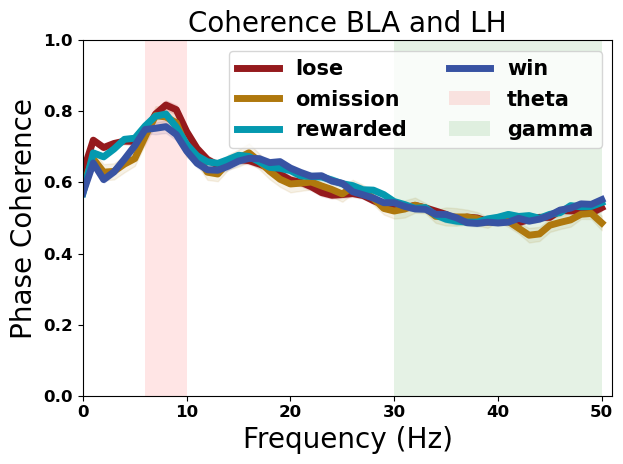

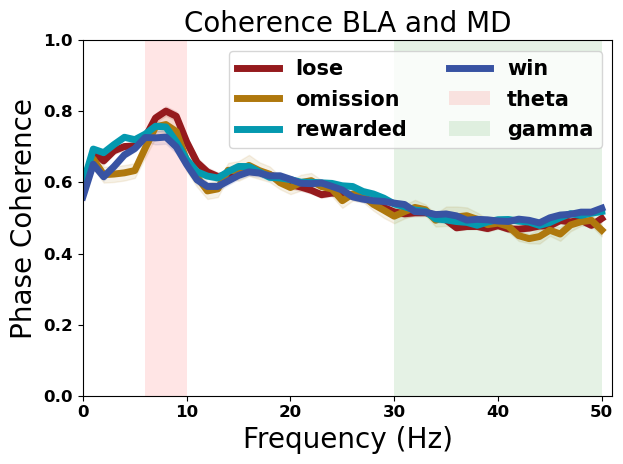

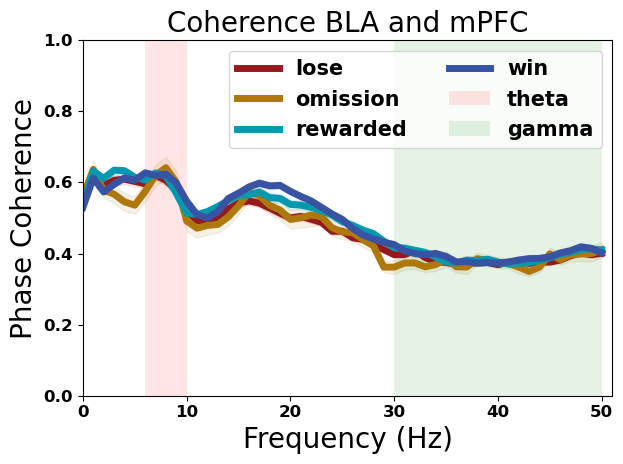

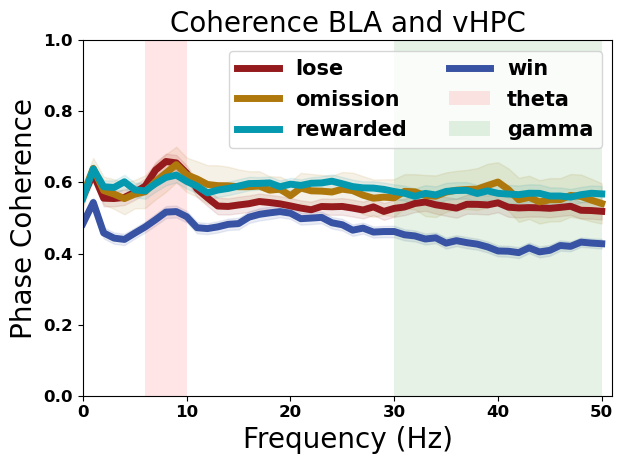

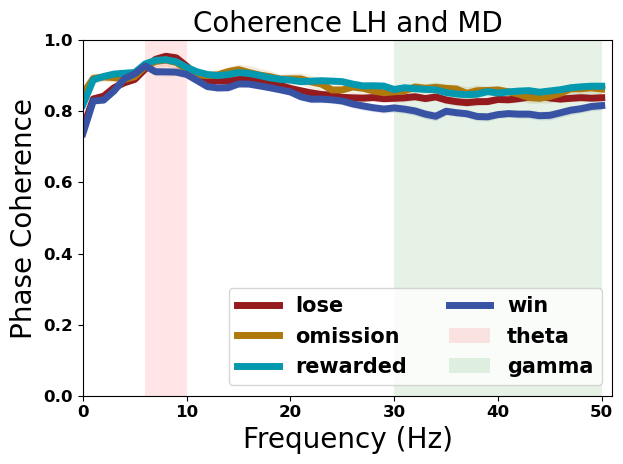

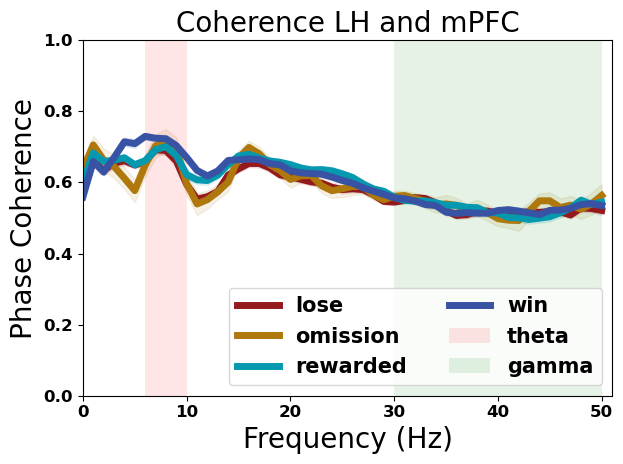

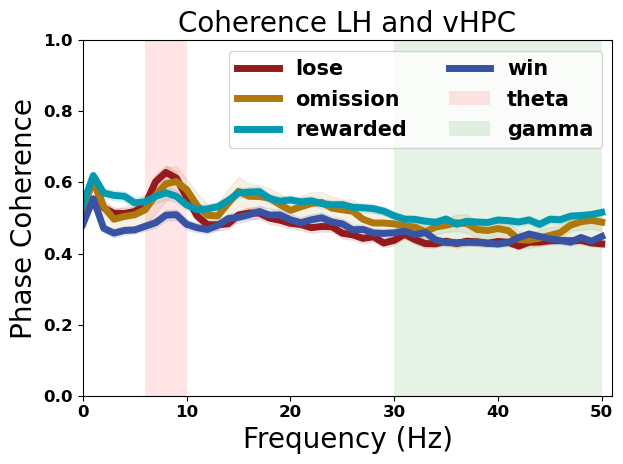

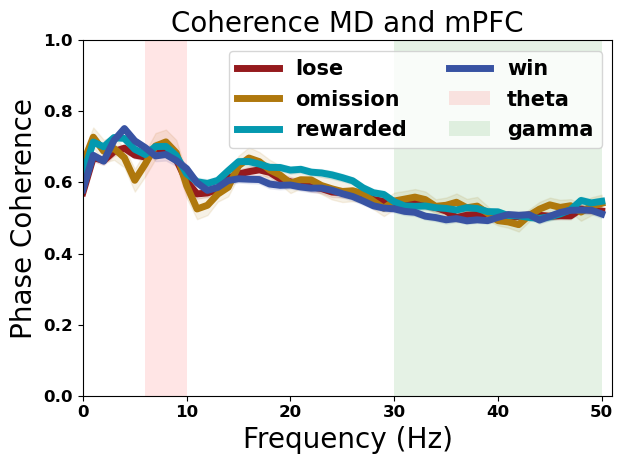

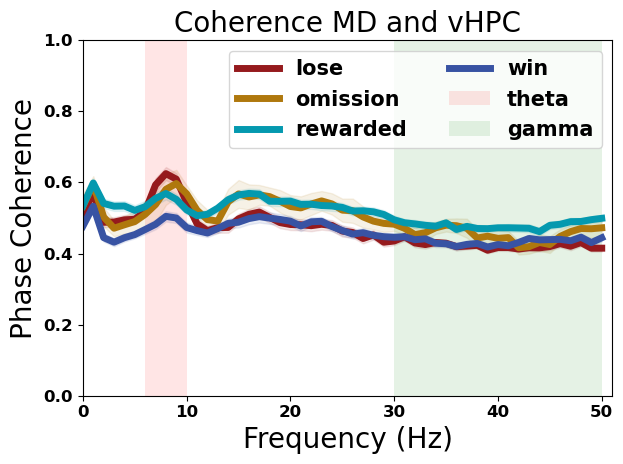

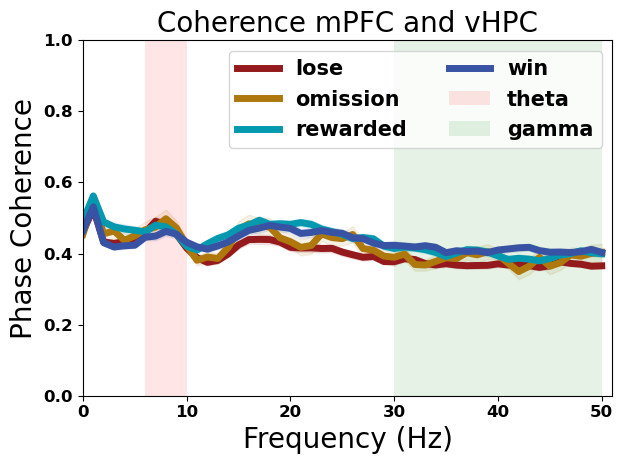

In [76]:
low_freq = 0
high_freq = 51

current_frequencies = np.arange(low_freq, high_freq)
for col in window_mean_coherence_columns:
    region_1 = col.split("_")[0]
    region_2 = col.split("_")[1]
    
    
    
    fig, ax = plt.subplots()
    plt.title("Coherence {} and {}".format(region_1, region_2), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Phase Coherence", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)
    for index, row in mean_grouped_trials_df.iterrows():
        mean_array = row[col][low_freq: high_freq]
        sem_array = sem_grouped_trials_df[col].loc[index][low_freq:high_freq]

        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_array, \
            label="{}".format(row["trial_outcome"]), linewidth=5, color=OUTCOME_TO_COLOR[row["trial_outcome"]])
            
            plt.fill_between(current_frequencies, 
            mean_array - sem_array, mean_array + sem_array, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["trial_outcome"]])
    
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)


    plt.tight_layout()
    plt.savefig("./proc/coherence/coherence_spectra_all_conditions/rce_coherence_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region_1, region_2))
    plt.savefig("./proc/coherence/coherence_spectra_all_conditions/rce_coherence_freq_{}_to_{}_region_{}_{}.eps".format(low_freq, high_freq, region_1, region_2))

# Filtering for each frequency band

In [78]:
window_mean_coherence_columns = [col for col in MERGED_LFP_AND_SLEAP if "window_mean_coherence" in col]

In [79]:
window_mean_coherence_columns

['BLA_LH_window_mean_coherence',
 'BLA_MD_window_mean_coherence',
 'BLA_mPFC_window_mean_coherence',
 'BLA_vHPC_window_mean_coherence',
 'LH_MD_window_mean_coherence',
 'LH_mPFC_window_mean_coherence',
 'LH_vHPC_window_mean_coherence',
 'MD_mPFC_window_mean_coherence',
 'MD_vHPC_window_mean_coherence',
 'mPFC_vHPC_window_mean_coherence']

In [99]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.dropna(subset=window_mean_coherence_columns).reset_index(drop=True)

In [100]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0  30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
1  32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
2  34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
3  35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
4  37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             6.1  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1             6.1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2             6.1  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3             6.1  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4             6.1  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                                mPFC_trial_lfp_trace  \
0  [0.50154364, 0.29617018, 0.22050627, 0.1145767...   
1  [0.31995025, 0.16429879, 0.010809131, 0.067016...   
2  [-0.13835686, 0.42804158, 0.5945022, 0.3134648...   
3  [-0.32211208, 0.023780087, 0.13835686, -0.1102...   
4  [-2.9508927, -2.998453, -2.3282866, -2.0104983...   

                       mPFC_baseline-trial_lfp_trace  \
0  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                             vHPC_baseline_lfp_trace  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...   

                                vHPC_trial_lfp_trace  \
0  [-1.1479185, -1.1806493, -1.1432426, -1.139735...   
1  [-1.0205019, -0.9152954, -0.9947847, -0.976081...   
2  [0.47109076, 0.34016728, 0.18352668, 0.174175,...   
3  [0.15780956, 0.047927346, -0.14728892, -0.3565...   
4  [-4.0457697, -4.2304654, -3.9113393, -3.448431...   

                       vHPC_baseline-trial_lfp_trace  ...  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...  ...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...  ...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...  ...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...  ...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...  ...   

  LH_vHPC_gamma_band_coherence MD_mPFC_theta_band_coherence  \
0                     0.288404                     0.583218   
1                     0.340205                     0.542830   
2                     0.338596                     0.418090   
3                     0.392903                     0.661040   
4                     0.322194                     0.470278   

  MD_mPFC_beta_band_coherence MD_mPFC_gamma_band_coherence  \
0                    0.454306                     0.464452   
1                    0.495208                     0.387060   
2                    0.455595                     0.402038   
3                    0.497122                     0.470142   
4                    0.539432                     0.429987   

  MD_vHPC_theta_band_coherence MD_vHPC_beta_band_coherence  \
0                     0.431280                    0.331778   
1                     0.387470                    0.358093   
2                     0.345314                    0.332709   
3                     0.344467                    0.329513   
4                     0.370317                    0.355492   

  MD_vHPC_gamma_band_coherence mPFC_vHPC_theta_band_coherence  \
0                     0.317880                       0.396990   
1                     0.330735                       0.383185   
2                     0.346608                       0.413

In [101]:
BAND_TO_FREQ

{'theta': (6, 11), 'beta': (20, 31), 'gamma': (30, 51)}

In [102]:
for coherence_column in window_mean_coherence_columns:
    region_1 = coherence_column.split("_")[0]
    region_2 = coherence_column.split("_")[1]
    
    for band, (low_freq, high_freq) in BAND_TO_FREQ.items():
        region_band_column = "{}_{}_{}_band_coherence".format(region_1, region_2, band)
        MERGED_LFP_AND_SLEAP[region_band_column] = MERGED_LFP_AND_SLEAP[coherence_column].apply(lambda x: np.mean(x[low_freq: high_freq]))

In [104]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0  30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
1  32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
2  34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
3  35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
4  37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             6.1  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1             6.1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2             6.1  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3             6.1  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4             6.1  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                                mPFC_trial_lfp_trace  \
0  [0.50154364, 0.29617018, 0.22050627, 0.1145767...   
1  [0.31995025, 0.16429879, 0.010809131, 0.067016...   
2  [-0.13835686, 0.42804158, 0.5945022, 0.3134648...   
3  [-0.32211208, 0.023780087, 0.13835686, -0.1102...   
4  [-2.9508927, -2.998453, -2.3282866, -2.0104983...   

                       mPFC_baseline-trial_lfp_trace  \
0  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                             vHPC_baseline_lfp_trace  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...   

                                vHPC_trial_lfp_trace  \
0  [-1.1479185, -1.1806493, -1.1432426, -1.139735...   
1  [-1.0205019, -0.9152954, -0.9947847, -0.976081...   
2  [0.47109076, 0.34016728, 0.18352668, 0.174175,...   
3  [0.15780956, 0.047927346, -0.14728892, -0.3565...   
4  [-4.0457697, -4.2304654, -3.9113393, -3.448431...   

                       vHPC_baseline-trial_lfp_trace  ...  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...  ...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...  ...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...  ...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...  ...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...  ...   

  LH_vHPC_gamma_band_coherence MD_mPFC_theta_band_coherence  \
0                     0.288404                     0.583218   
1                     0.340205                     0.542830   
2                     0.338596                     0.418090   
3                     0.392903                     0.661040   
4                     0.322194                     0.470278   

  MD_mPFC_beta_band_coherence MD_mPFC_gamma_band_coherence  \
0                    0.454306                     0.464452   
1                    0.495208                     0.387060   
2                    0.455595                     0.402038   
3                    0.497122                     0.470142   
4                    0.539432                     0.429987   

  MD_vHPC_theta_band_coherence MD_vHPC_beta_band_coherence  \
0                     0.431280                    0.331778   
1                     0.387470                    0.358093   
2                     0.345314                    0.332709   
3                     0.344467                    0.329513   
4                     0.370317                    0.355492   

  MD_vHPC_gamma_band_coherence mPFC_vHPC_theta_band_coherence  \
0                     0.317880                       0.396990   
1                     0.330735                       0.383185   
2                     0.346608                       0.413

In [158]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_sleap_and_coherence.pkl")

In [105]:
band_coherence_columns = [col for col in MERGED_LFP_AND_SLEAP if "band_coherence" in col]

In [138]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.dropna(subset=band_coherence_columns).reset_index(drop=True)

In [139]:
band_coherence_columns

['BLA_LH_theta_band_coherence',
 'BLA_LH_beta_band_coherence',
 'BLA_LH_gamma_band_coherence',
 'BLA_MD_theta_band_coherence',
 'BLA_MD_beta_band_coherence',
 'BLA_MD_gamma_band_coherence',
 'BLA_mPFC_theta_band_coherence',
 'BLA_mPFC_beta_band_coherence',
 'BLA_mPFC_gamma_band_coherence',
 'BLA_vHPC_theta_band_coherence',
 'BLA_vHPC_beta_band_coherence',
 'BLA_vHPC_gamma_band_coherence',
 'LH_MD_theta_band_coherence',
 'LH_MD_beta_band_coherence',
 'LH_MD_gamma_band_coherence',
 'LH_mPFC_theta_band_coherence',
 'LH_mPFC_beta_band_coherence',
 'LH_mPFC_gamma_band_coherence',
 'LH_vHPC_theta_band_coherence',
 'LH_vHPC_beta_band_coherence',
 'LH_vHPC_gamma_band_coherence',
 'MD_mPFC_theta_band_coherence',
 'MD_mPFC_beta_band_coherence',
 'MD_mPFC_gamma_band_coherence',
 'MD_vHPC_theta_band_coherence',
 'MD_vHPC_beta_band_coherence',
 'MD_vHPC_gamma_band_coherence',
 'mPFC_vHPC_theta_band_coherence',
 'mPFC_vHPC_beta_band_coherence',
 'mPFC_vHPC_gamma_band_coherence']

In [141]:
region_and_band_to_mannwhitneyu = []
for col in band_coherence_columns:
    region_1 = col.split("_")[0]
    region_2 = col.split("_")[1]
    band = col.split("_")[2]
    for first_outcome, second_outcome in combinations(sorted(MERGED_LFP_AND_SLEAP[GROUPINGS].unique()), 2):
        first_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == first_outcome]
        second_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == second_outcome]
        # print(first_outcome_df[col], second_outcome_df[col])
        statistic, p_value = mannwhitneyu(first_outcome_df[col], second_outcome_df[col], alternative='two-sided')
        # print(statistic, p_value)
        region_and_band_to_mannwhitneyu.append({"brain_region": (region_1, region_2), "band": band, "trial_outcome": (first_outcome, second_outcome), "statistic": statistic, "p_value": p_value})

In [143]:
region_and_band_to_mannwhitneyu = pd.DataFrame(region_and_band_to_mannwhitneyu)

In [144]:
region_and_band_to_mannwhitneyu["significance"] = region_and_band_to_mannwhitneyu["p_value"].apply(lambda x: get_significance_stars_from_p_value(x))

In [145]:
region_and_band_to_mannwhitneyu = region_and_band_to_mannwhitneyu.sort_values(["band", "brain_region", "p_value"]).reset_index(drop=True)

In [164]:
region_and_band_to_mannwhitneyu = region_and_band_to_mannwhitneyu.sort_values(["band", "brain_region", "p_value"])

In [165]:
region_and_band_to_mannwhitneyu

brain_region   band         trial_outcome  statistic   p_value  \
0       (BLA, LH)   beta      (lose, rewarded)     2742.0  0.023466   
1       (BLA, LH)   beta           (lose, win)     3050.0  0.029612   
2       (BLA, LH)   beta  (omission, rewarded)      586.0  0.247160   
3       (BLA, LH)   beta       (omission, win)      660.0  0.310233   
4       (BLA, LH)   beta       (rewarded, win)     4011.0  0.664348   
..            ...    ...                   ...        ...       ...   
175  (mPFC, vHPC)  theta       (omission, win)      902.0  0.318265   
176  (mPFC, vHPC)  theta           (lose, win)     4042.0  0.416498   
177  (mPFC, vHPC)  theta      (lose, omission)      634.0  0.561995   
178  (mPFC, vHPC)  theta  (omission, rewarded)      772.0  0.601734   
179  (mPFC, vHPC)  theta      (lose, rewarded)     3303.0  0.649975   

    significance  
0                 
1                 
2                 
3                 
4                 
..           ...  
175               
176               
177               
178               
179               

[180 rows x 6 columns]

In [163]:
region_and_band_to_mannwhitneyu.to_csv("./proc/coherence/coherence_region_and_band_to_mannwhitneyu.csv")

In [135]:
sem_coherence_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_coherence_columns].sem()

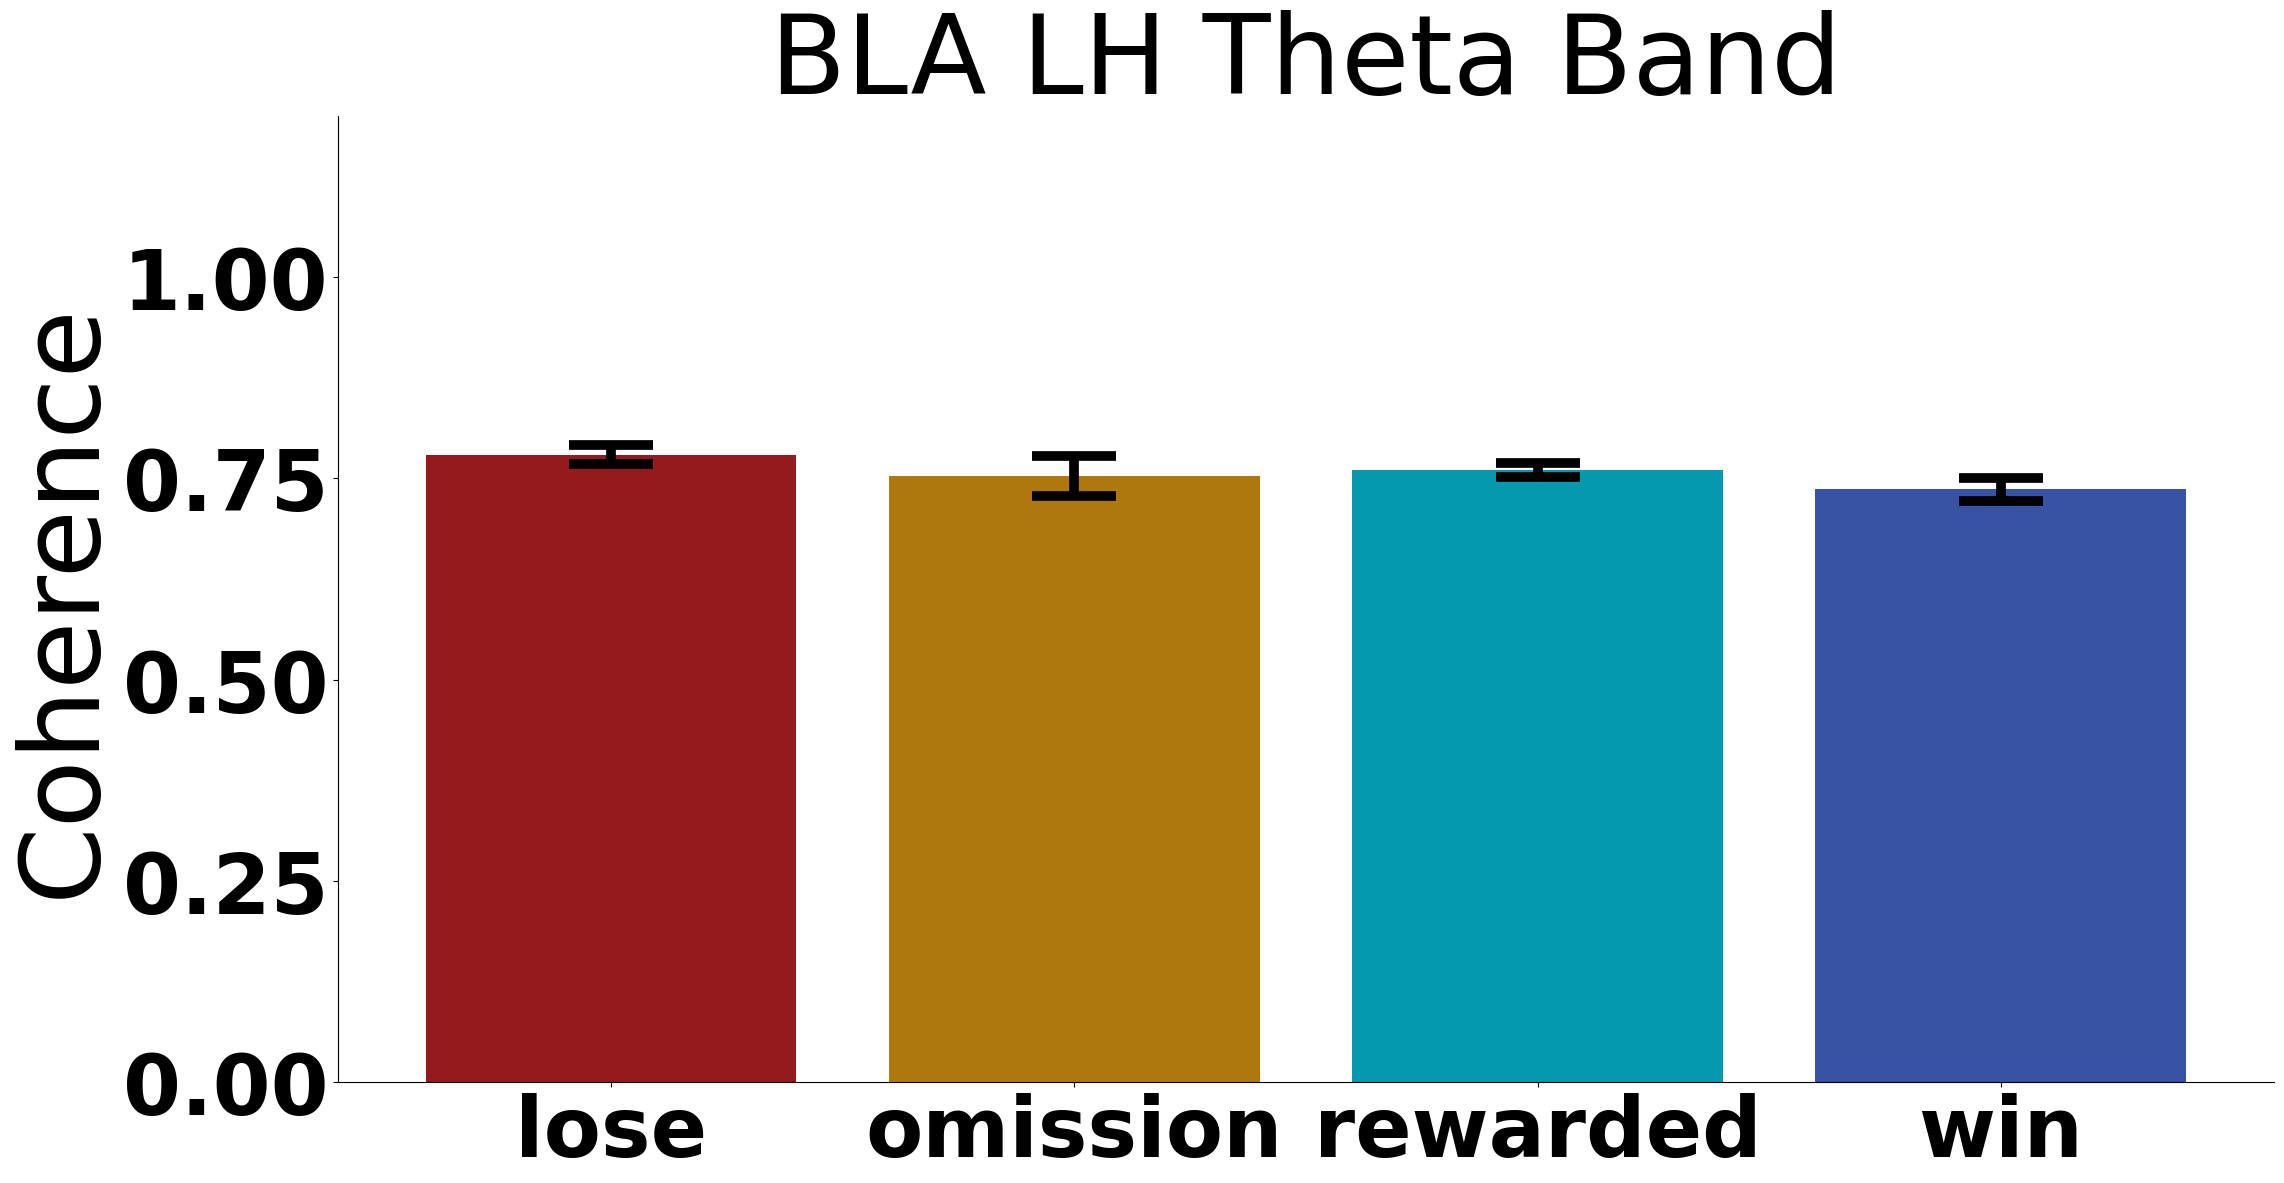

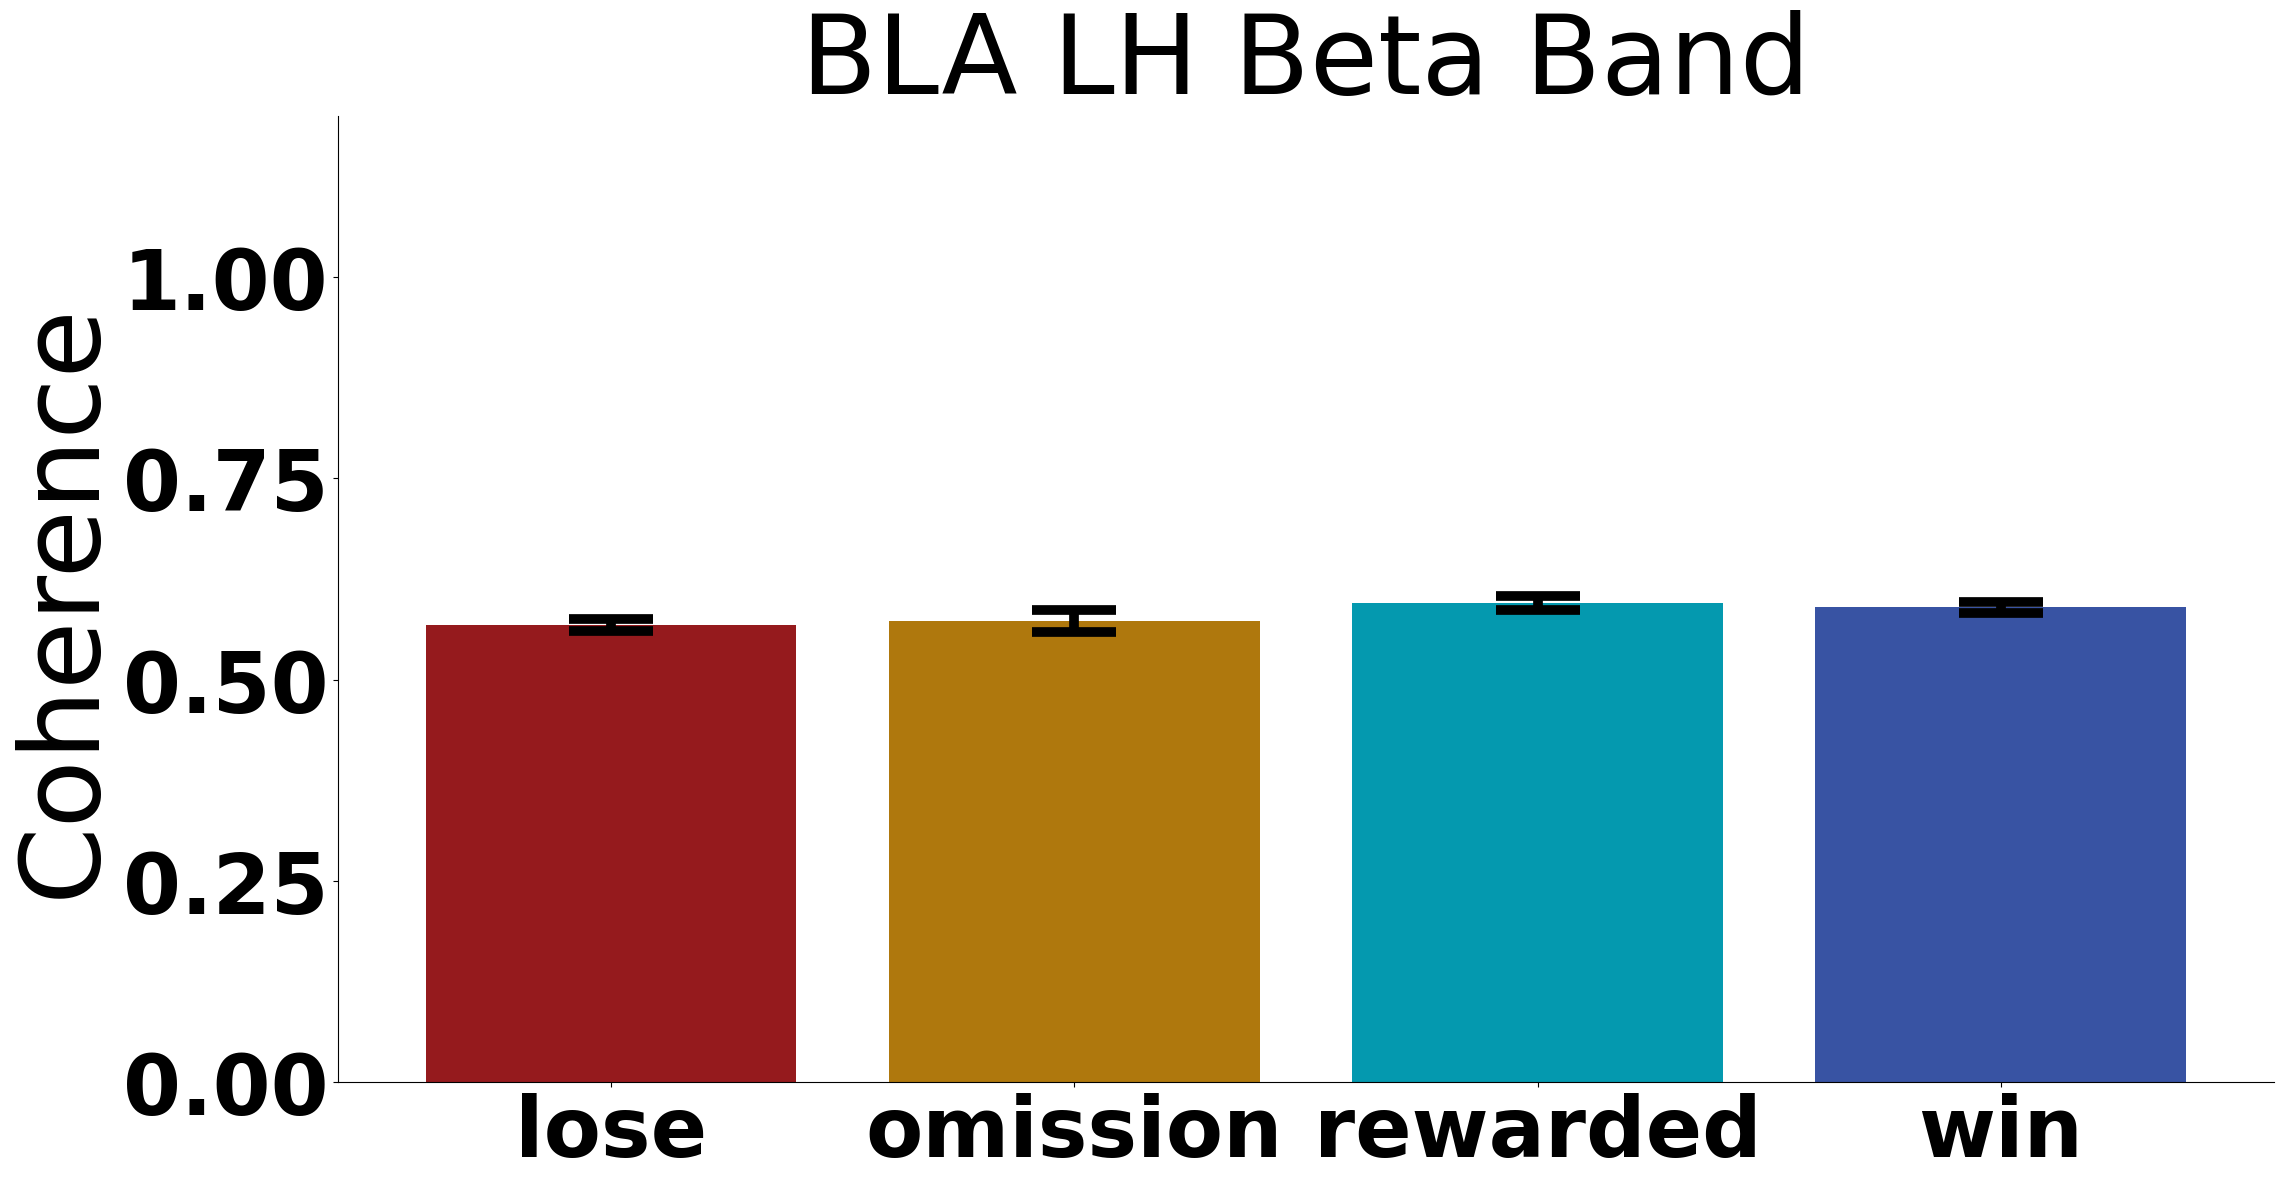

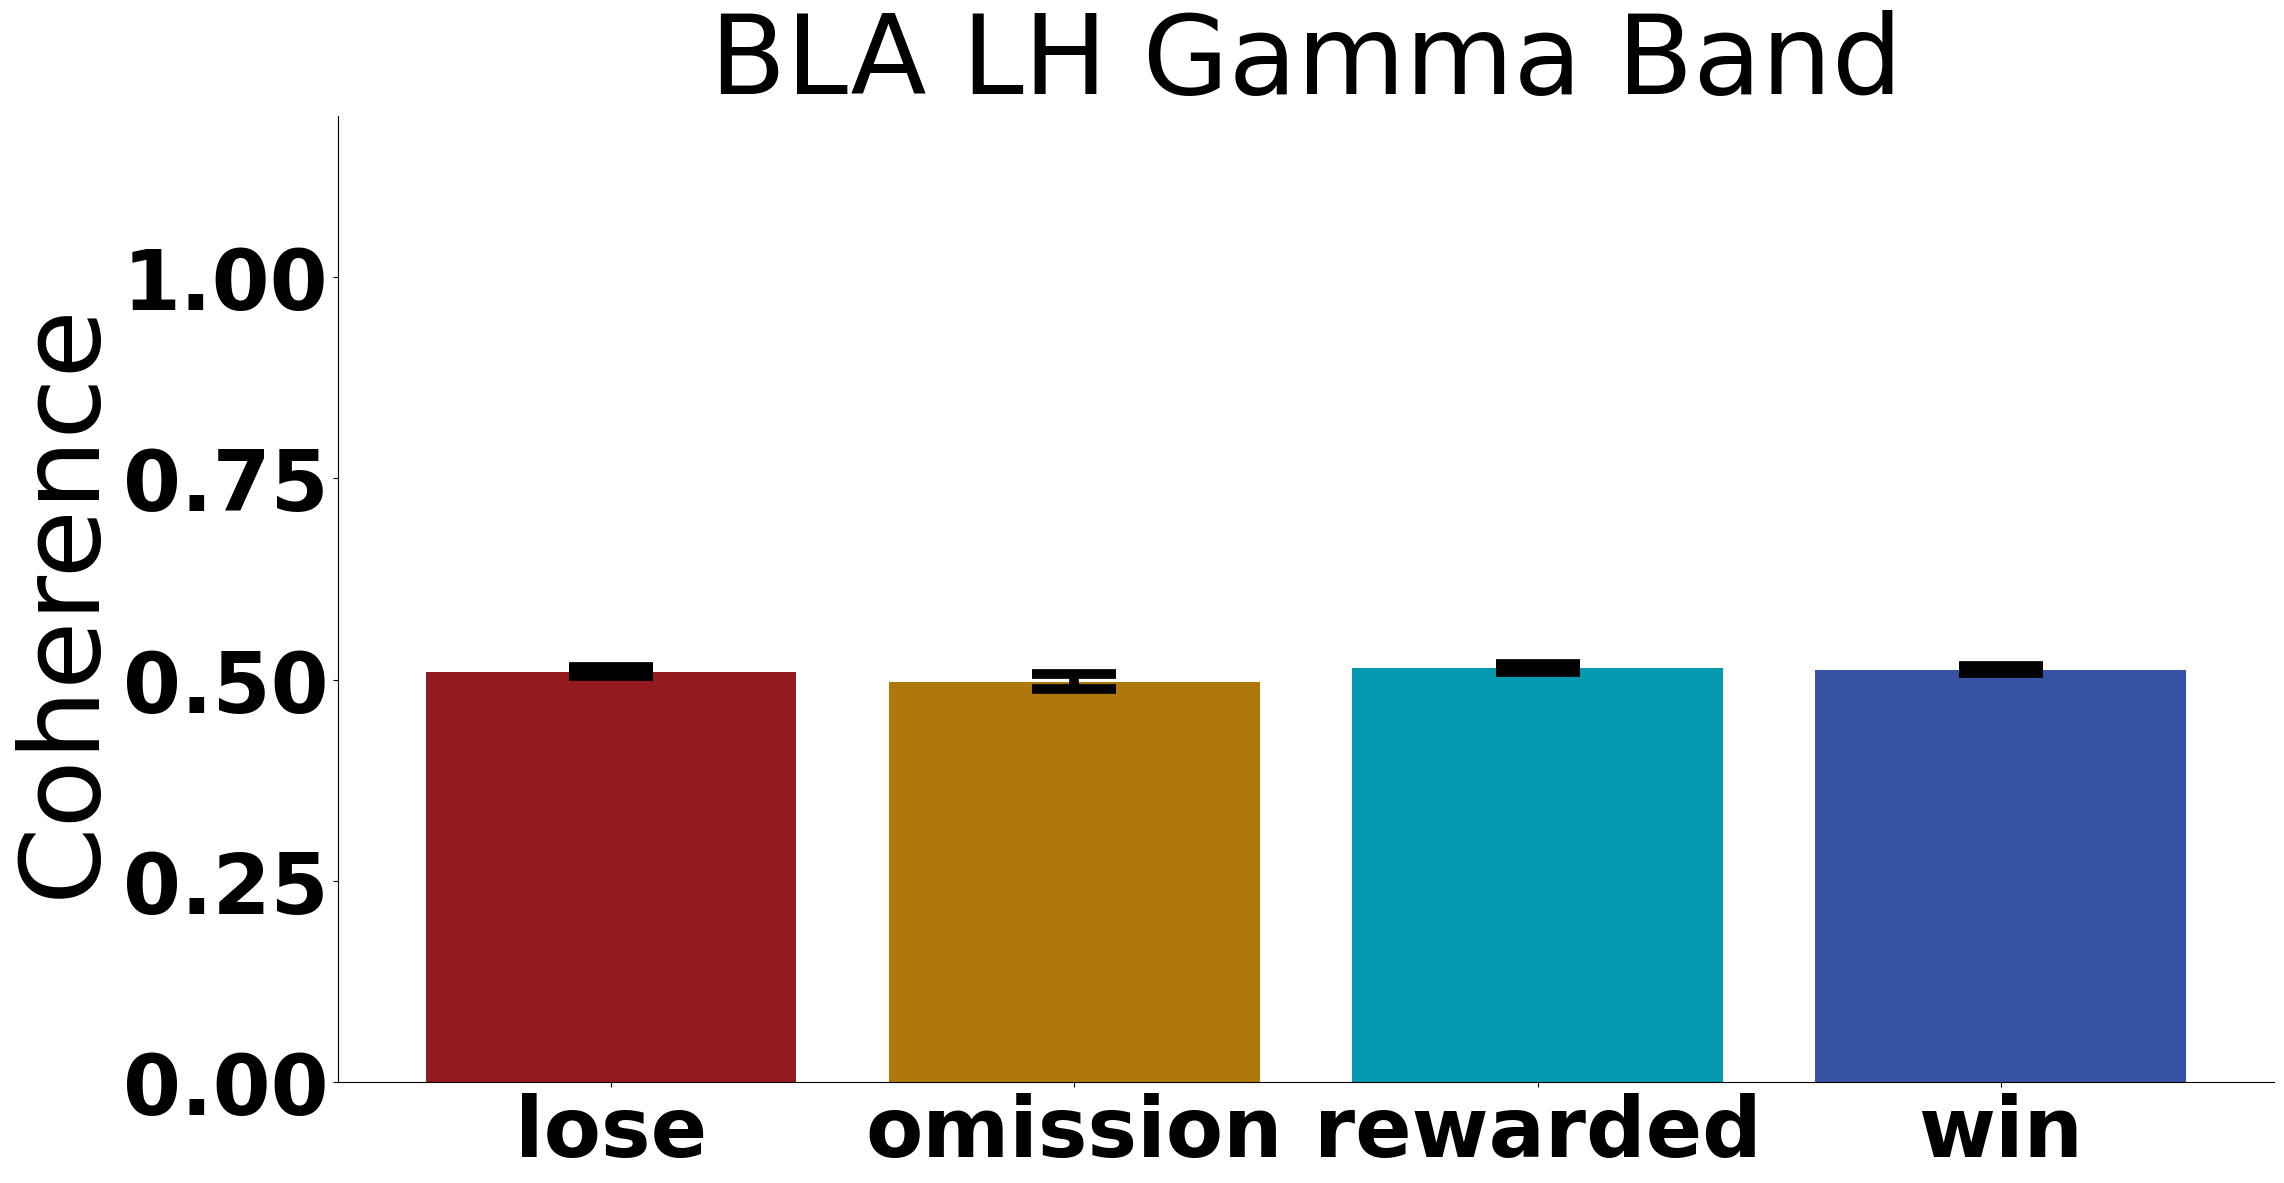

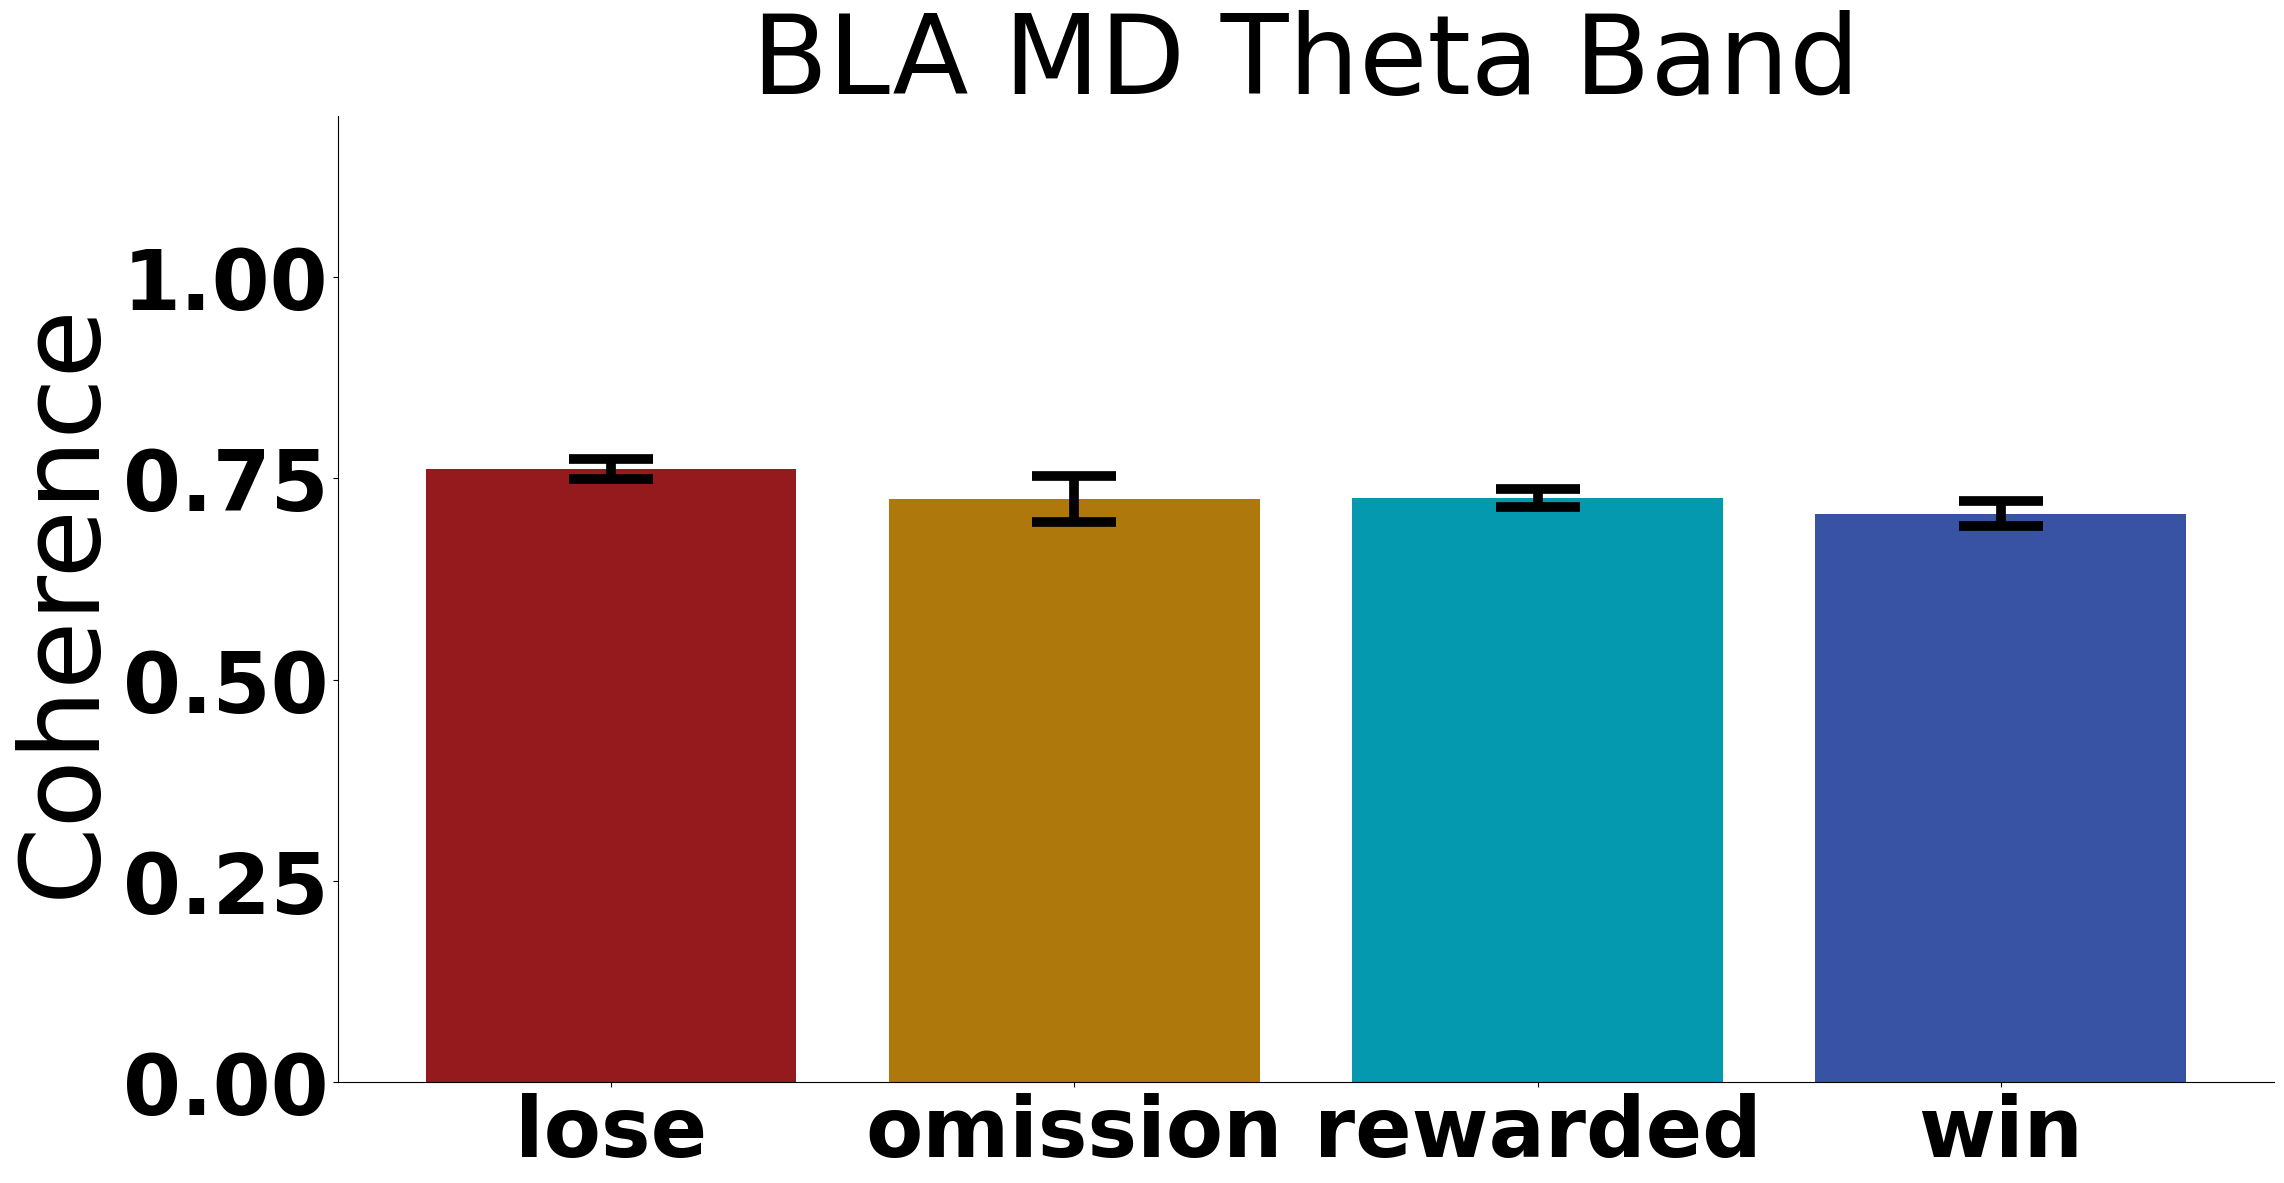

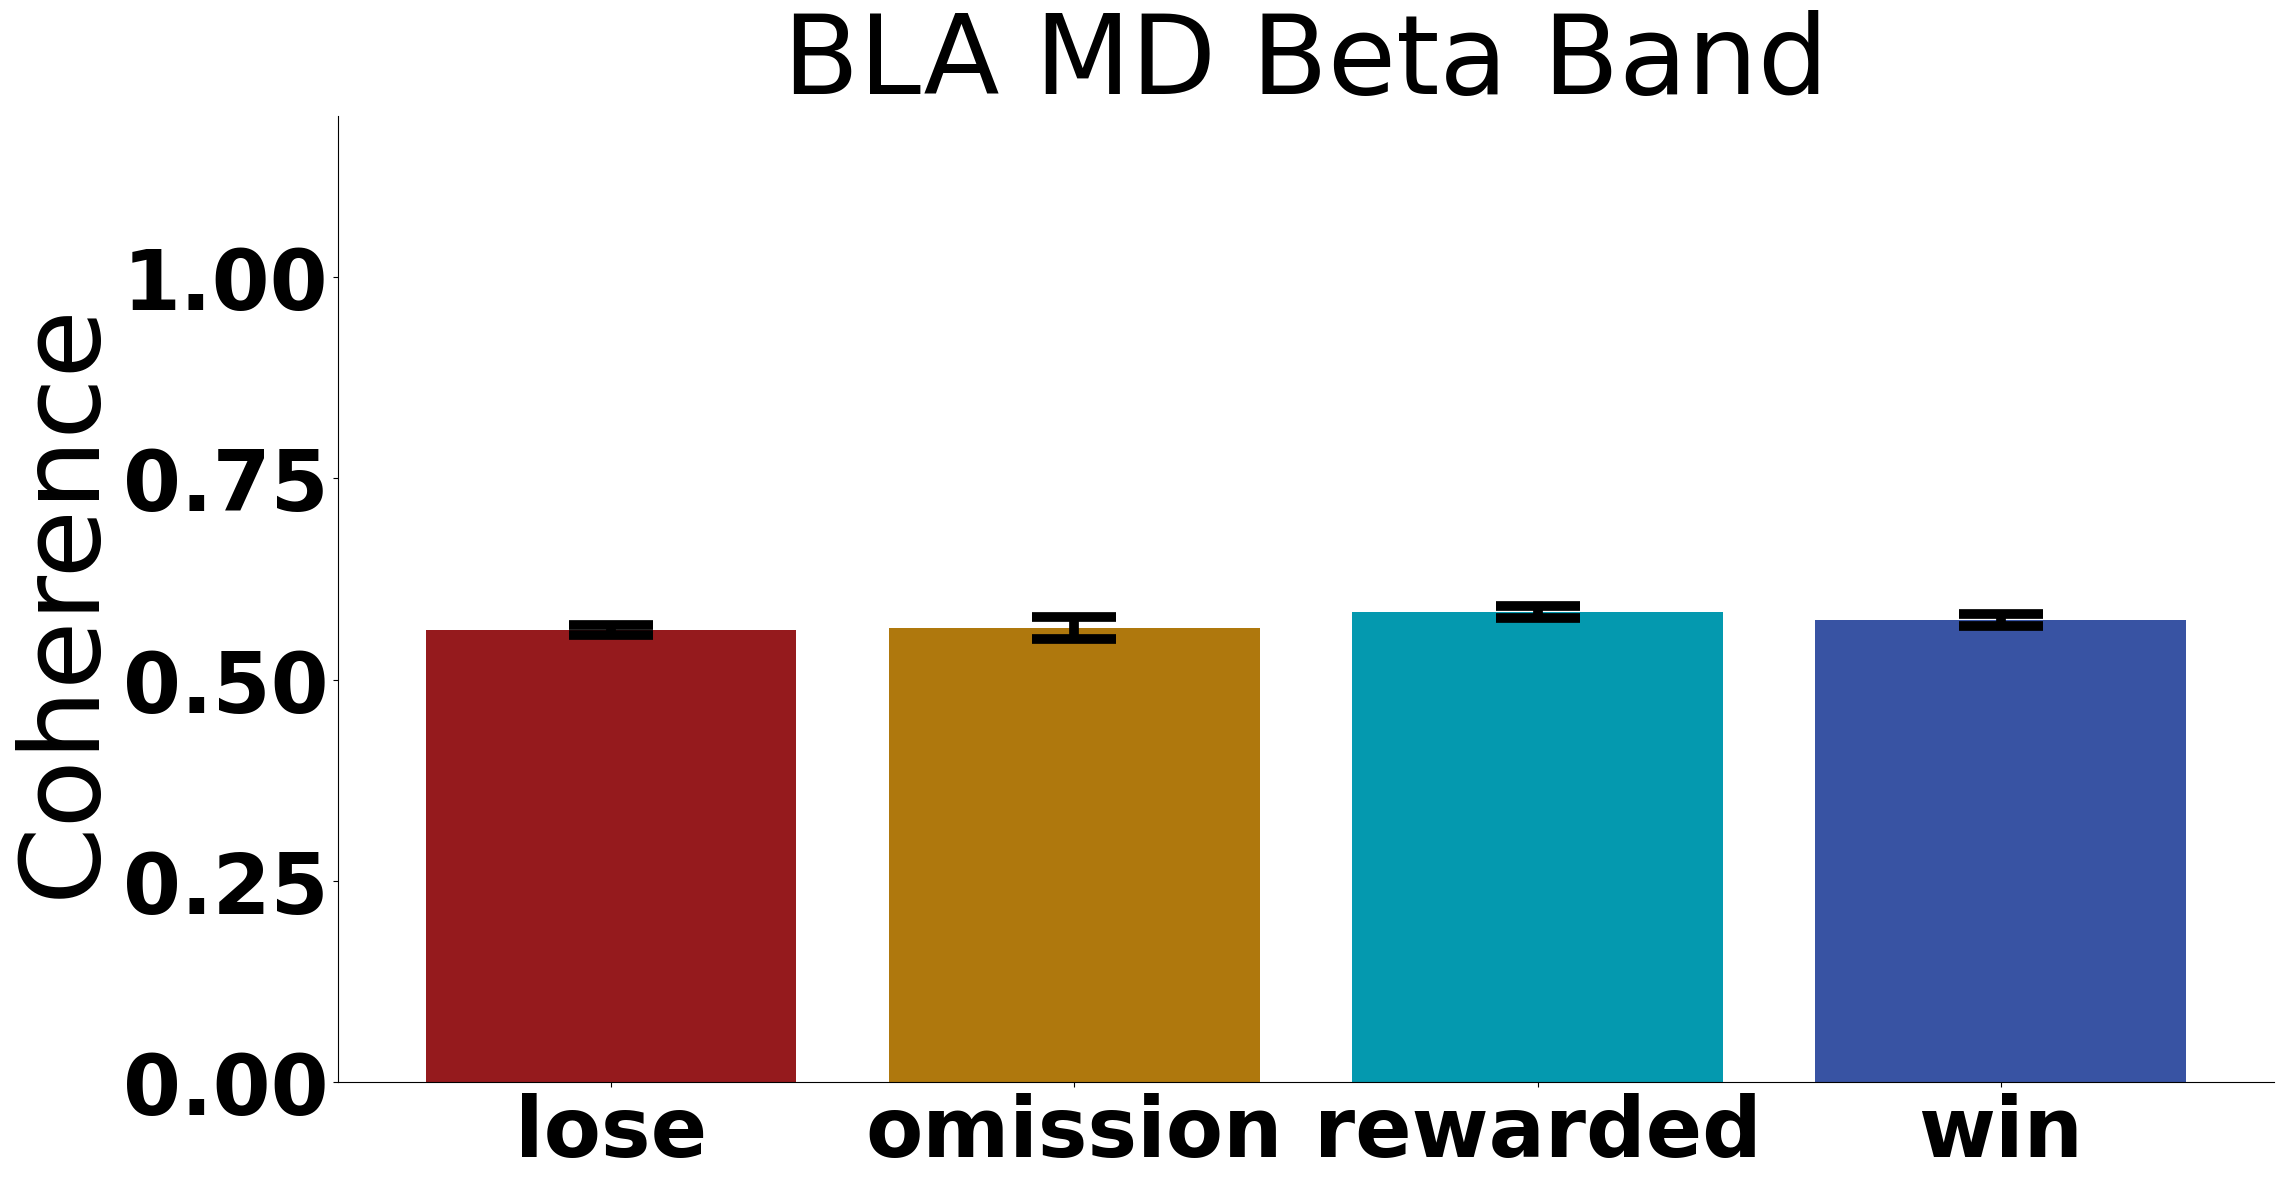

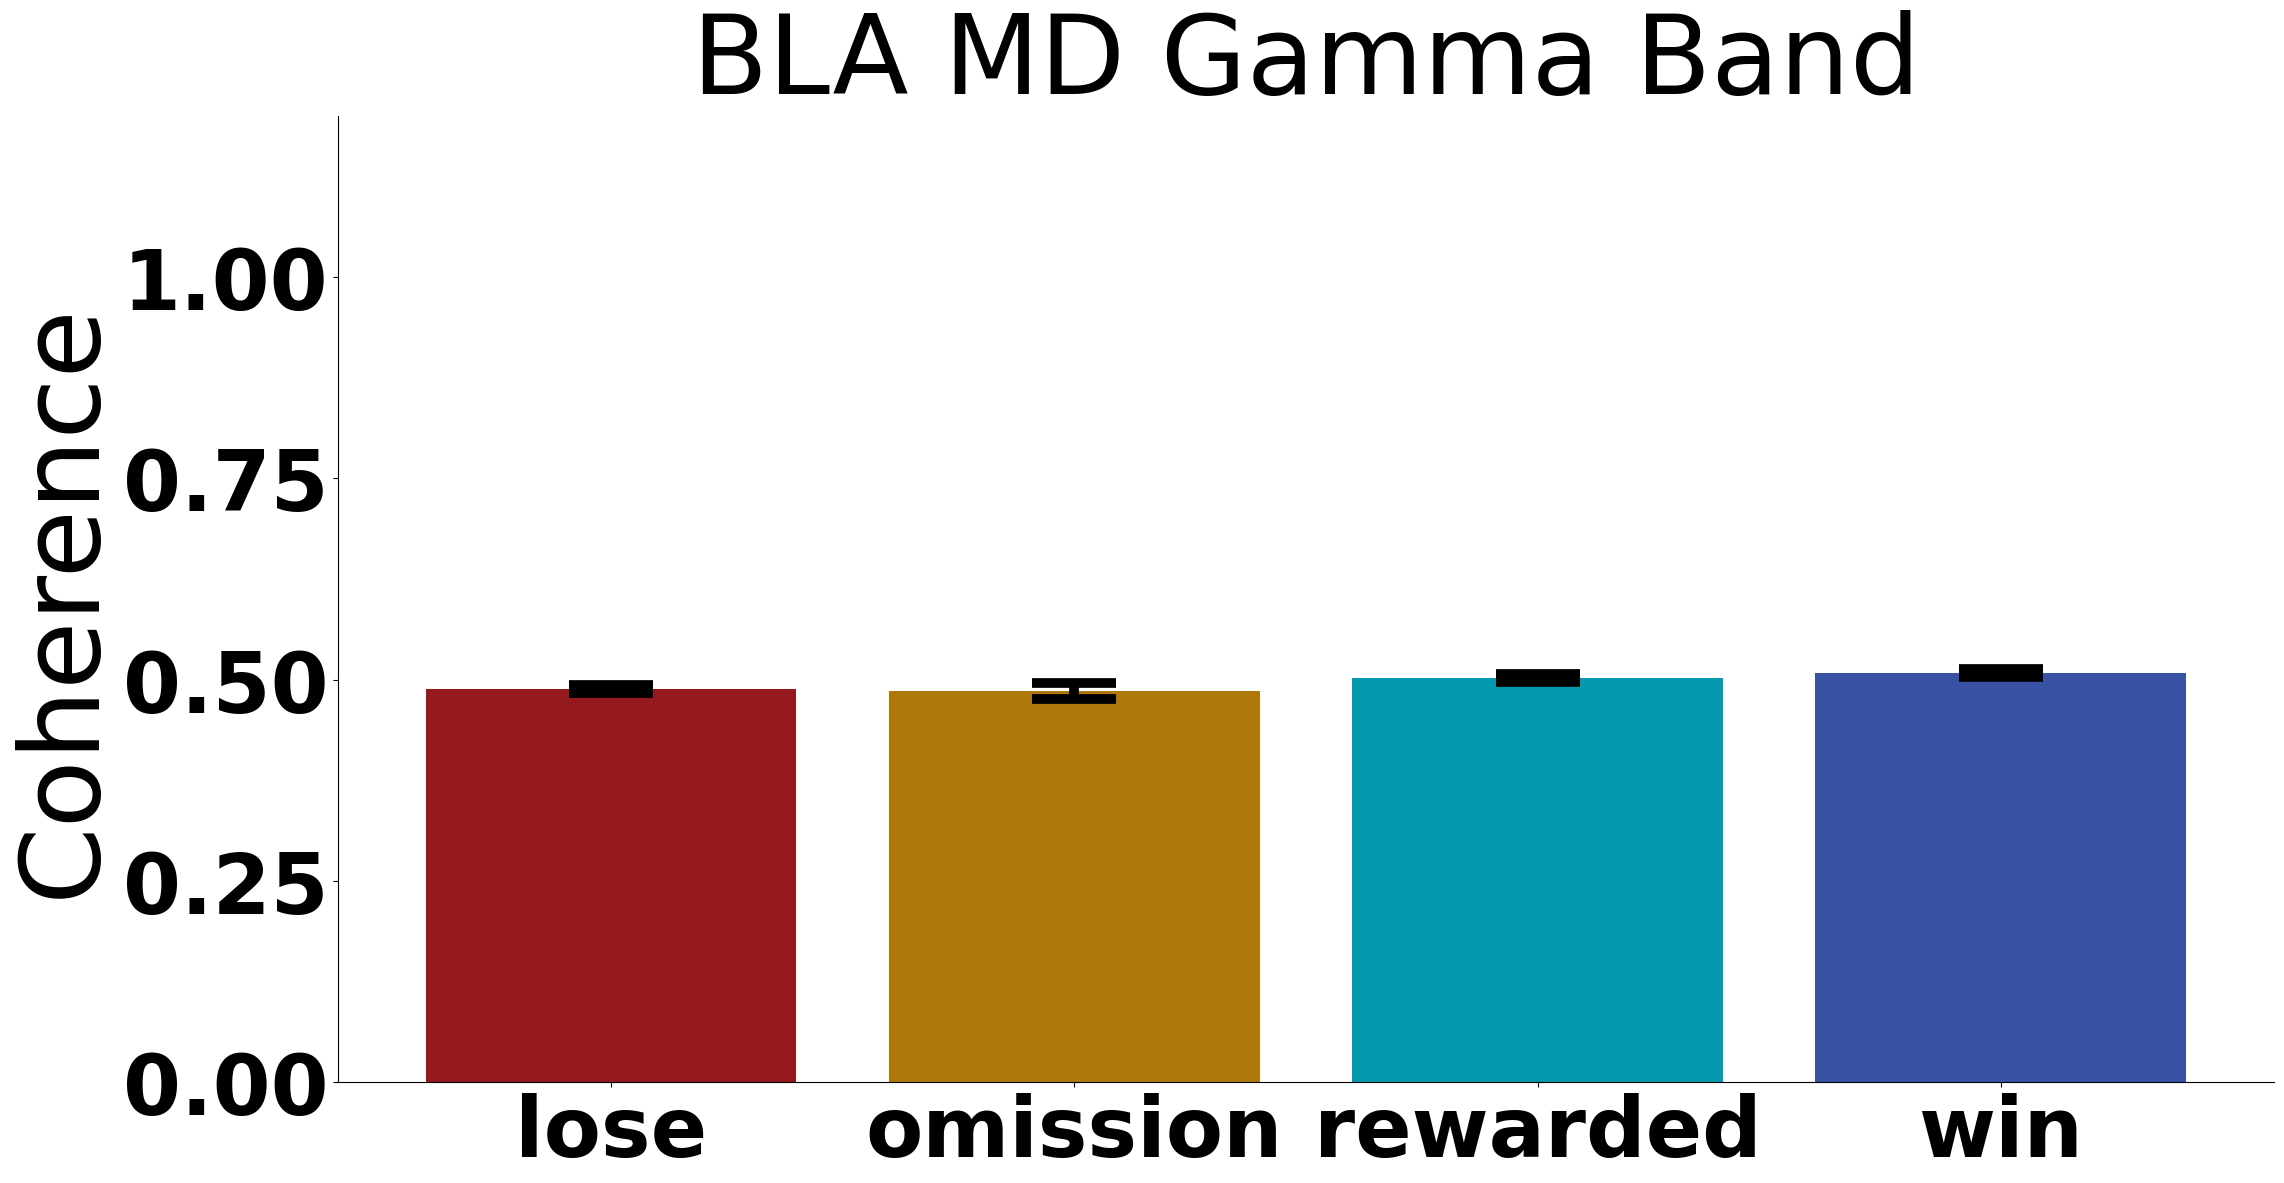

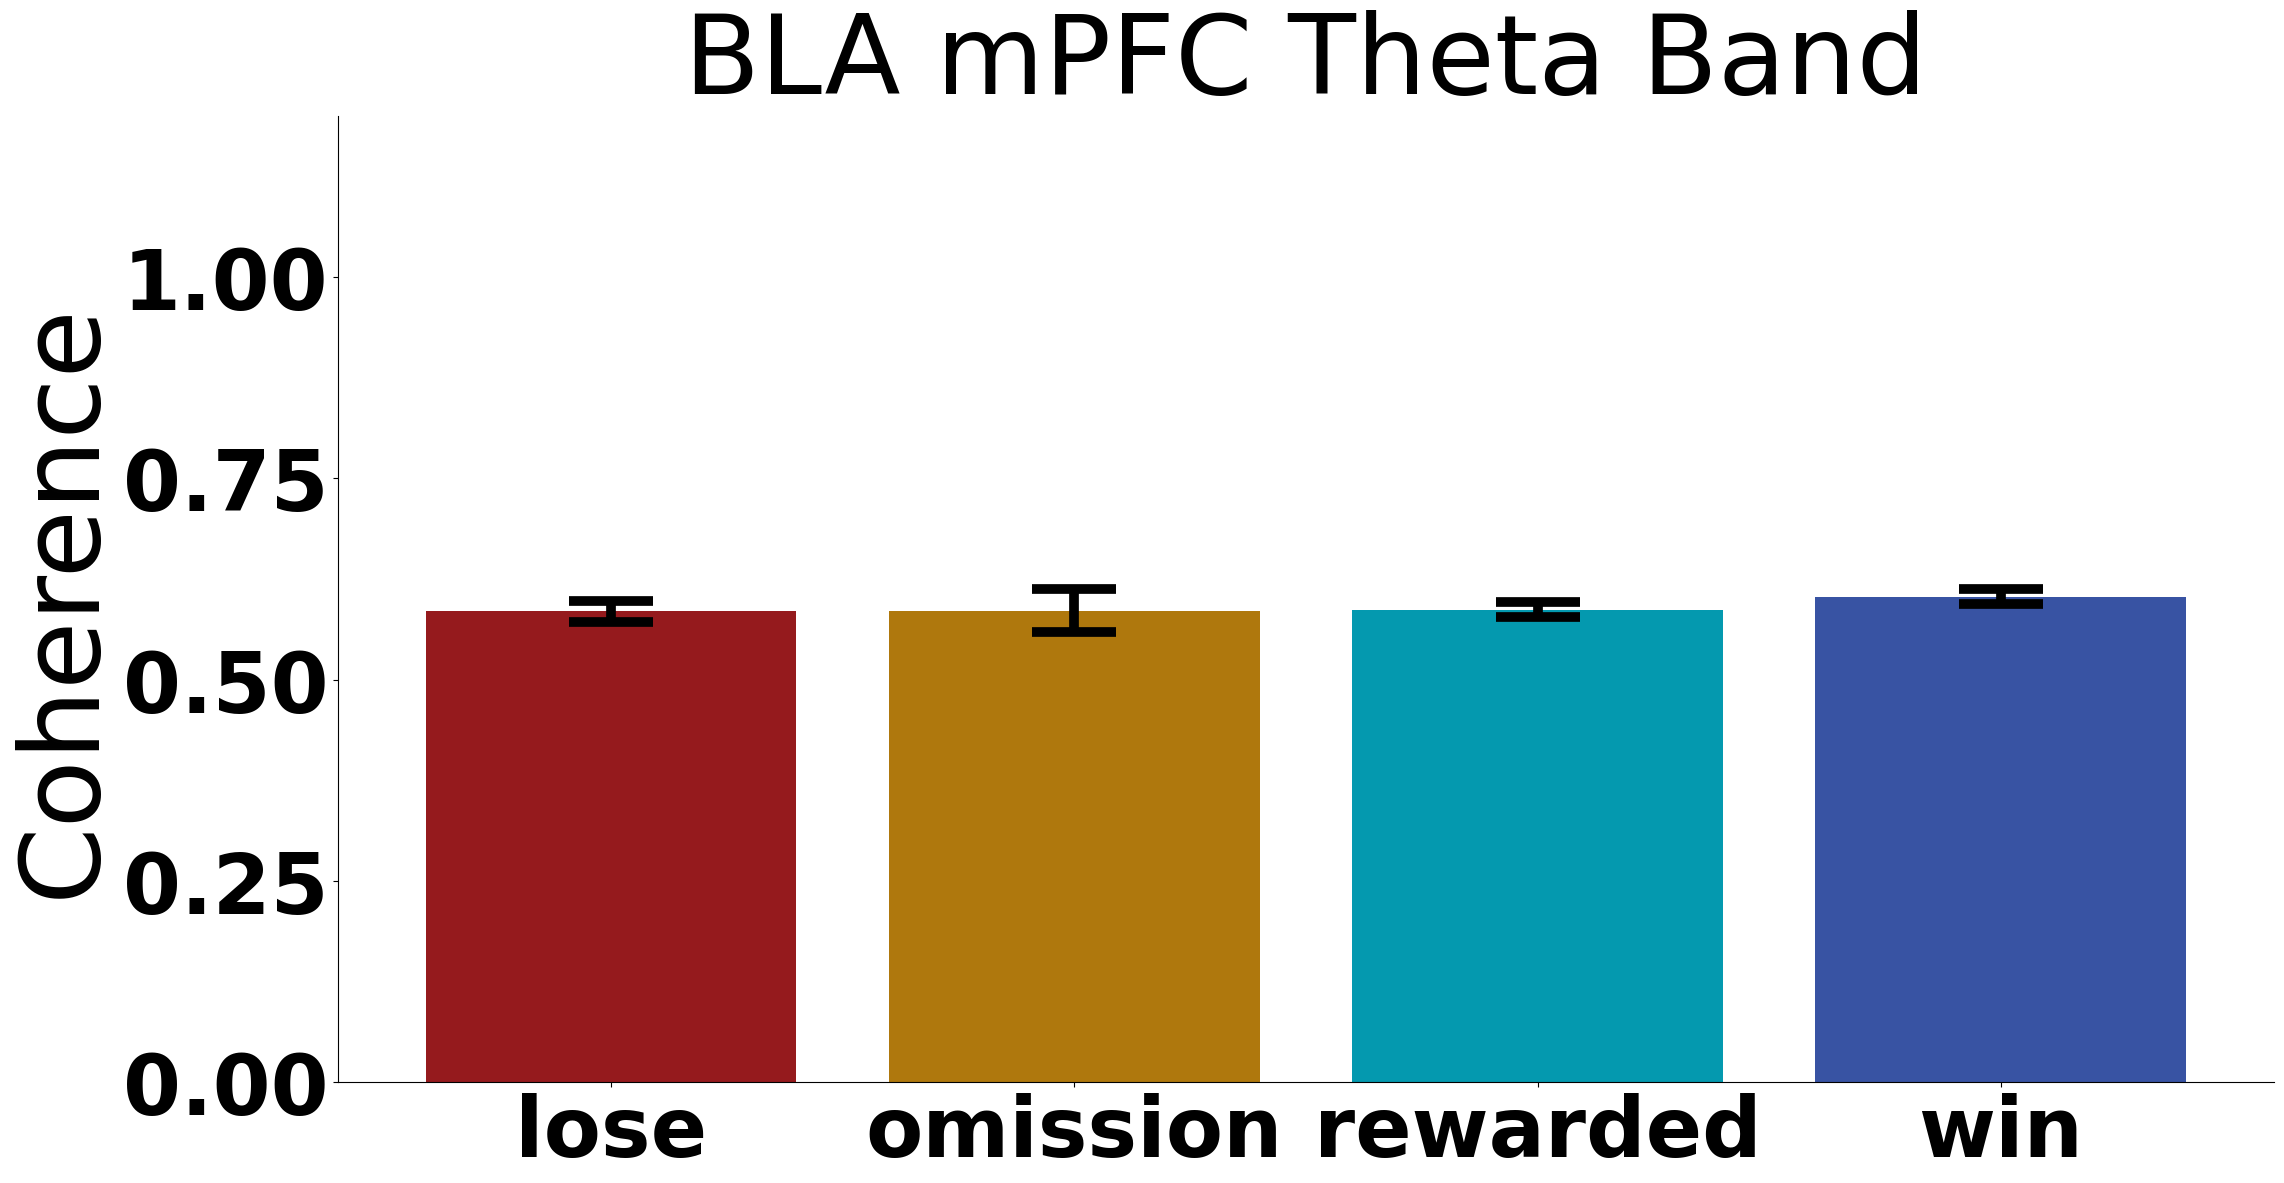

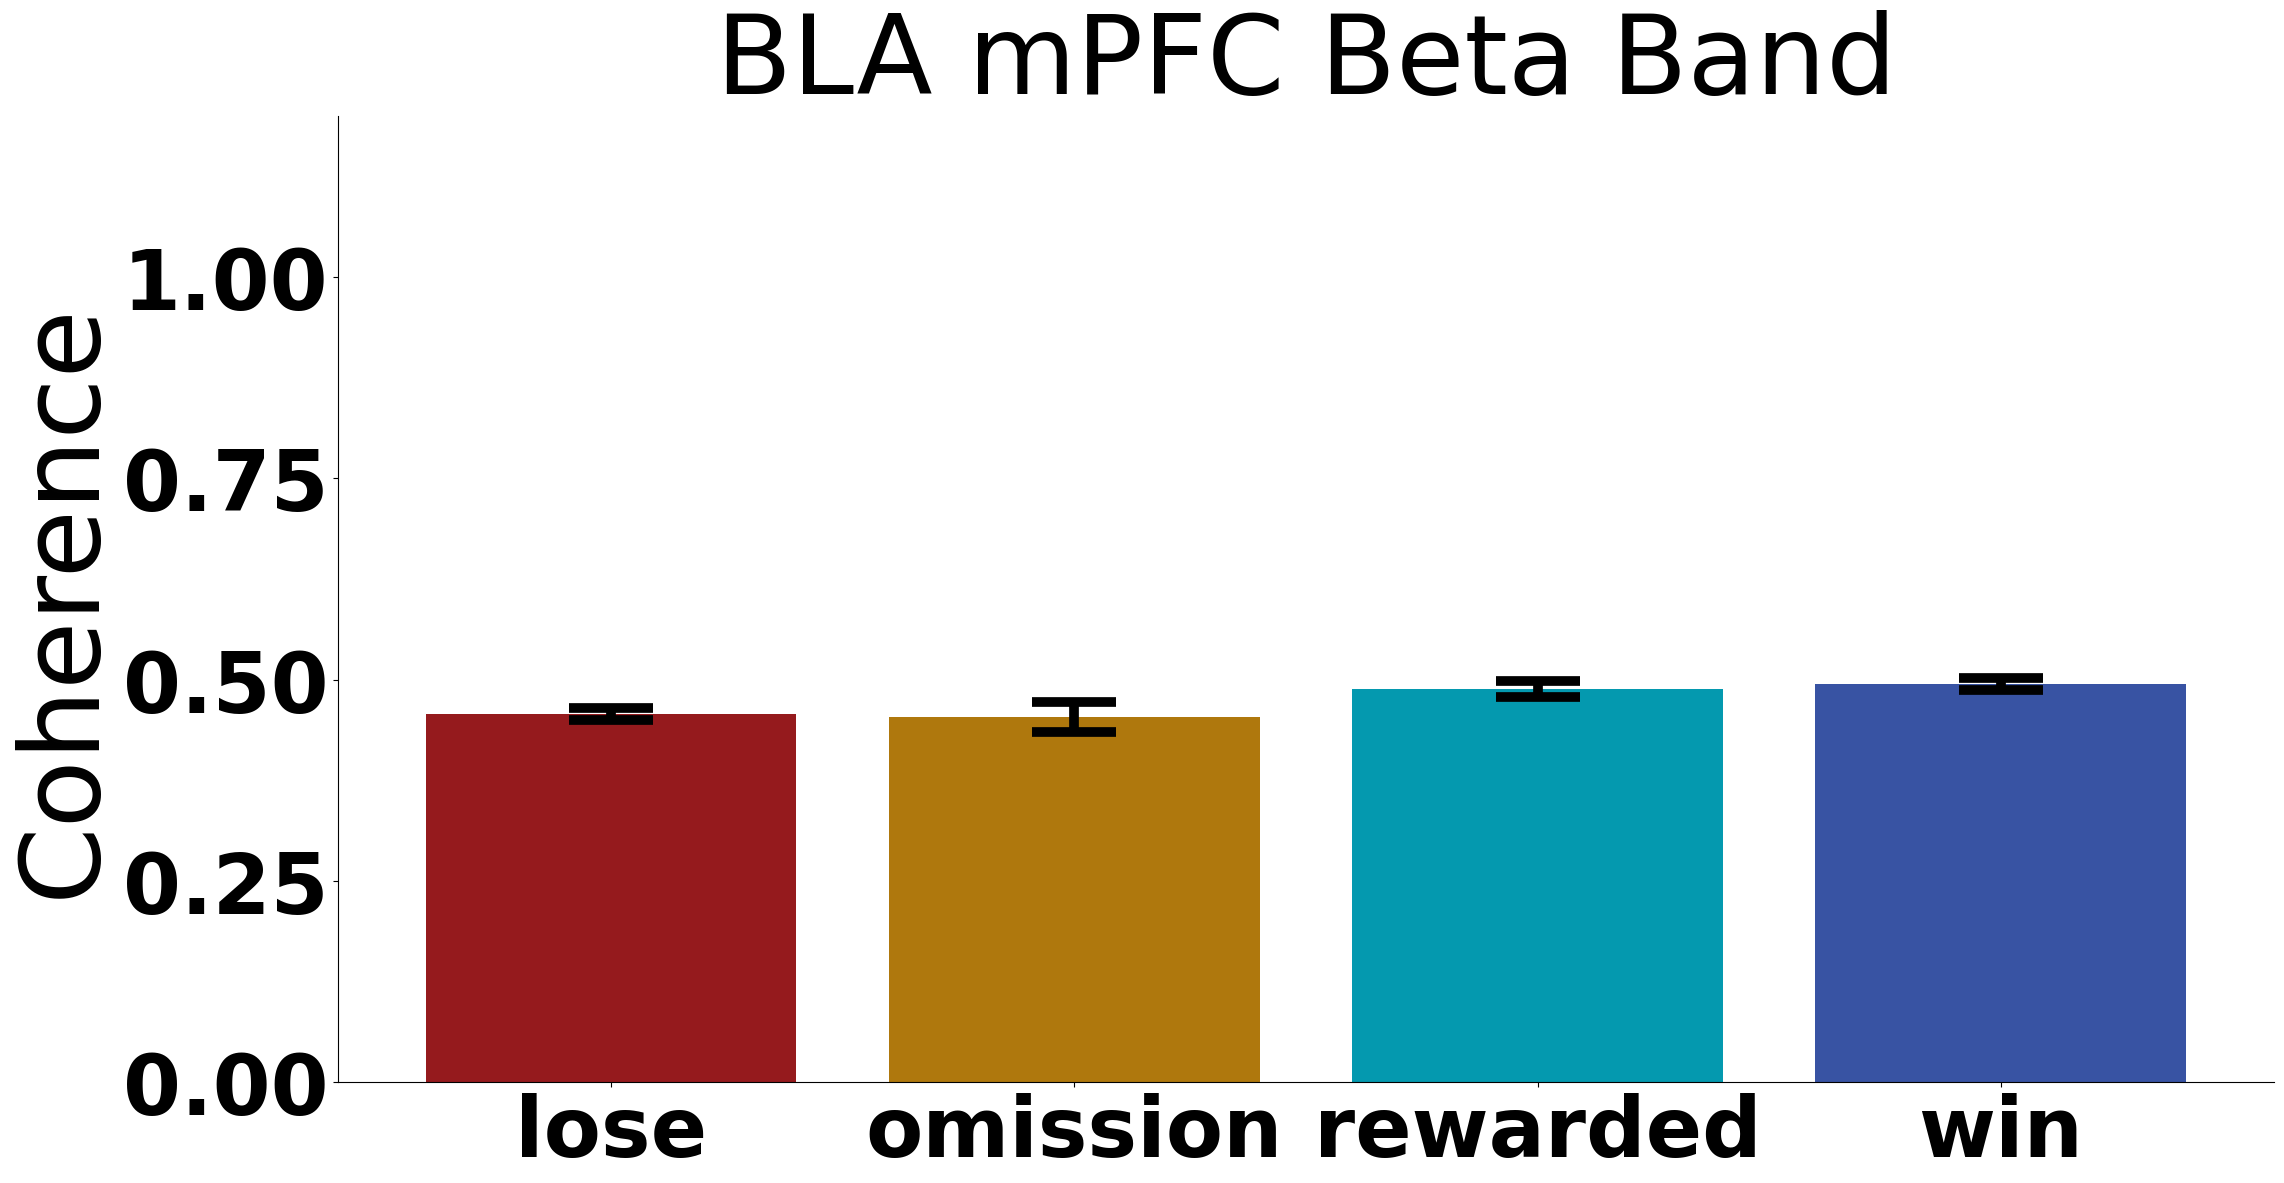

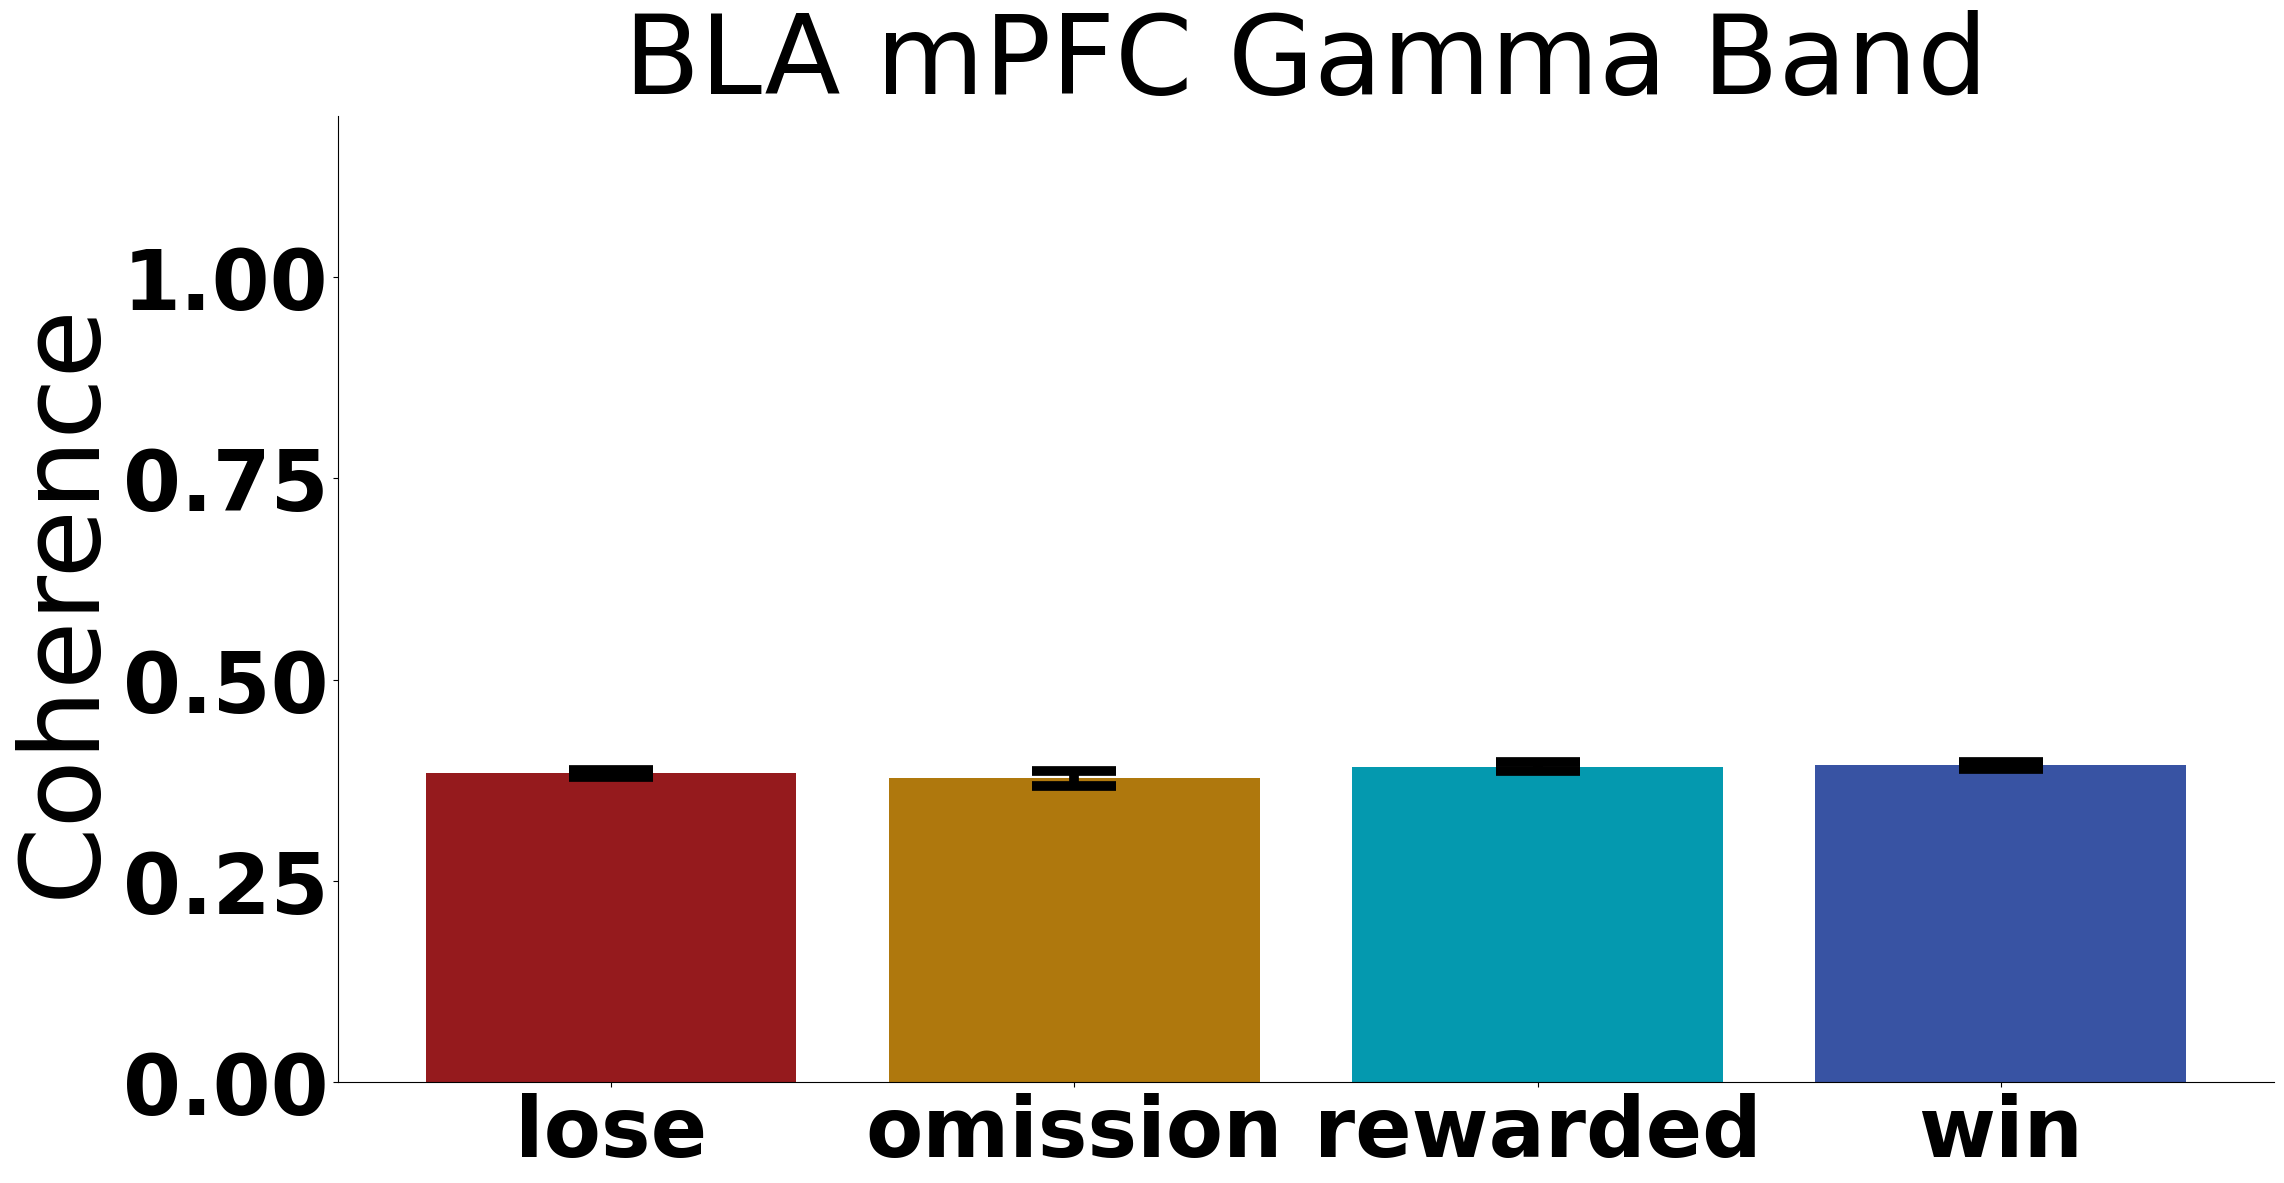

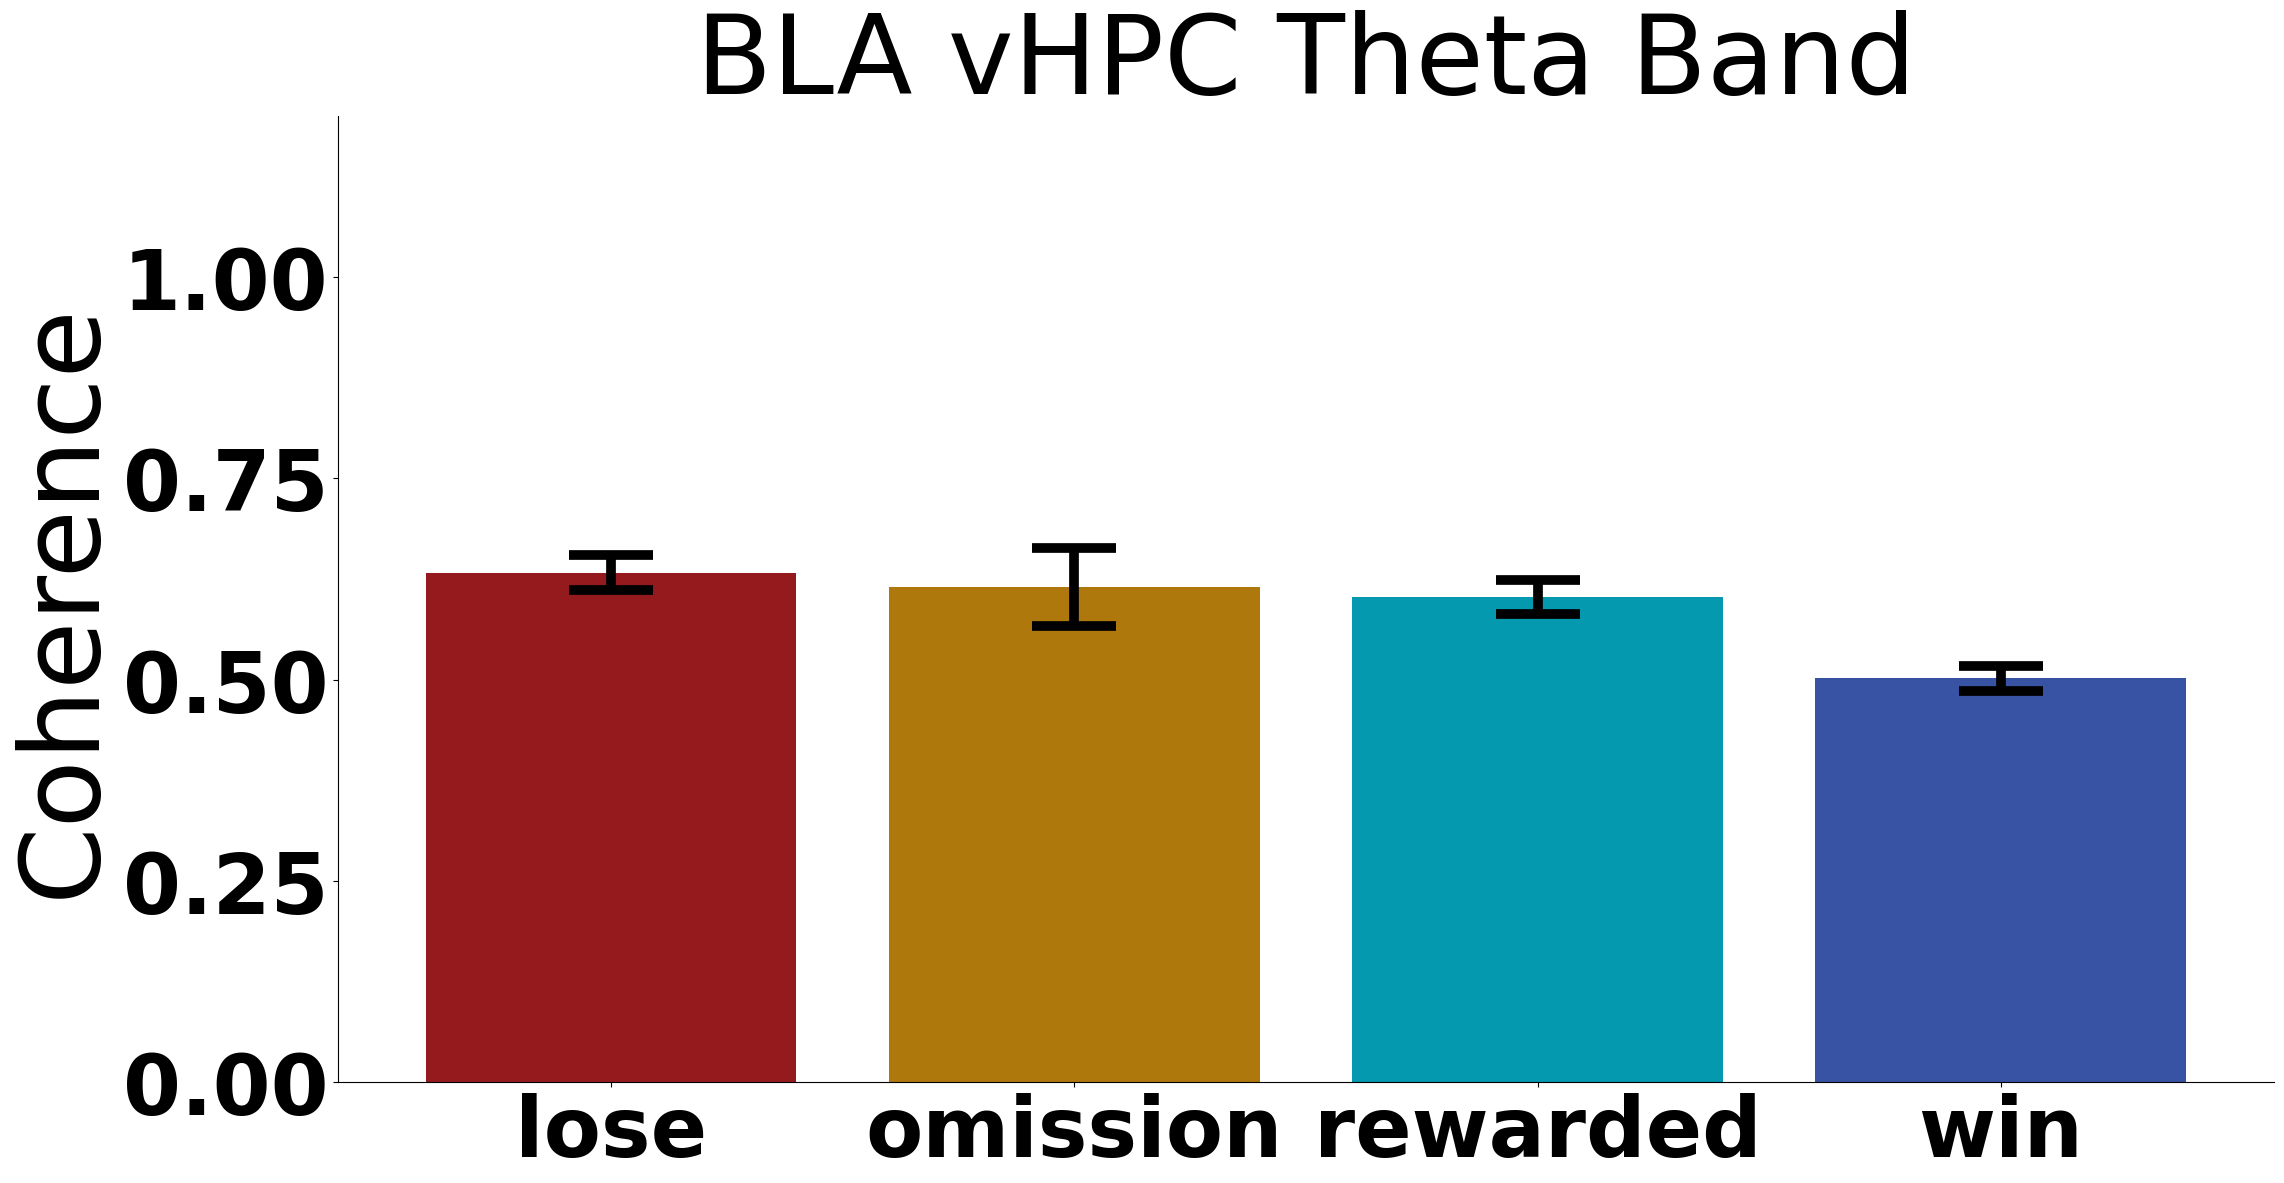

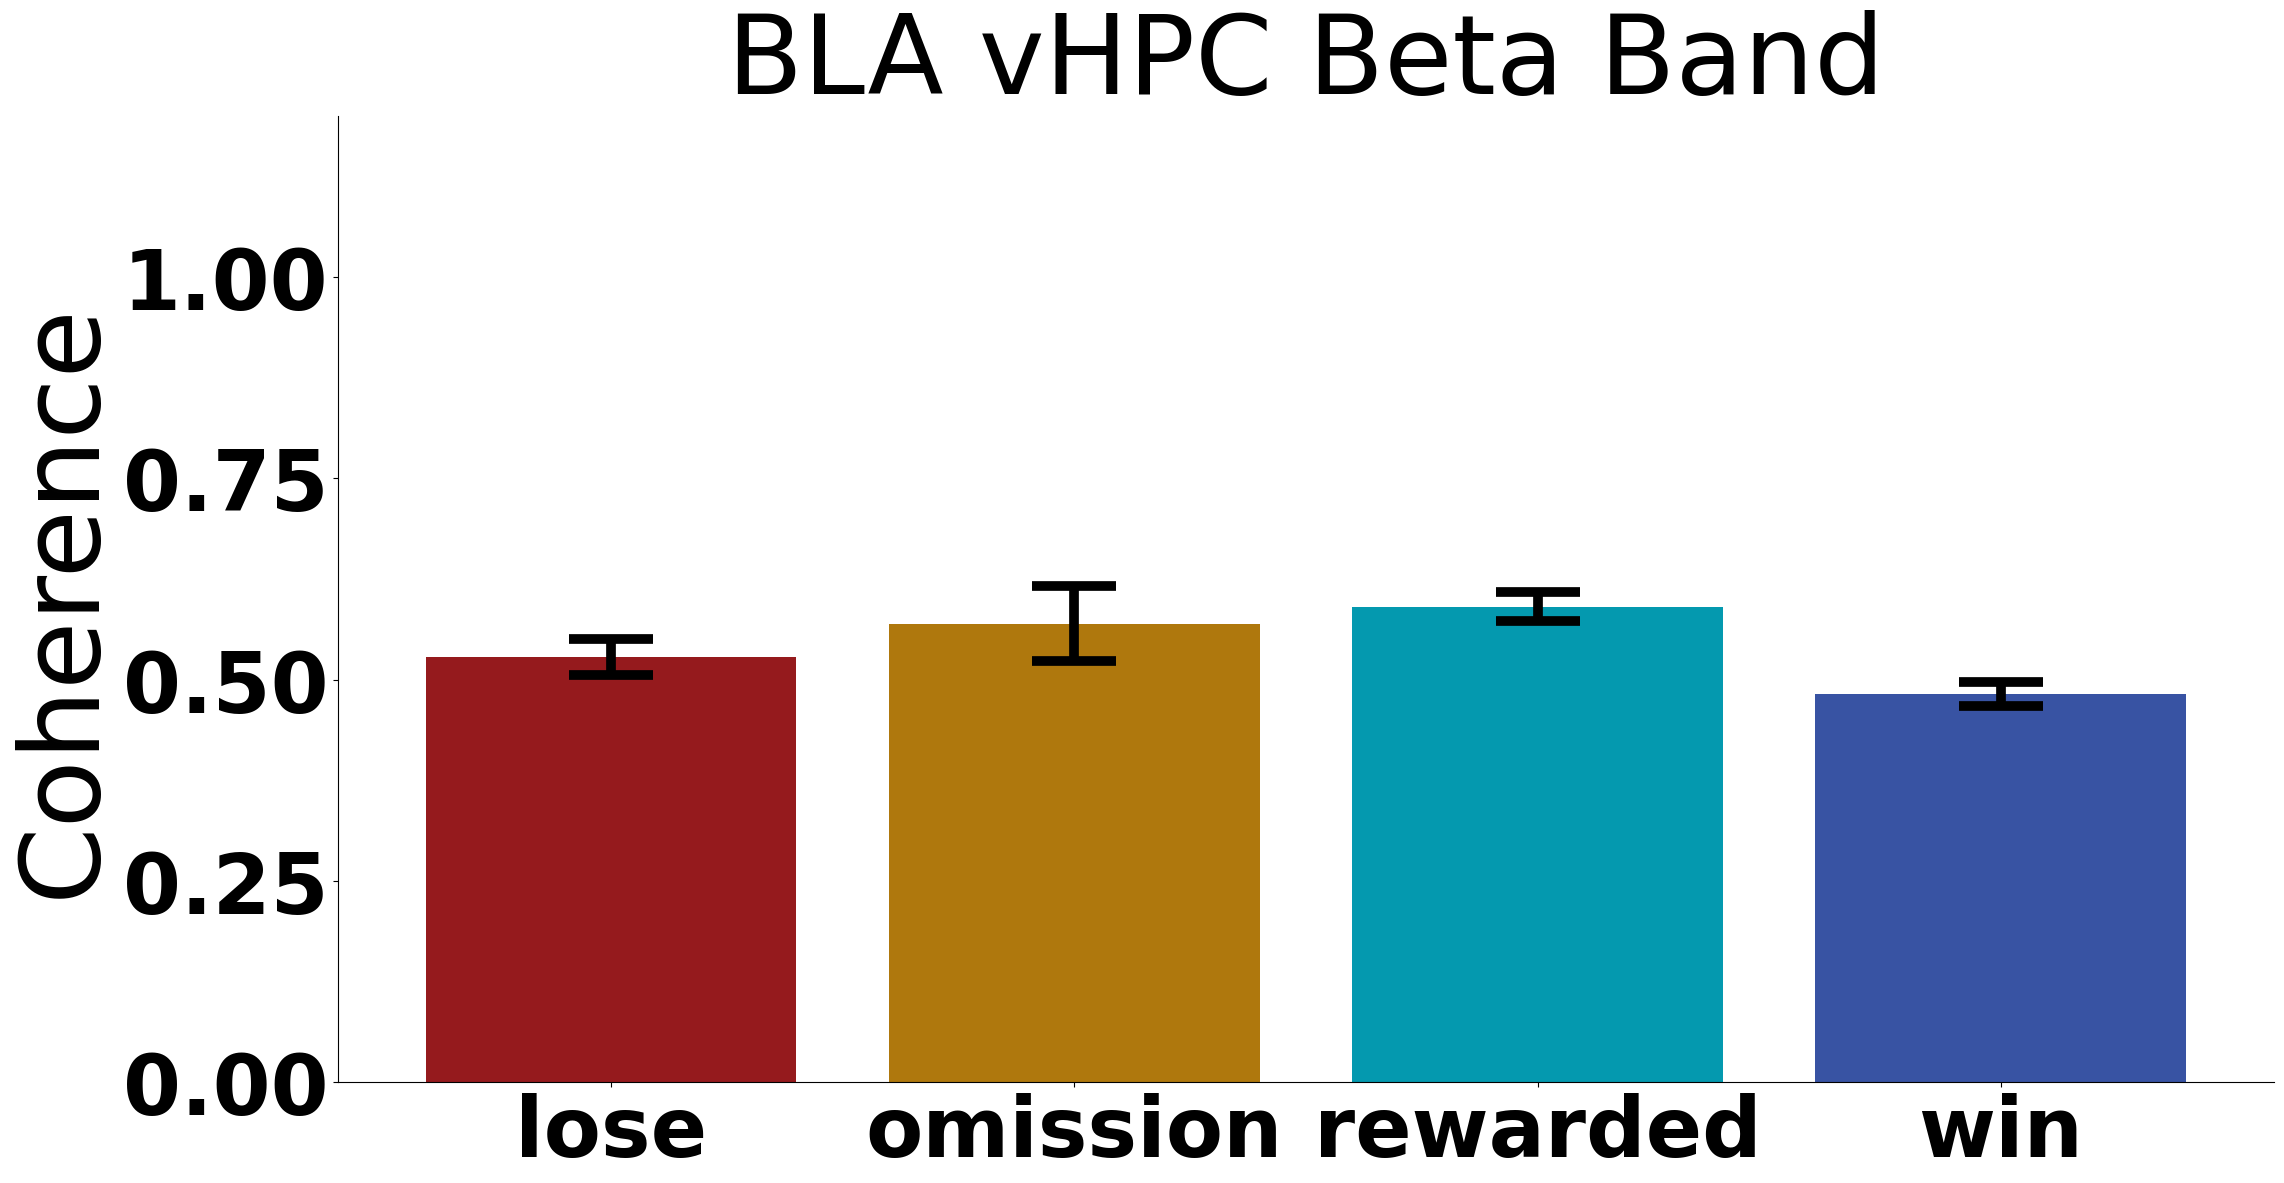

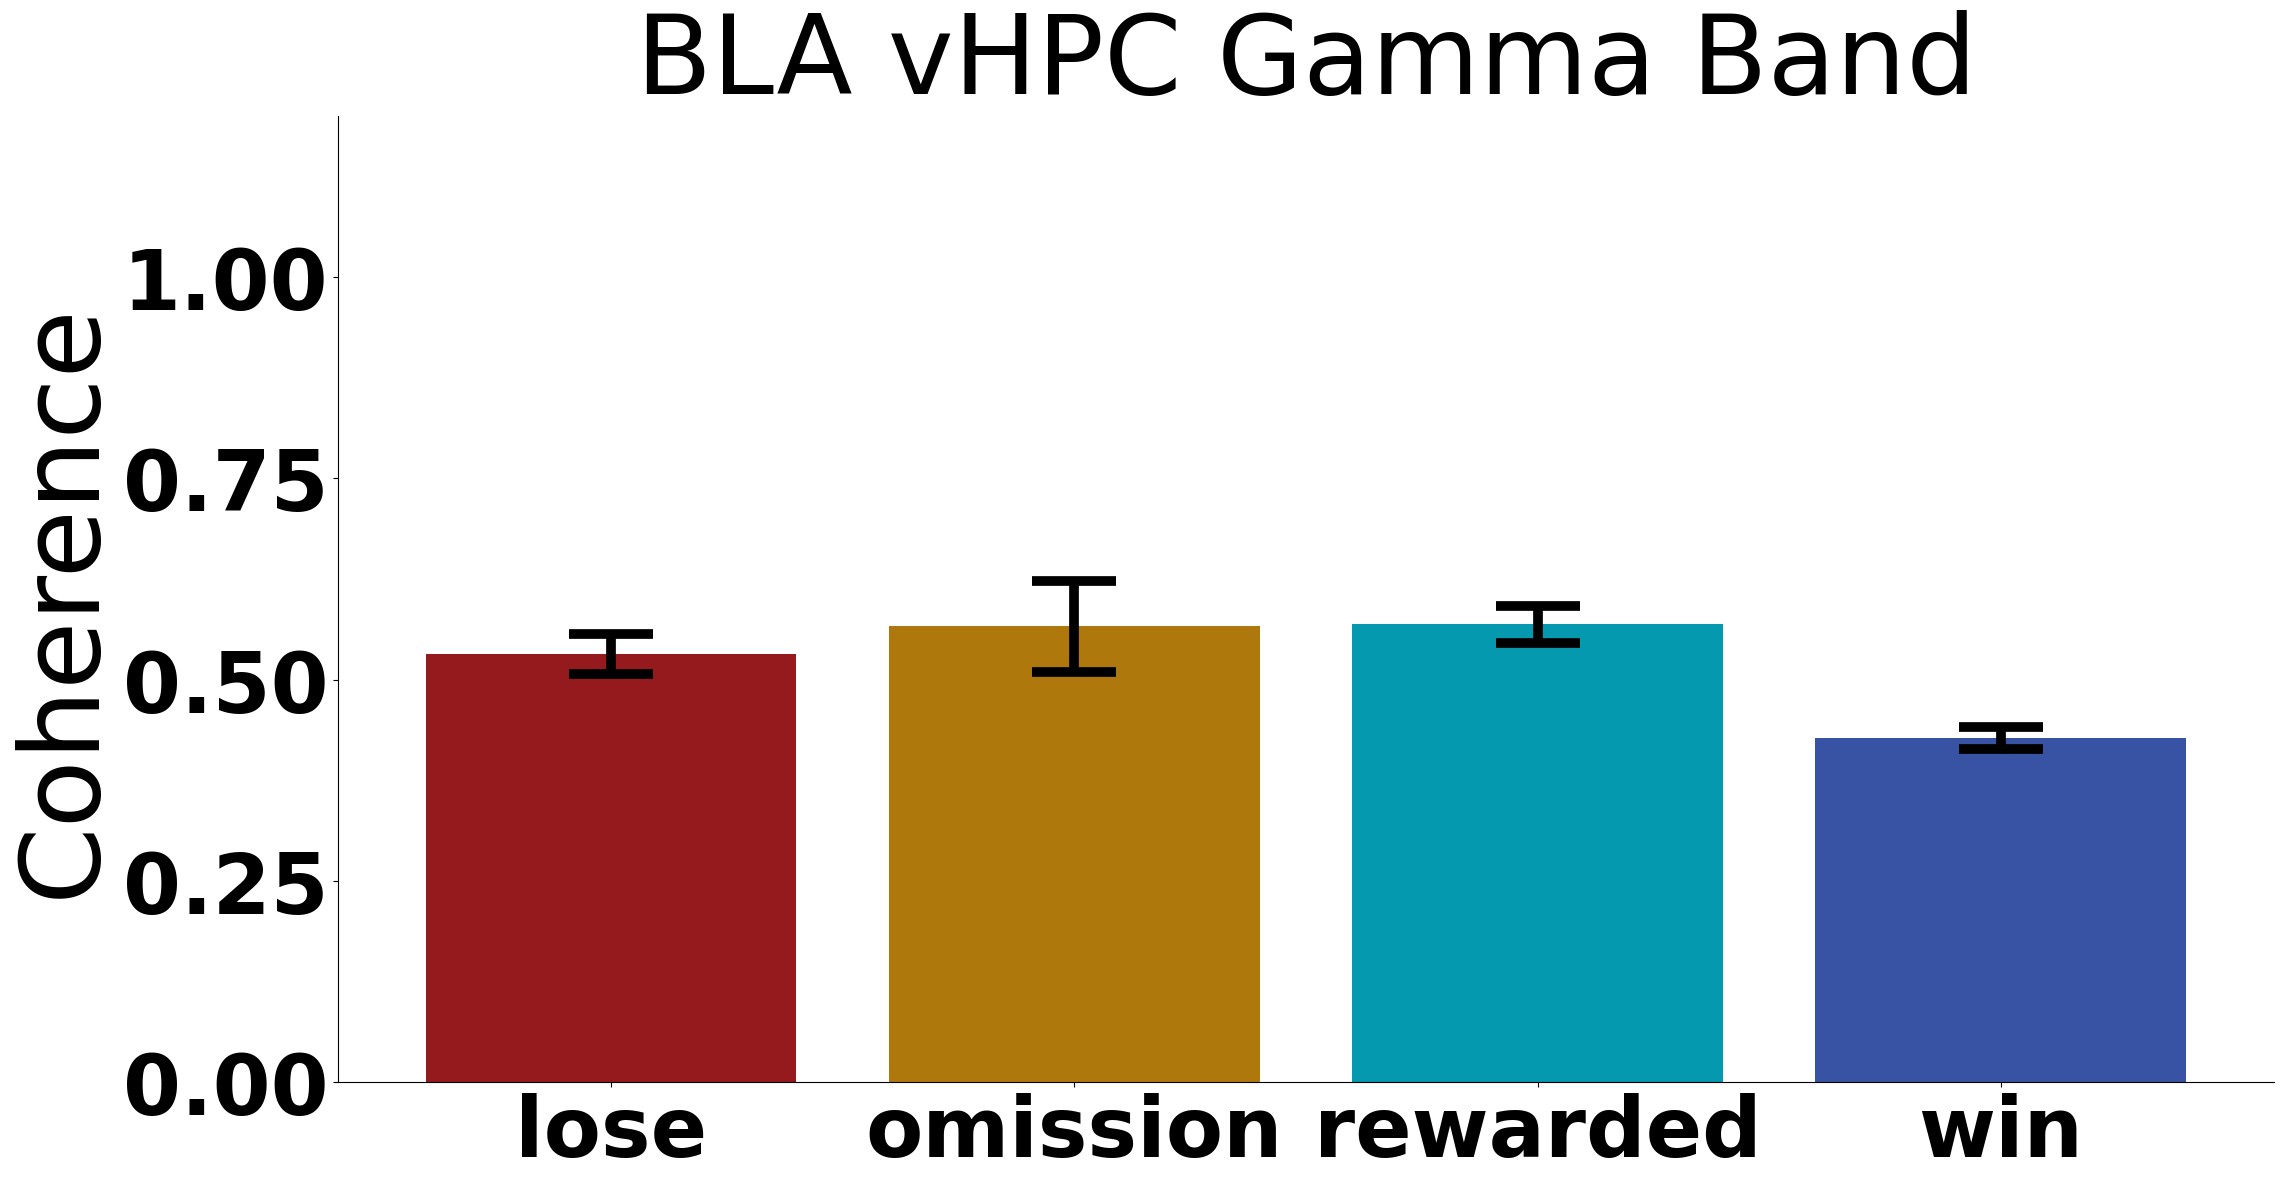

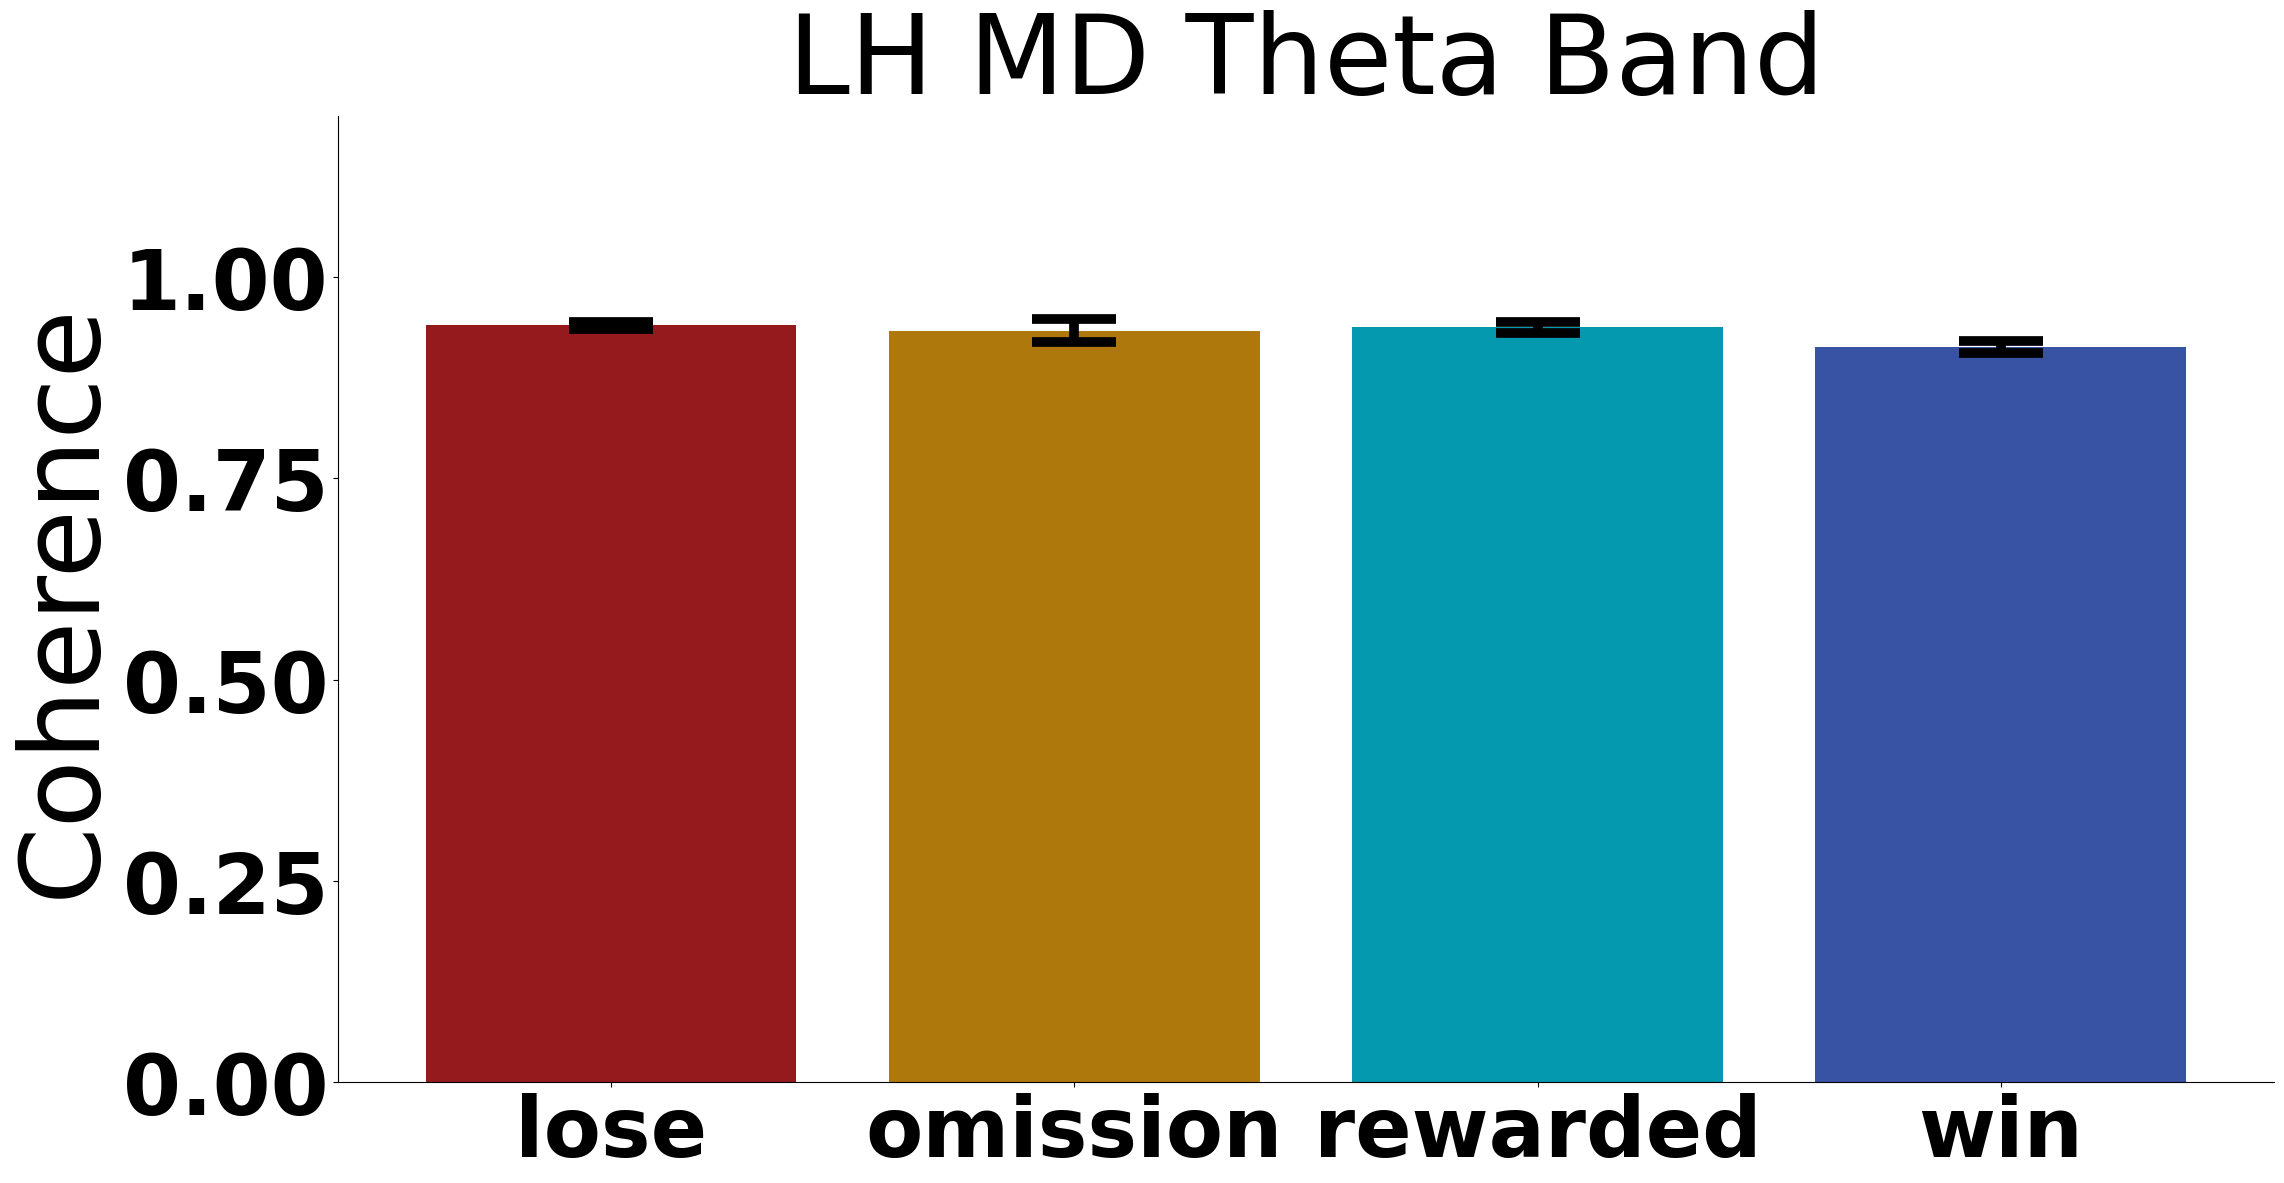

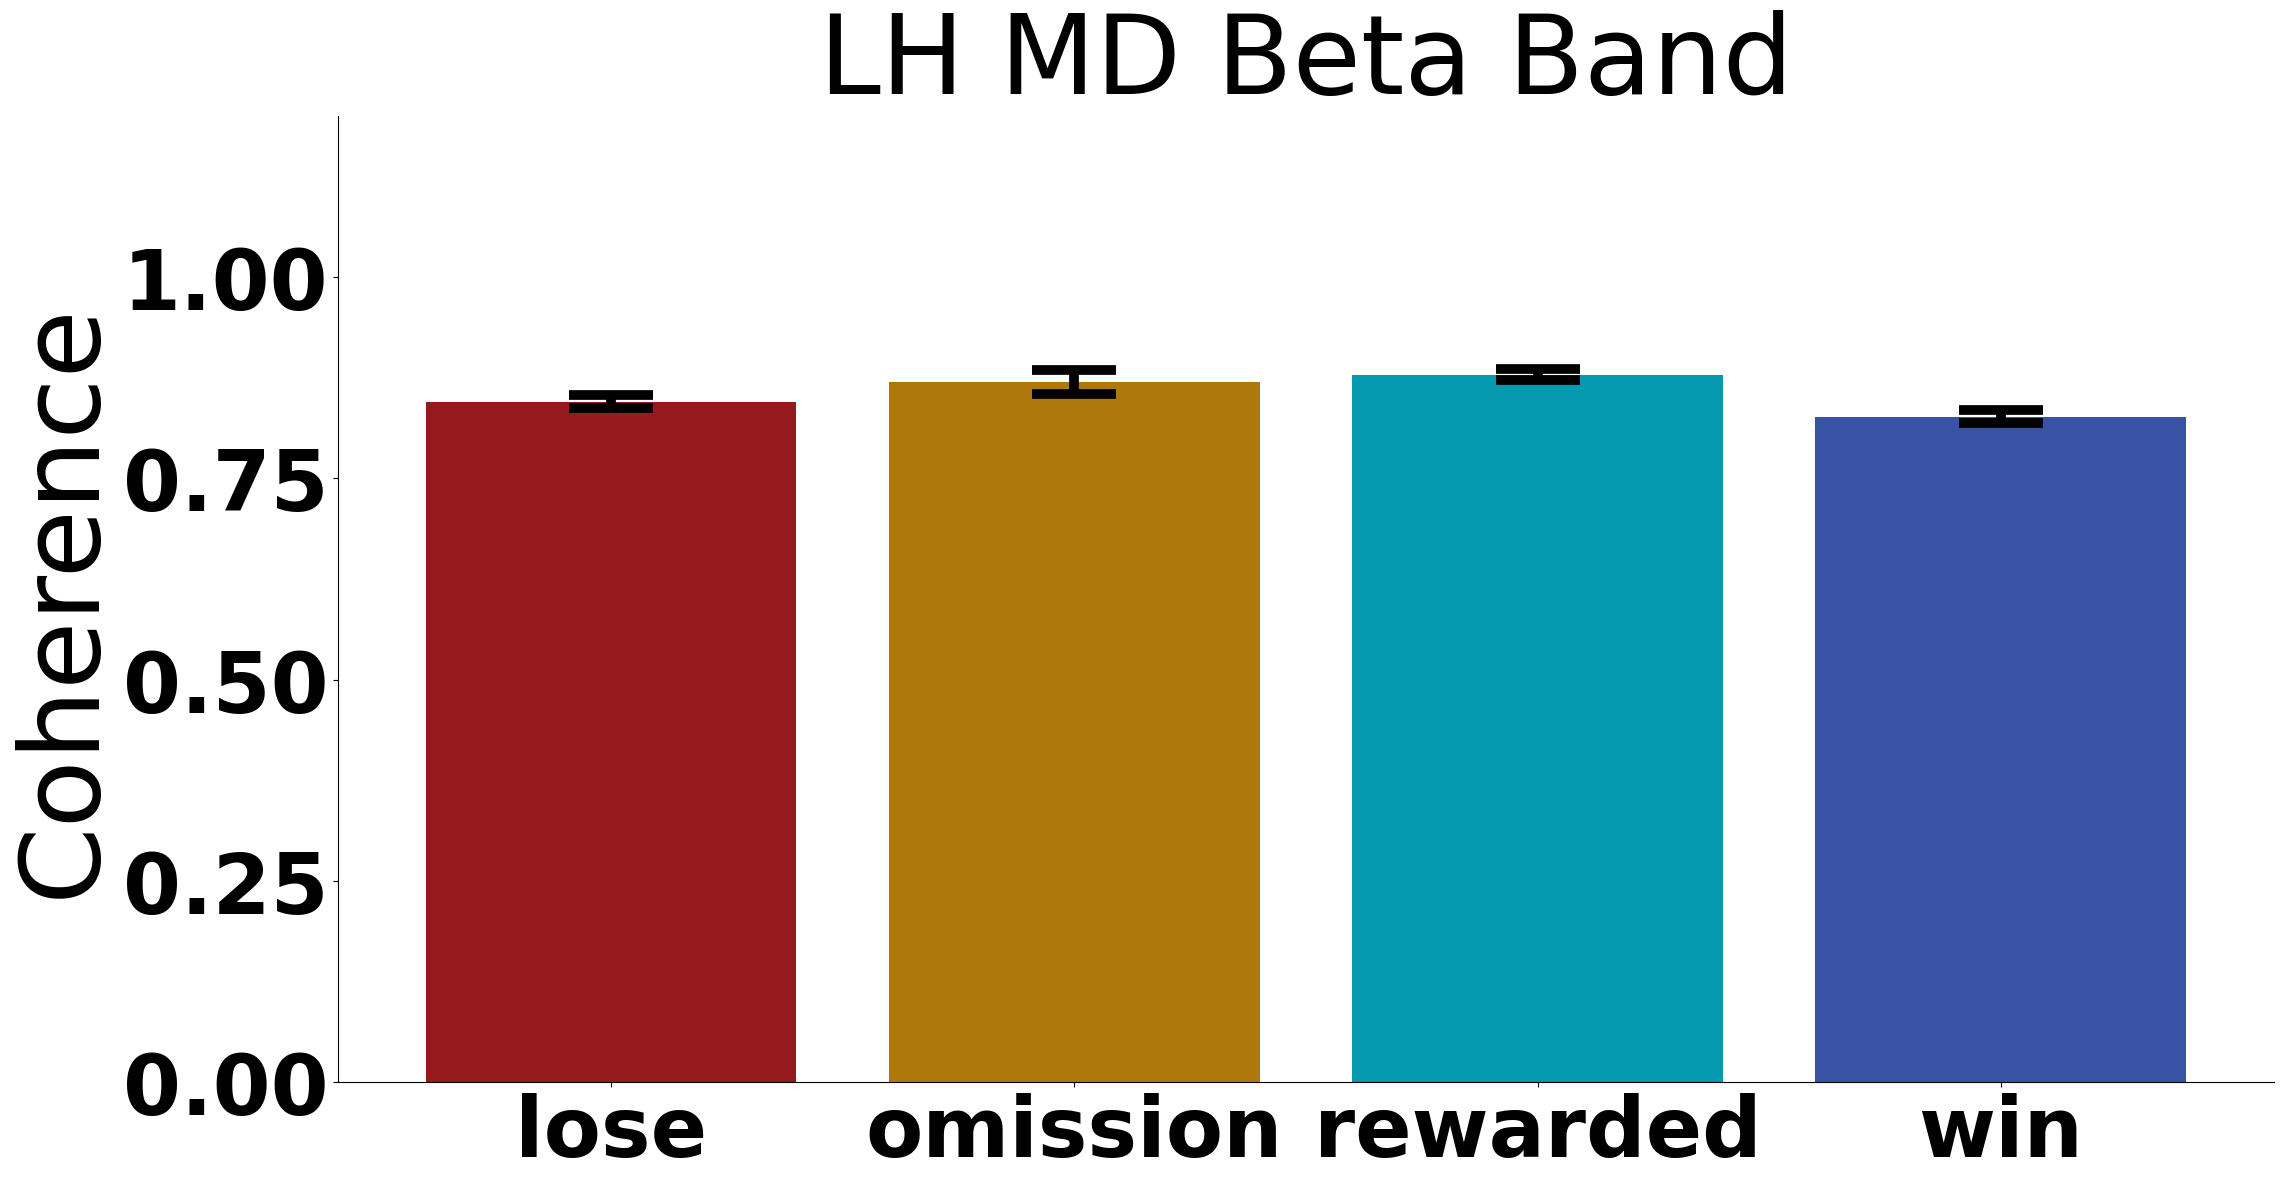

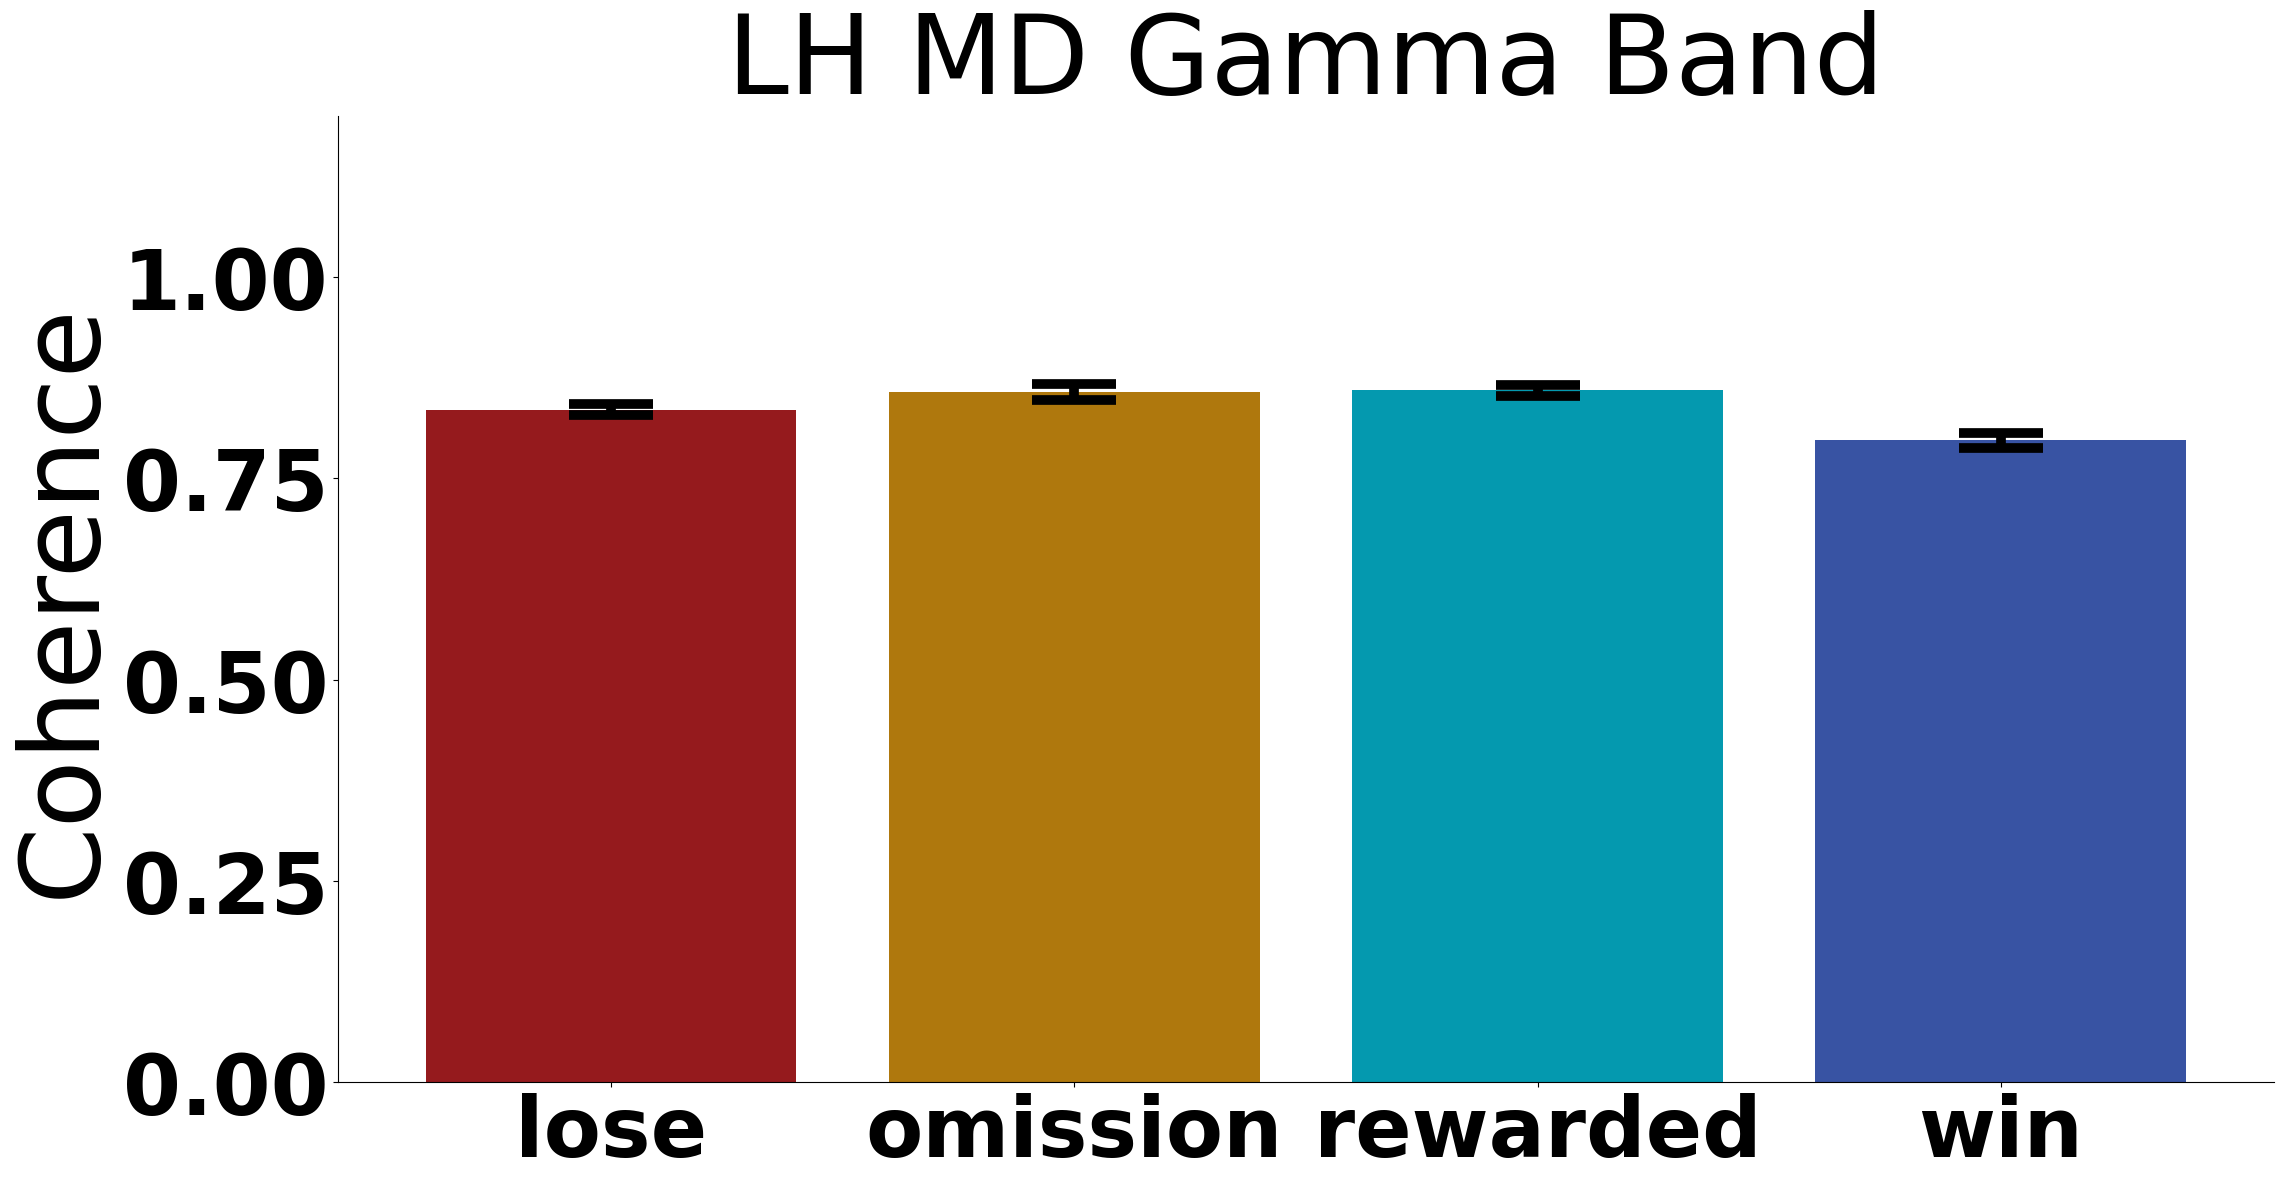

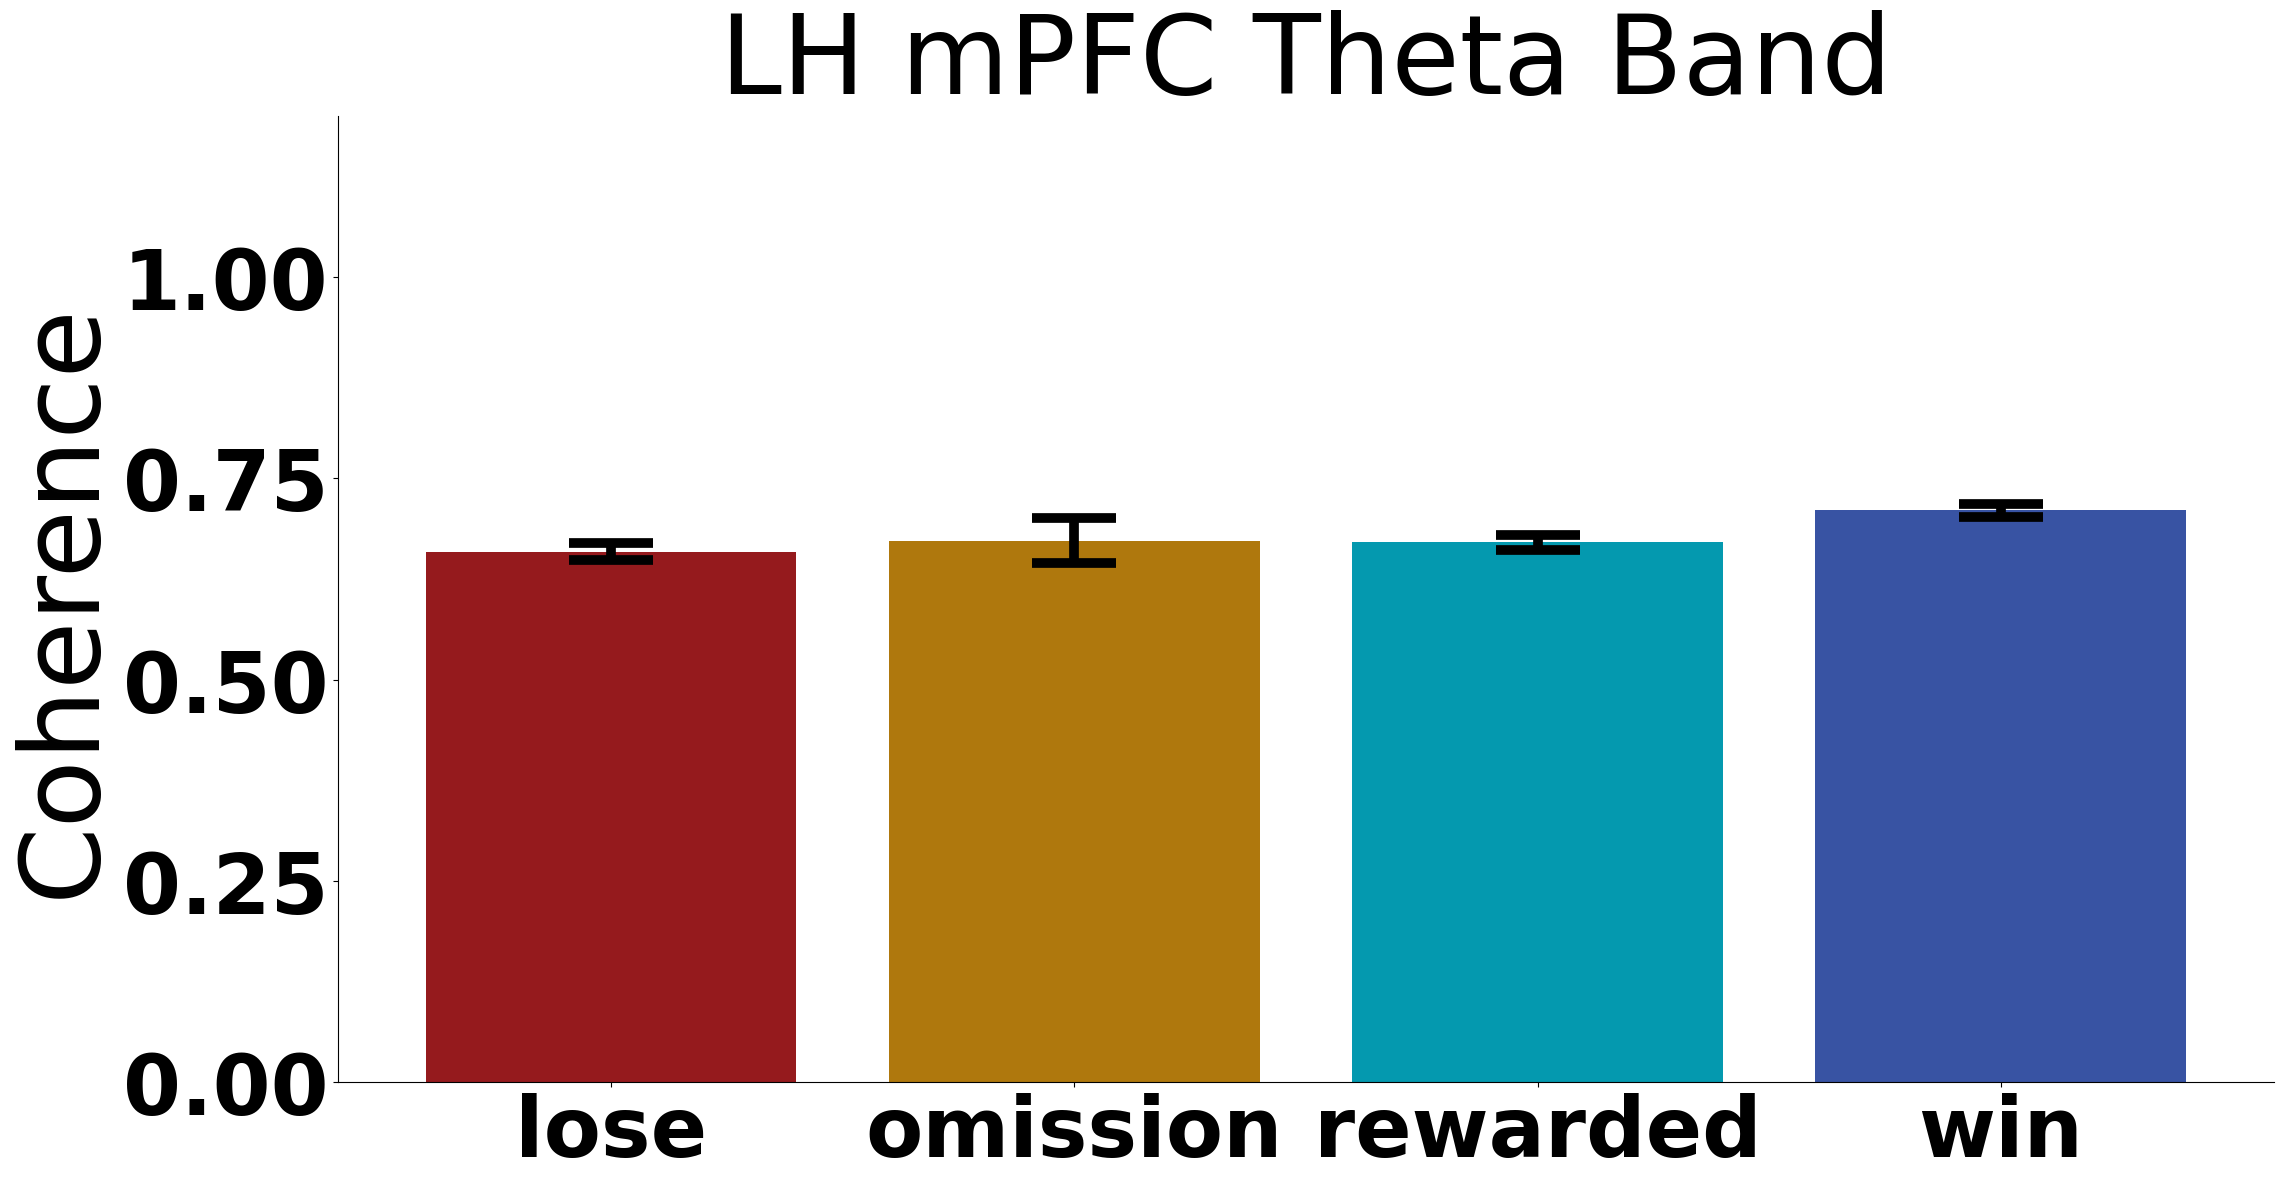

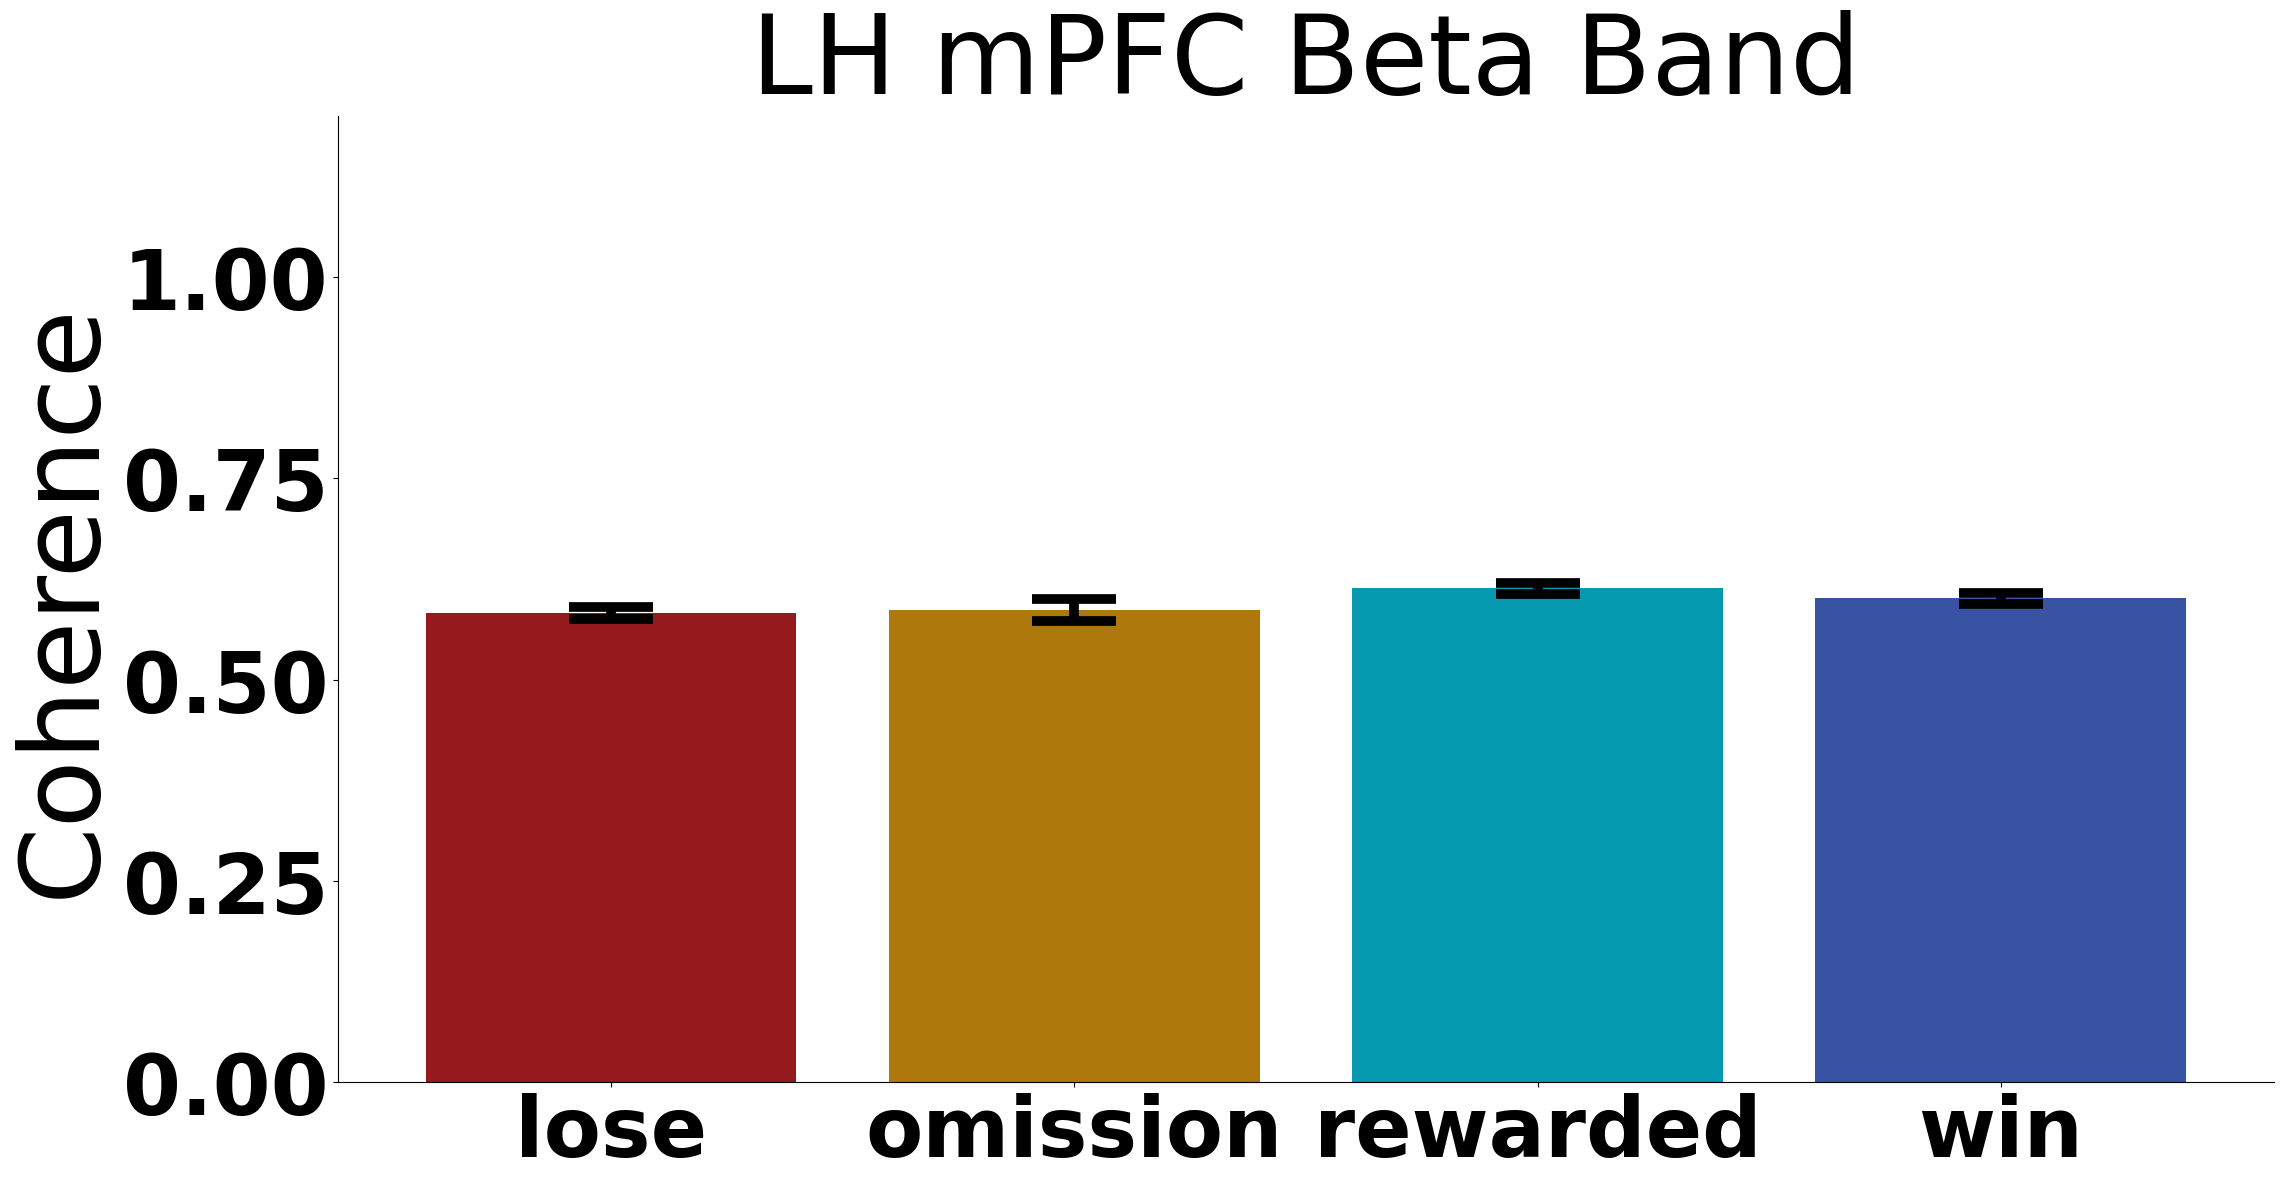

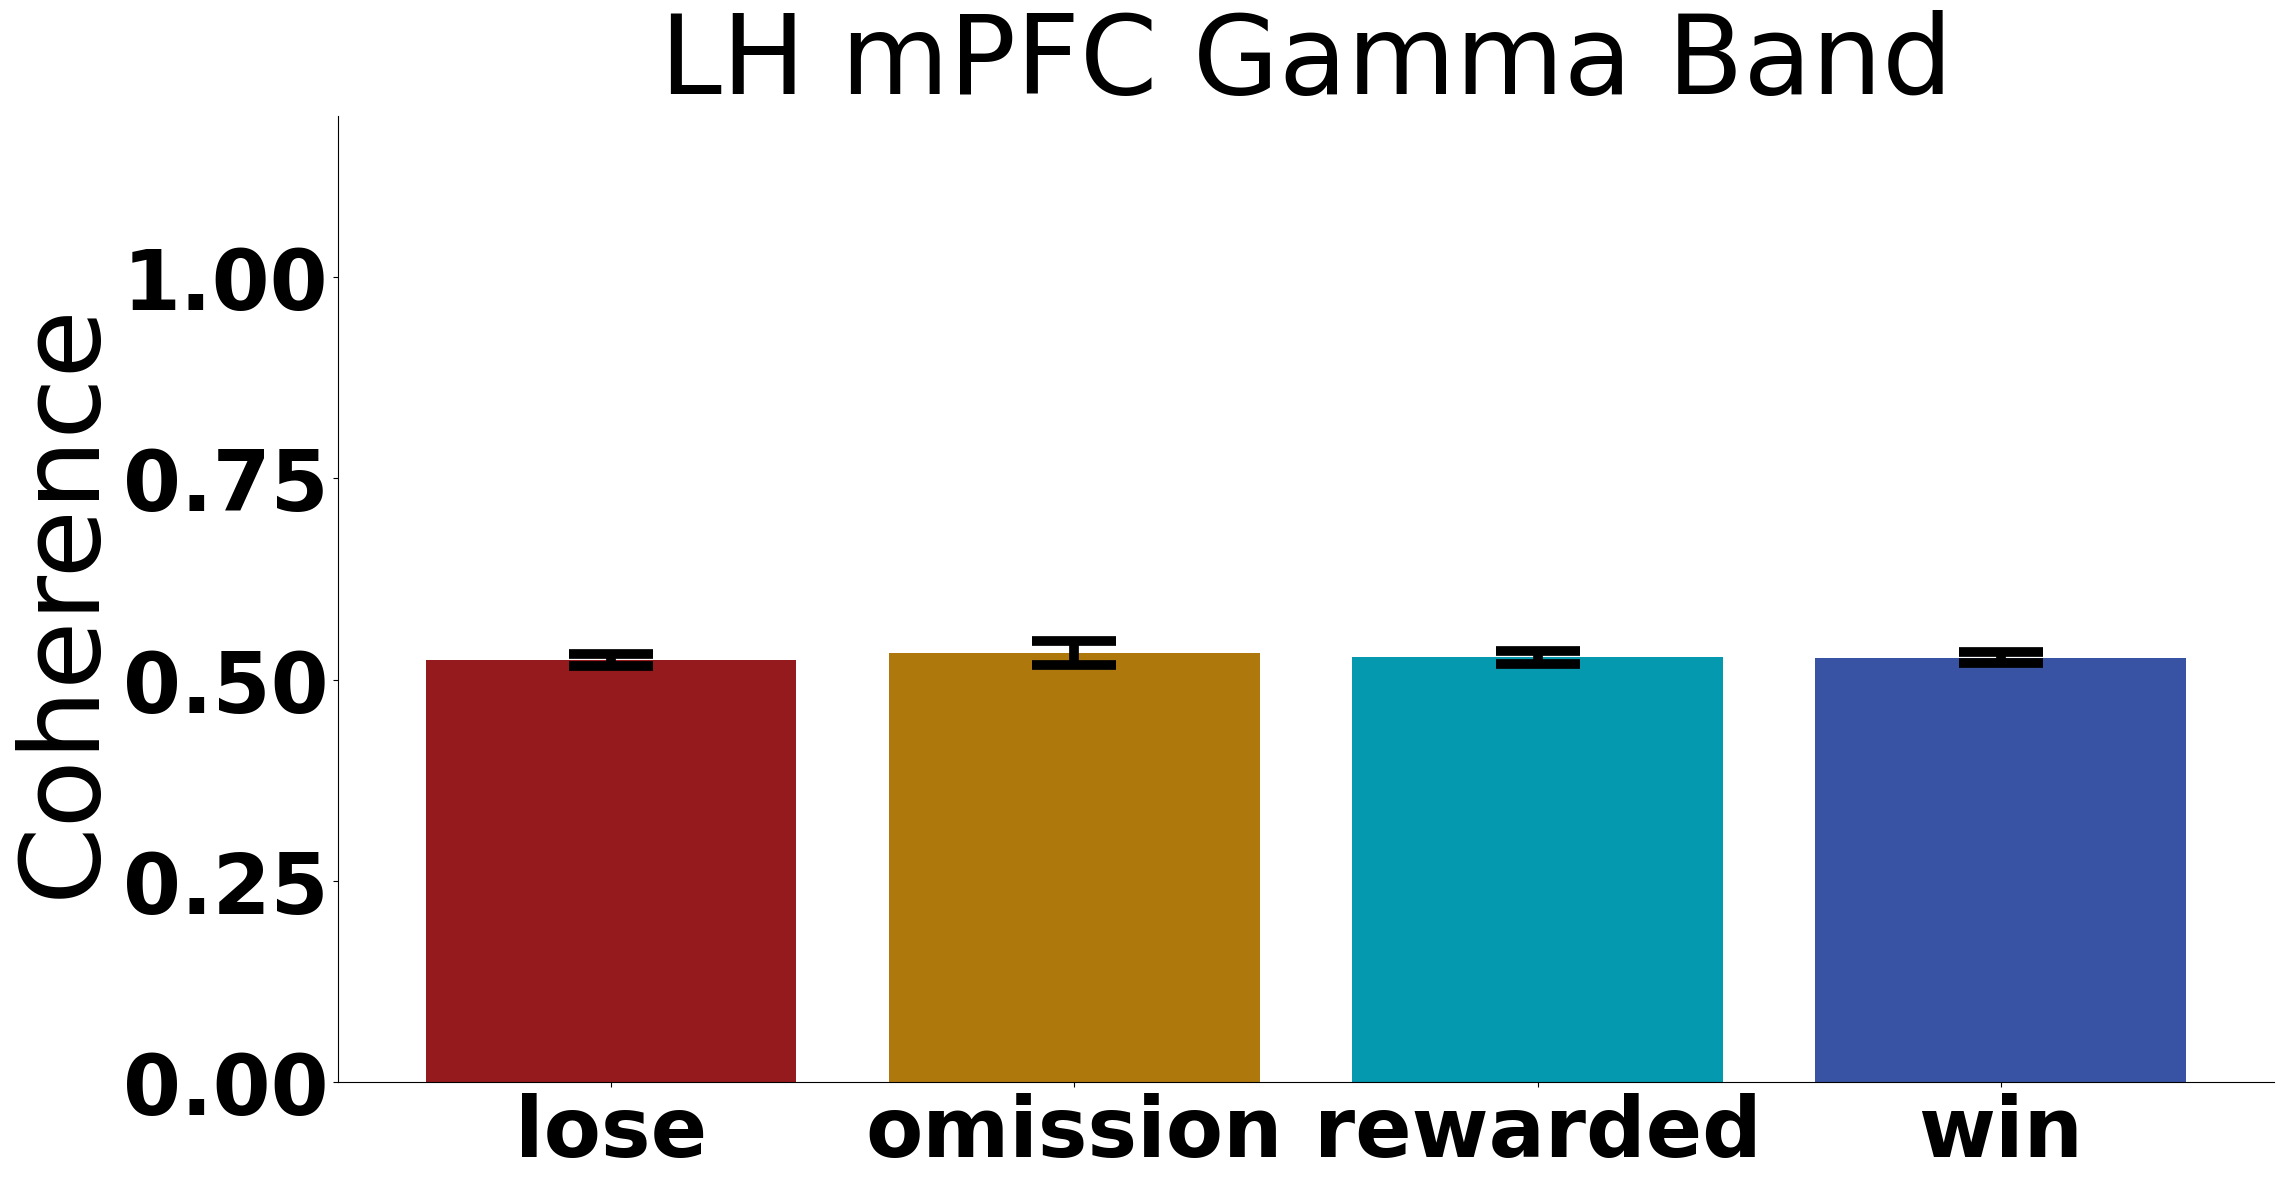

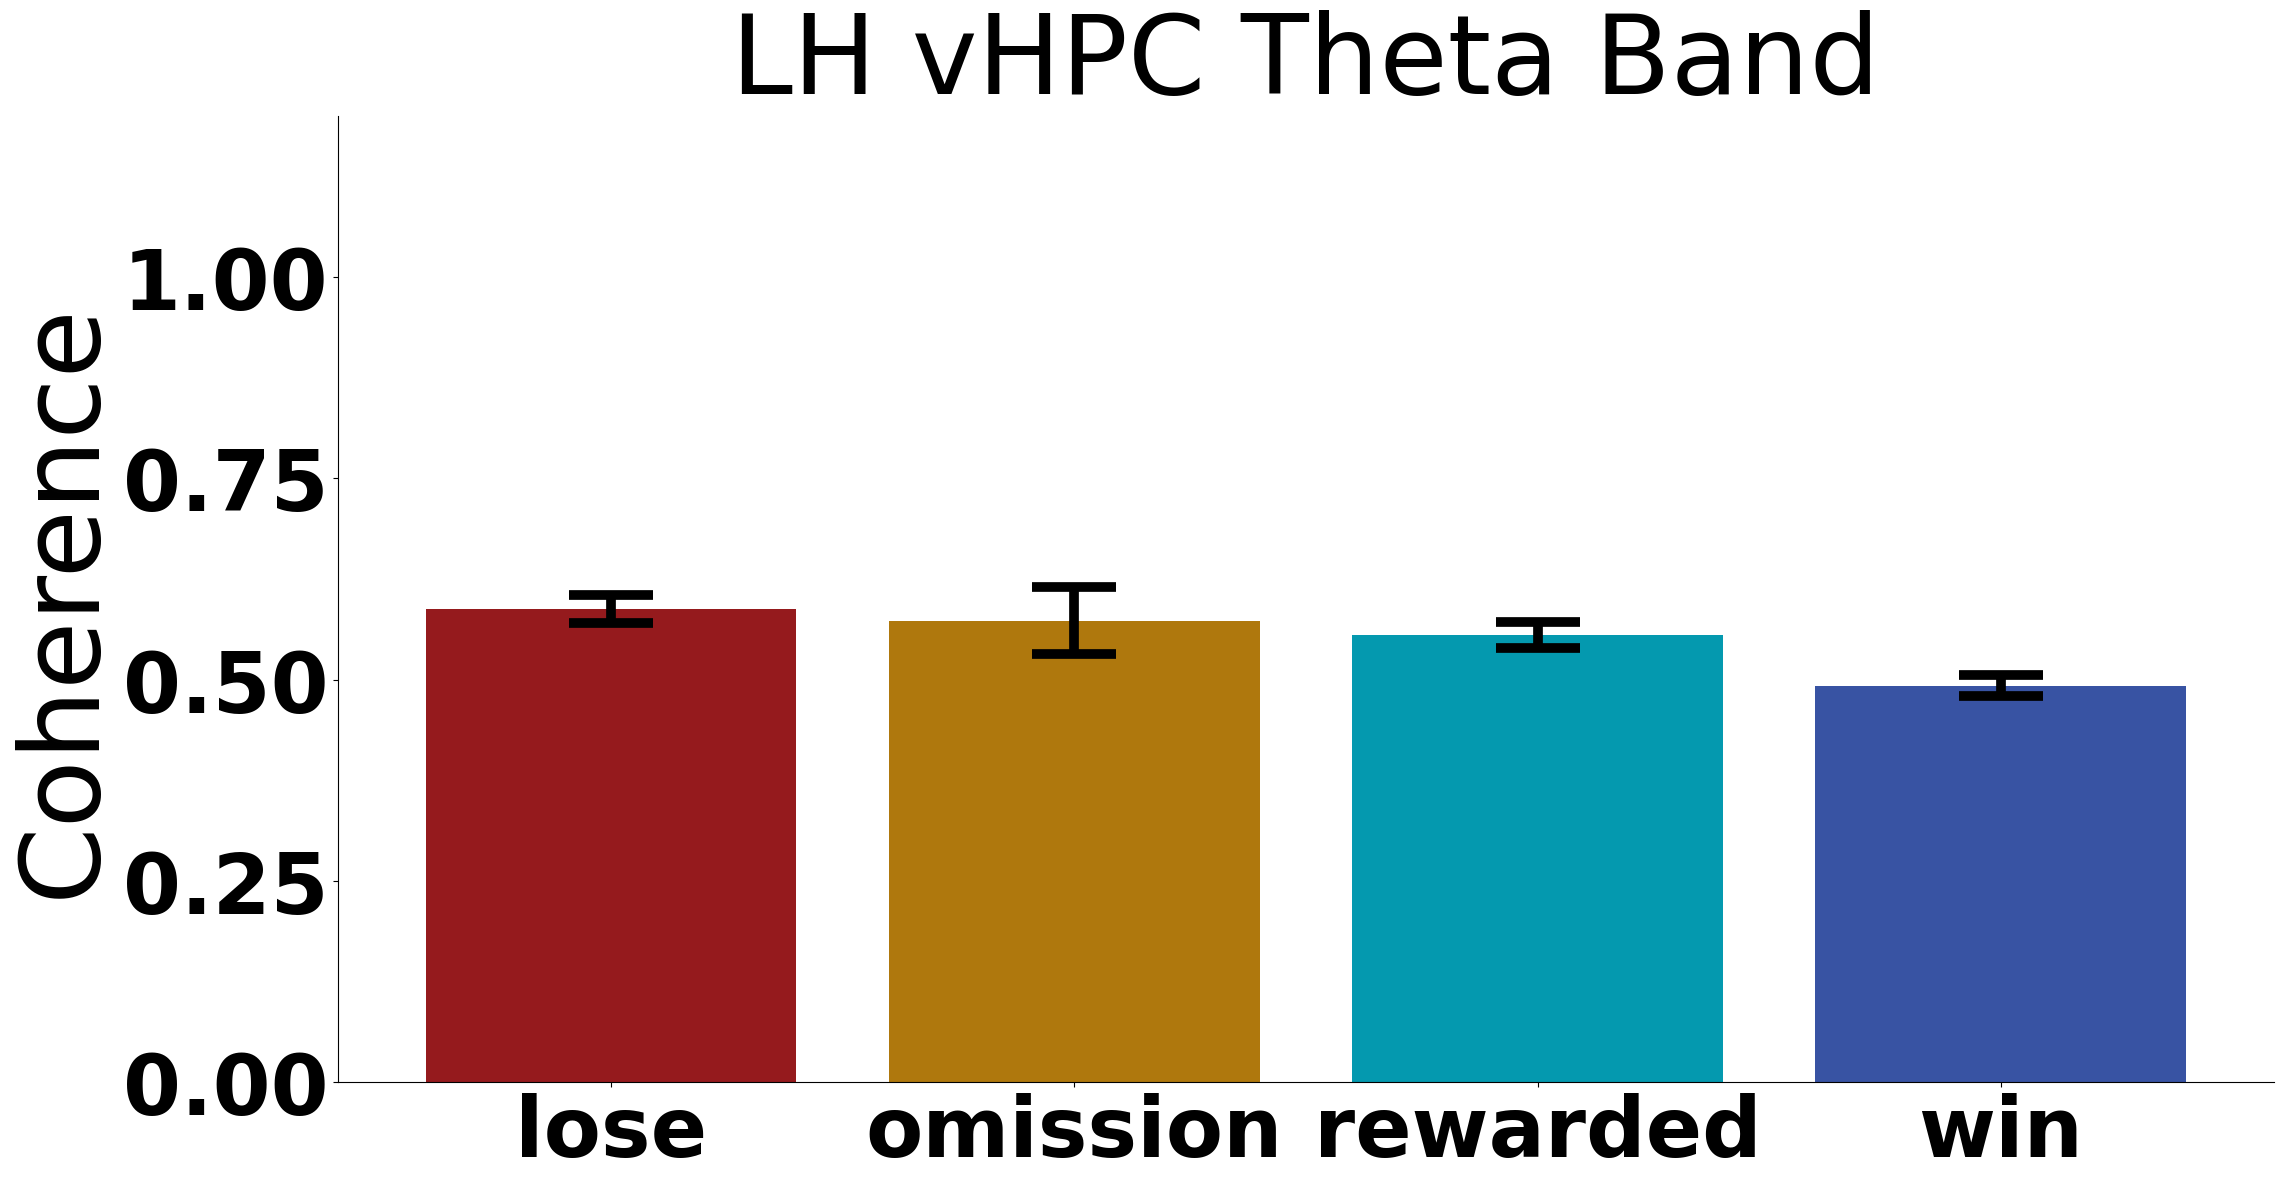

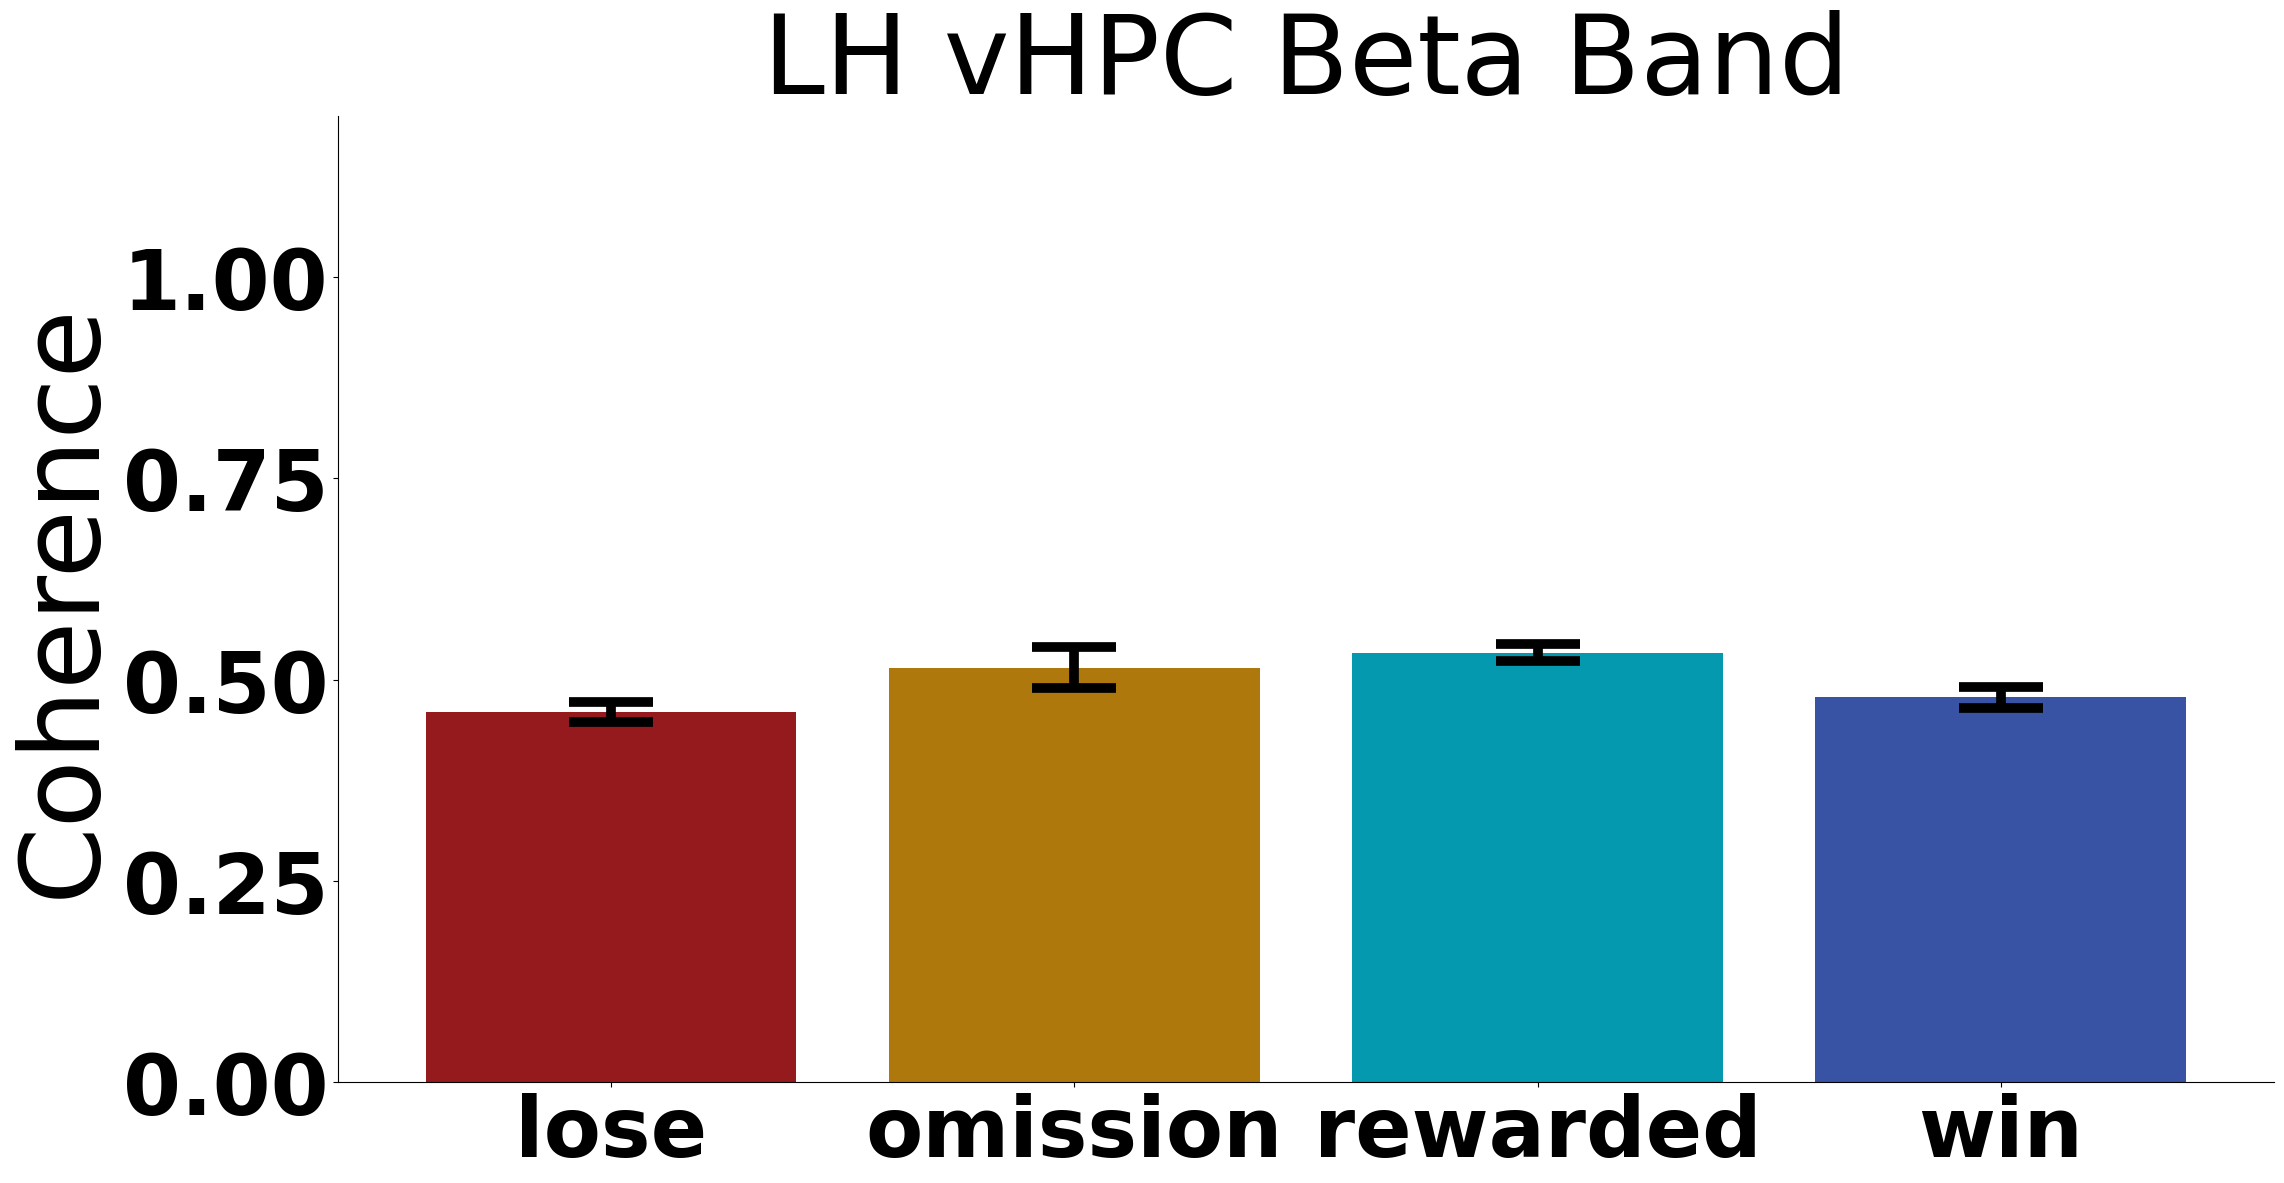

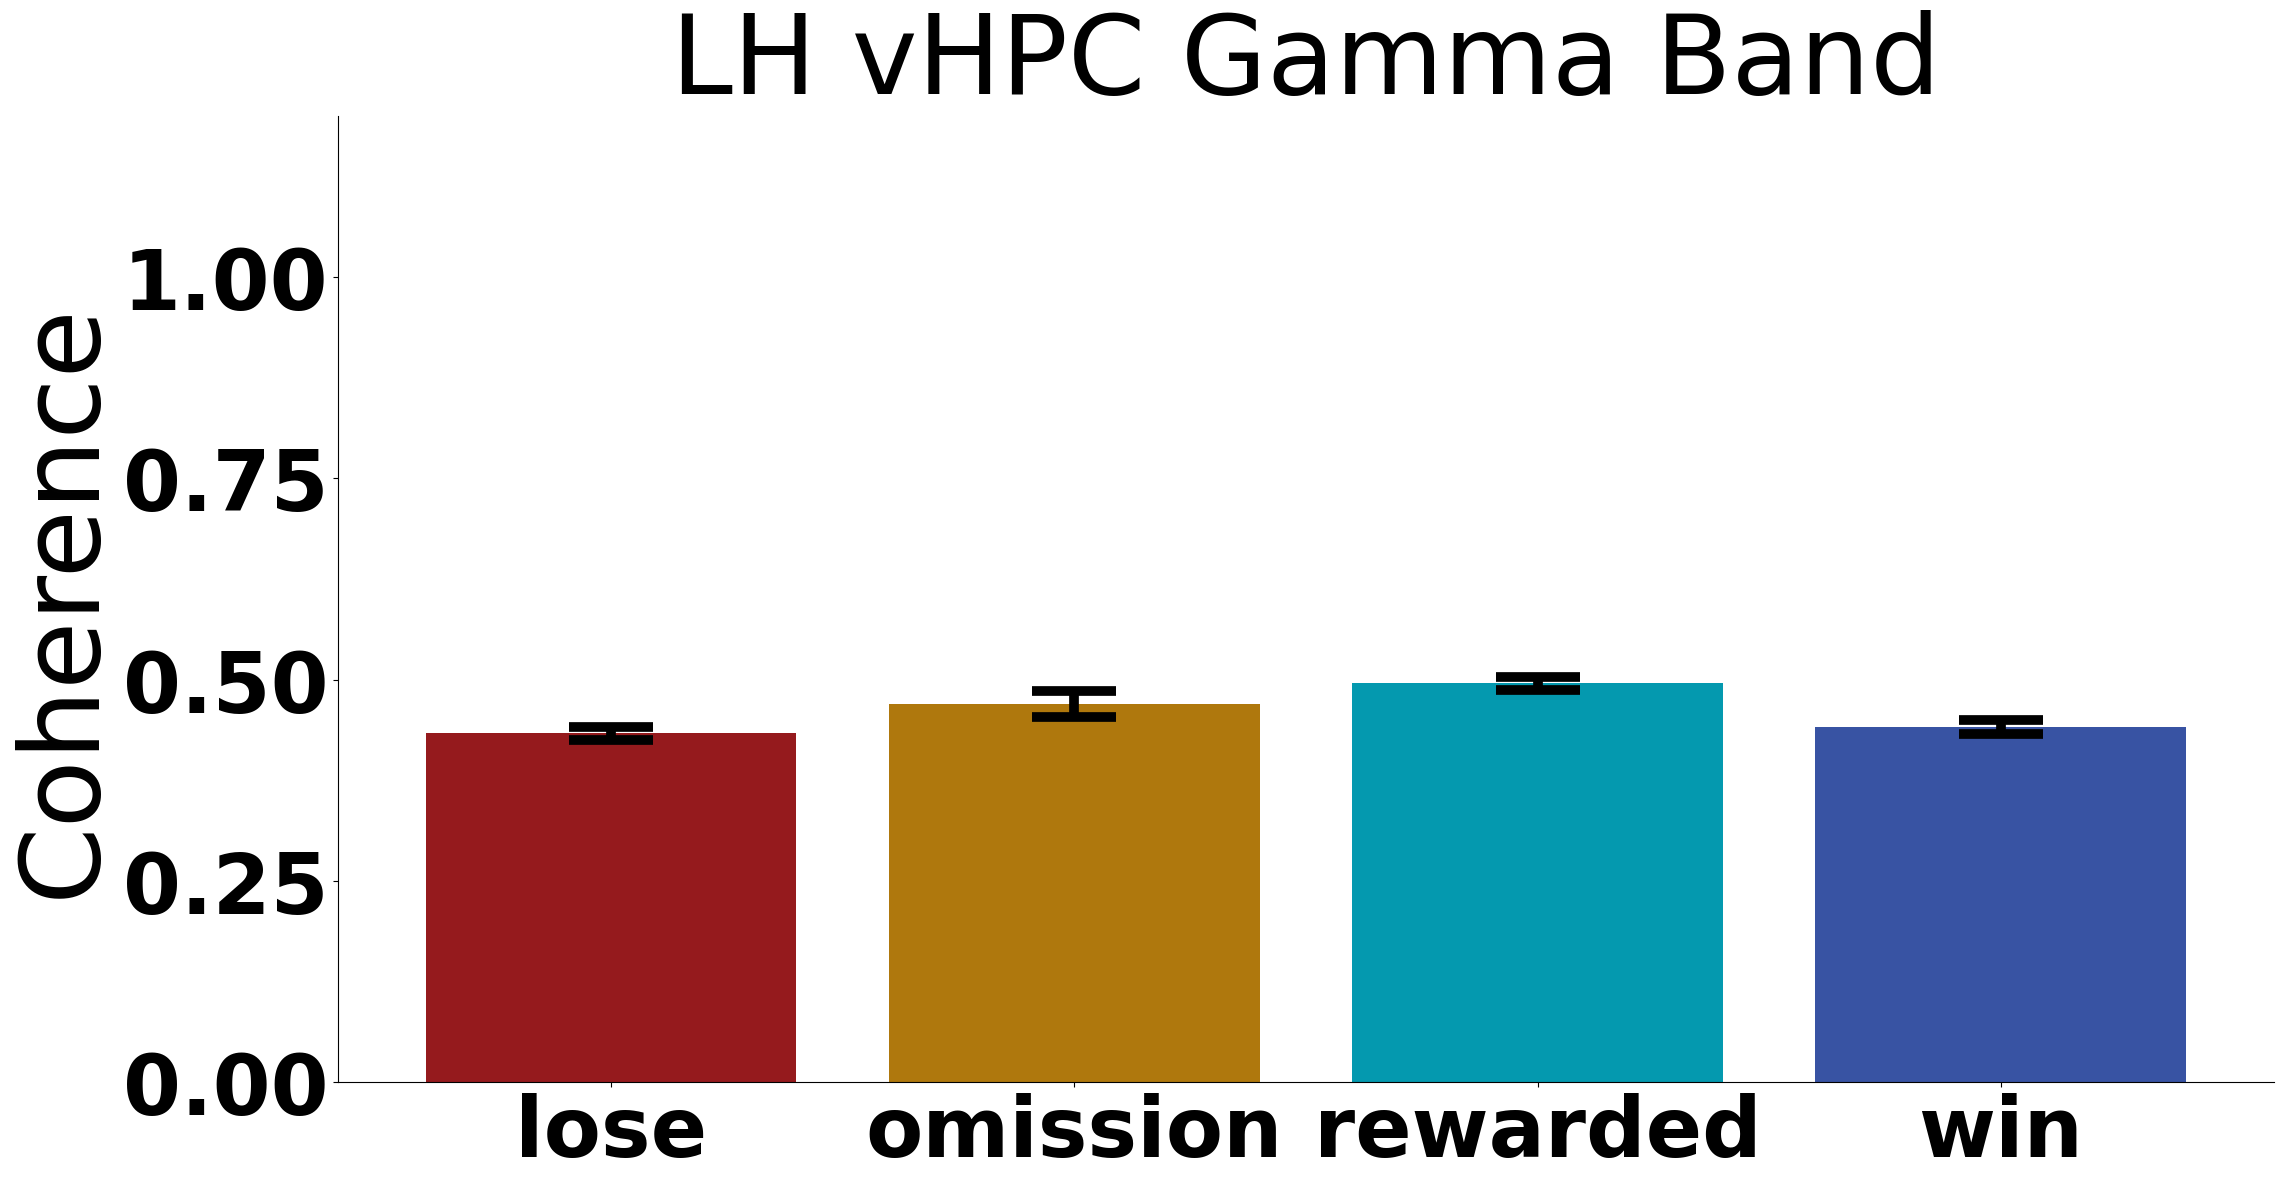

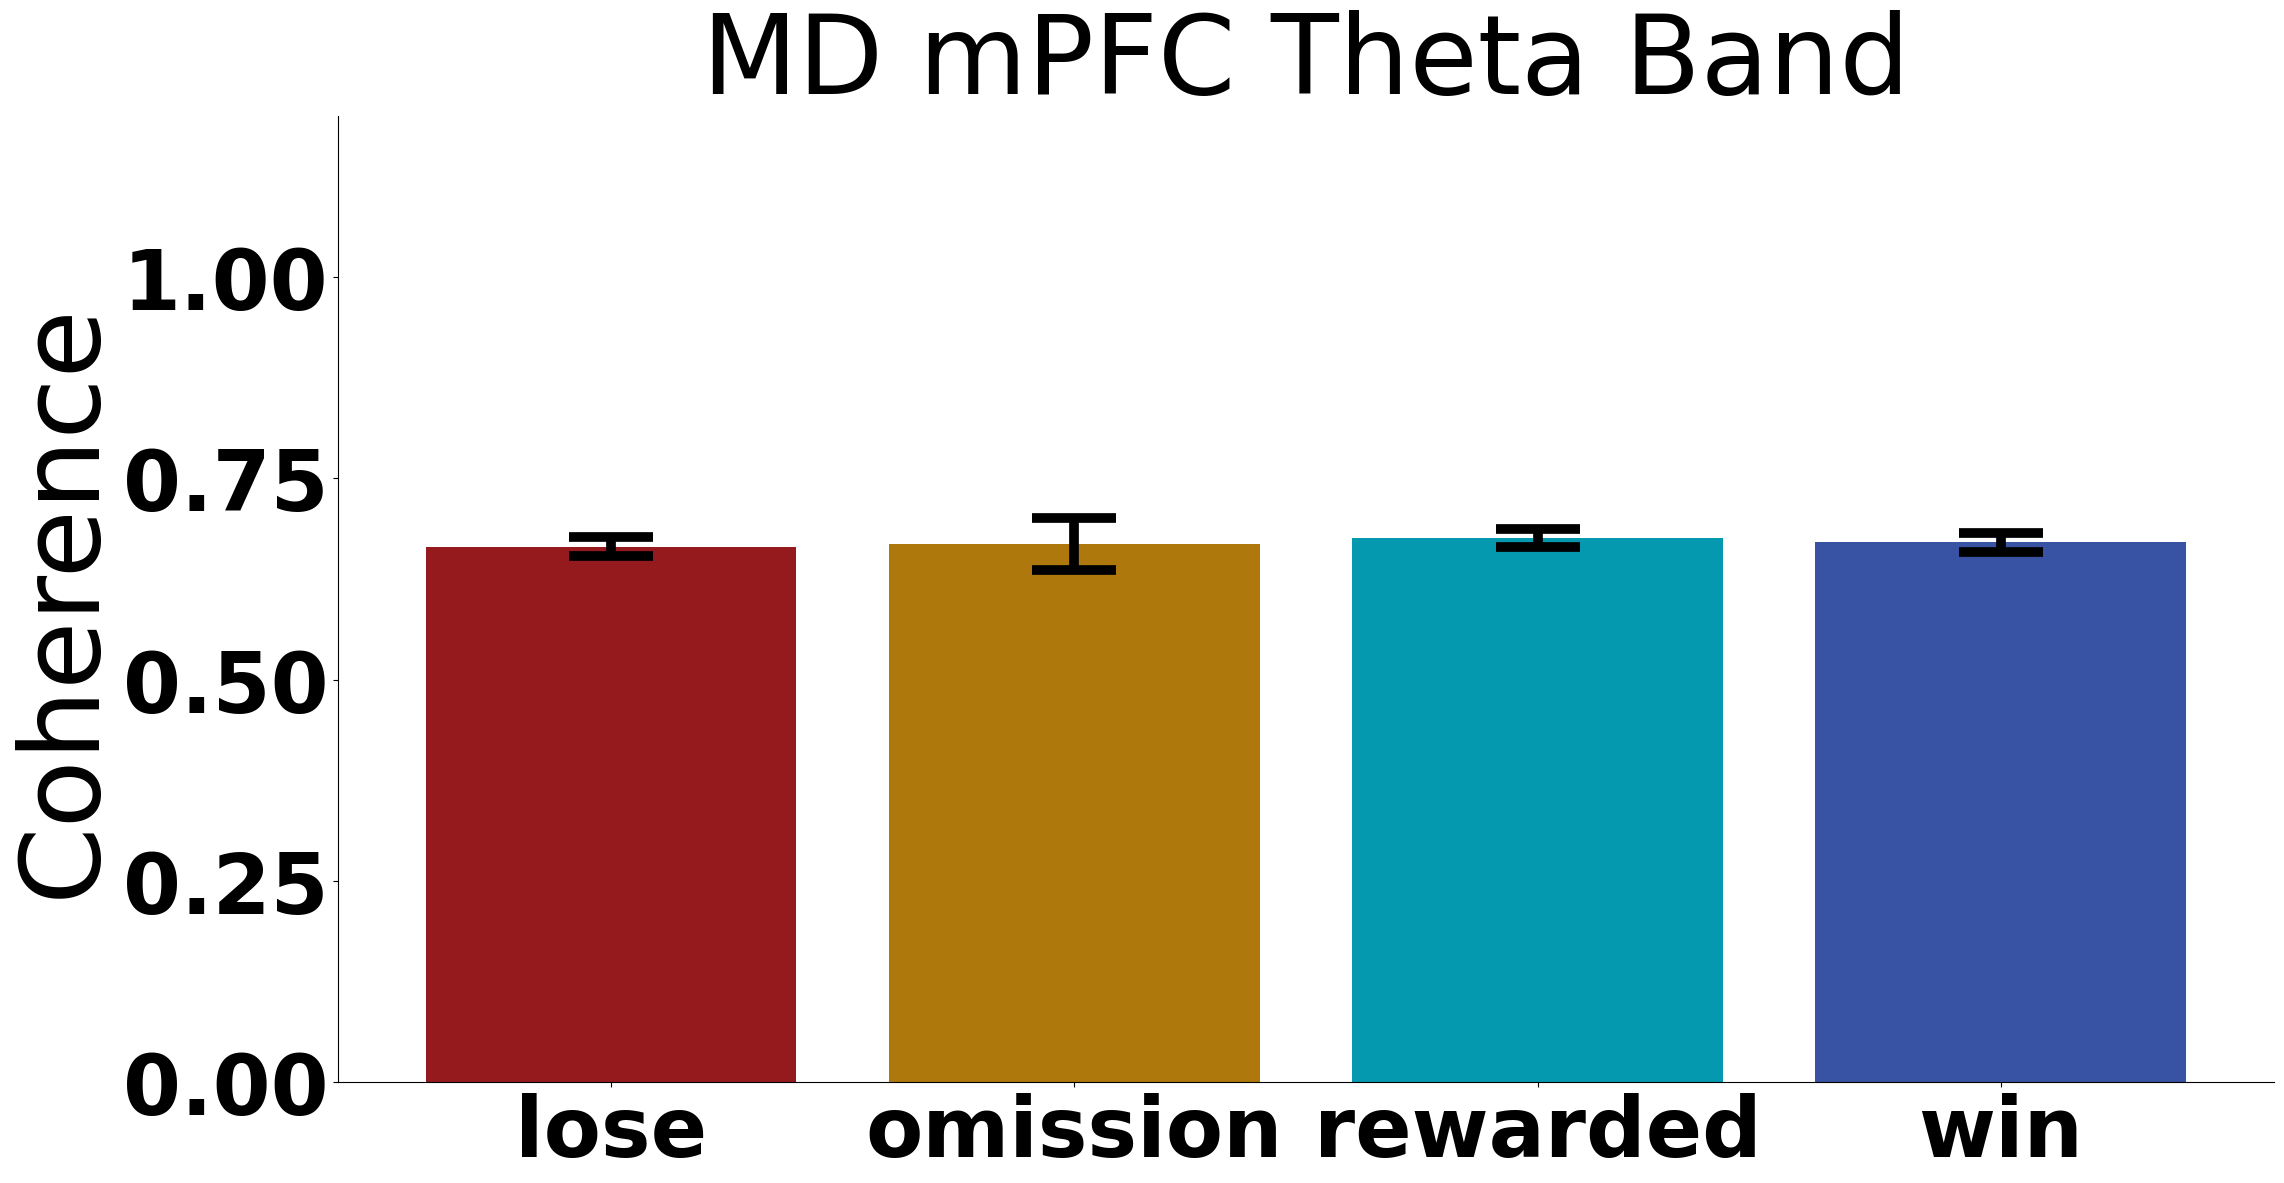

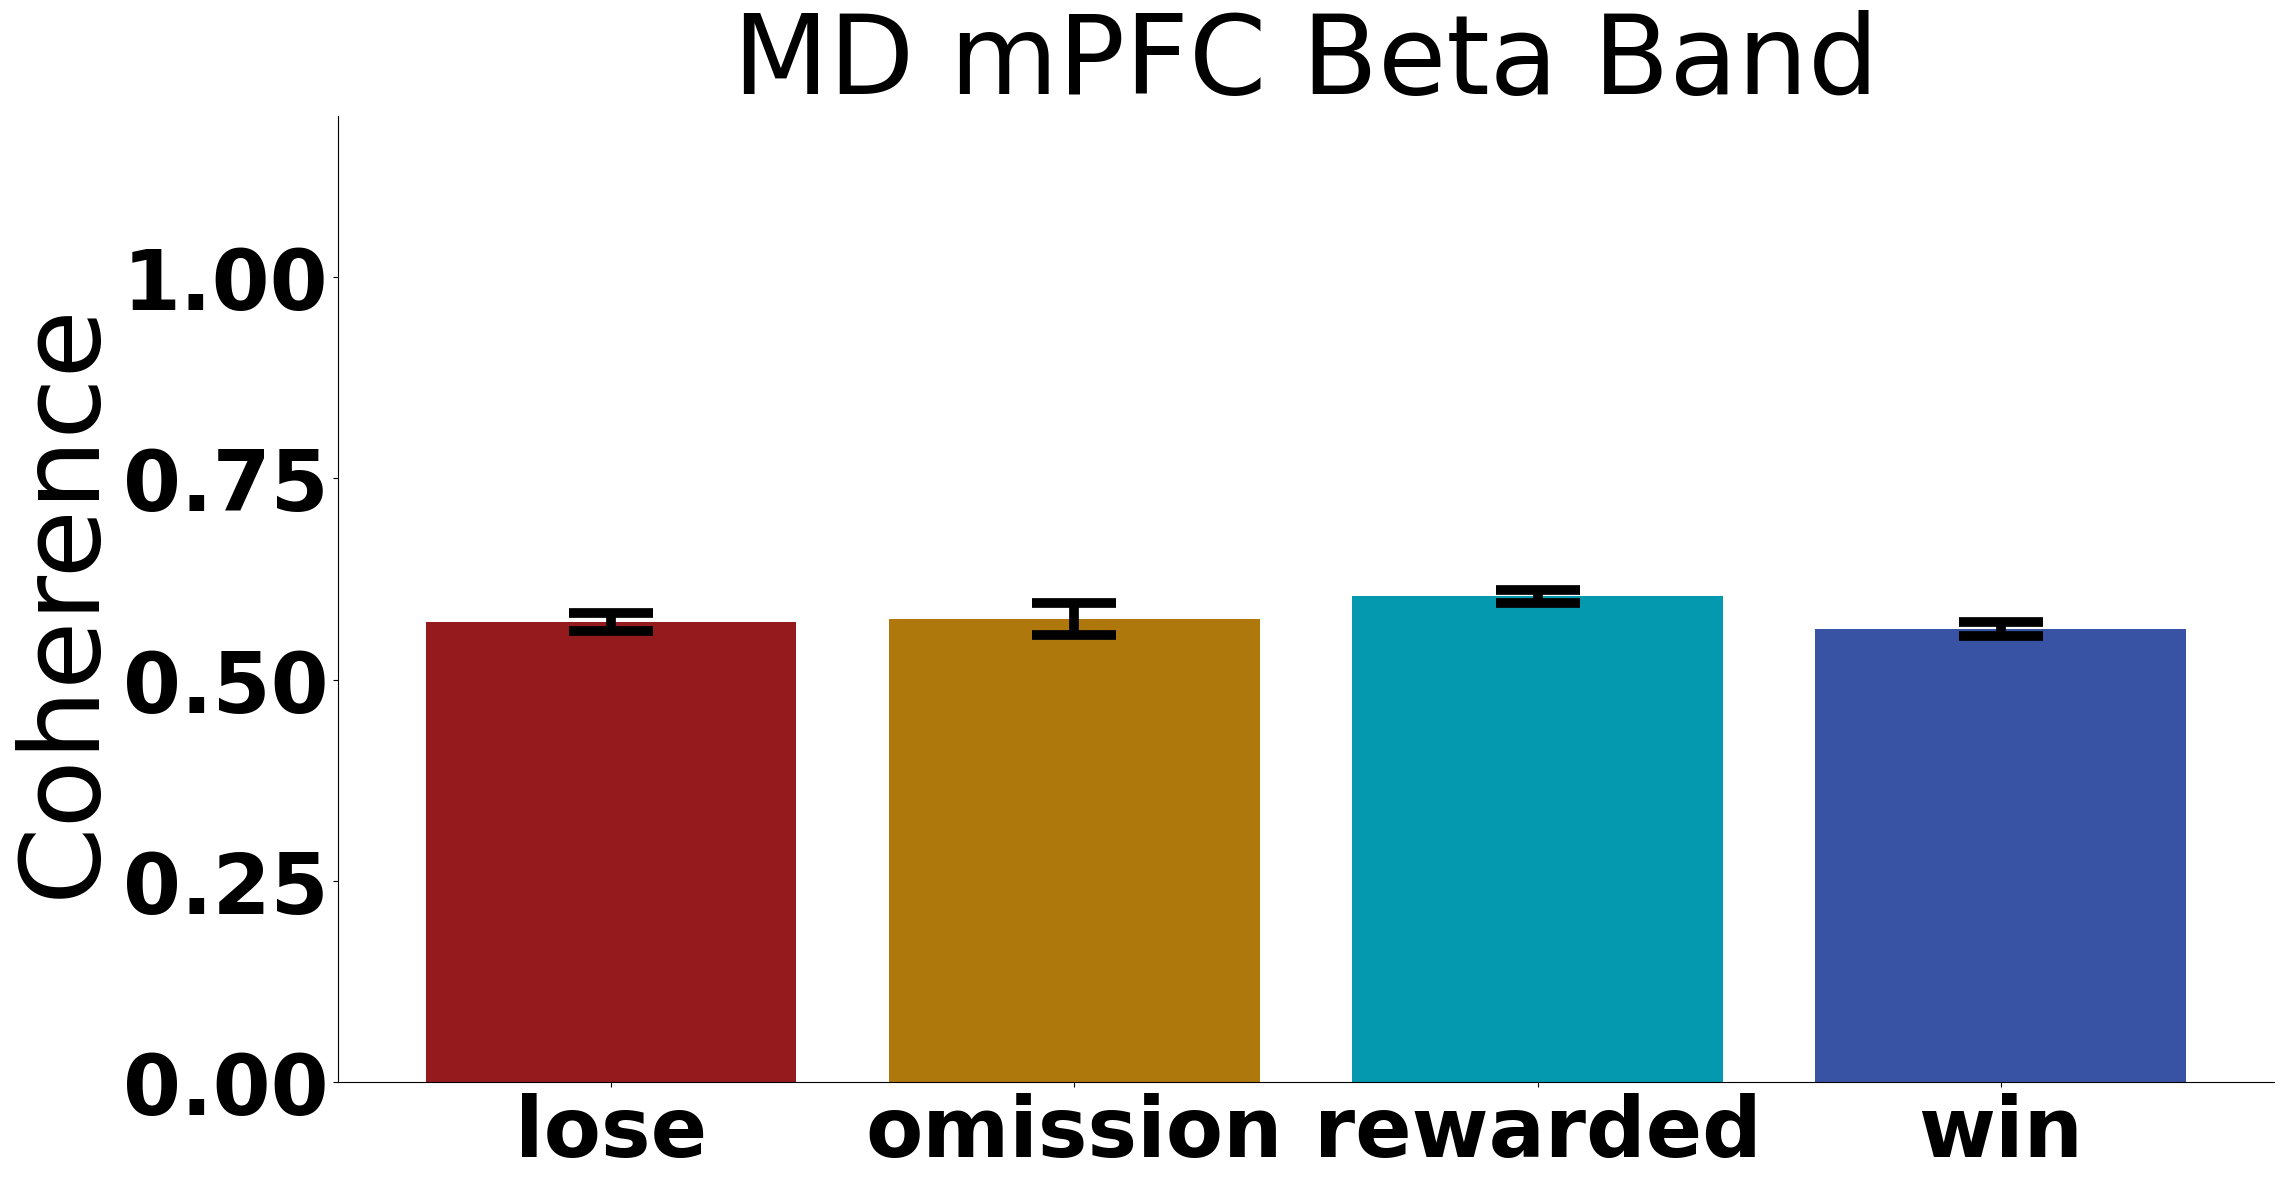

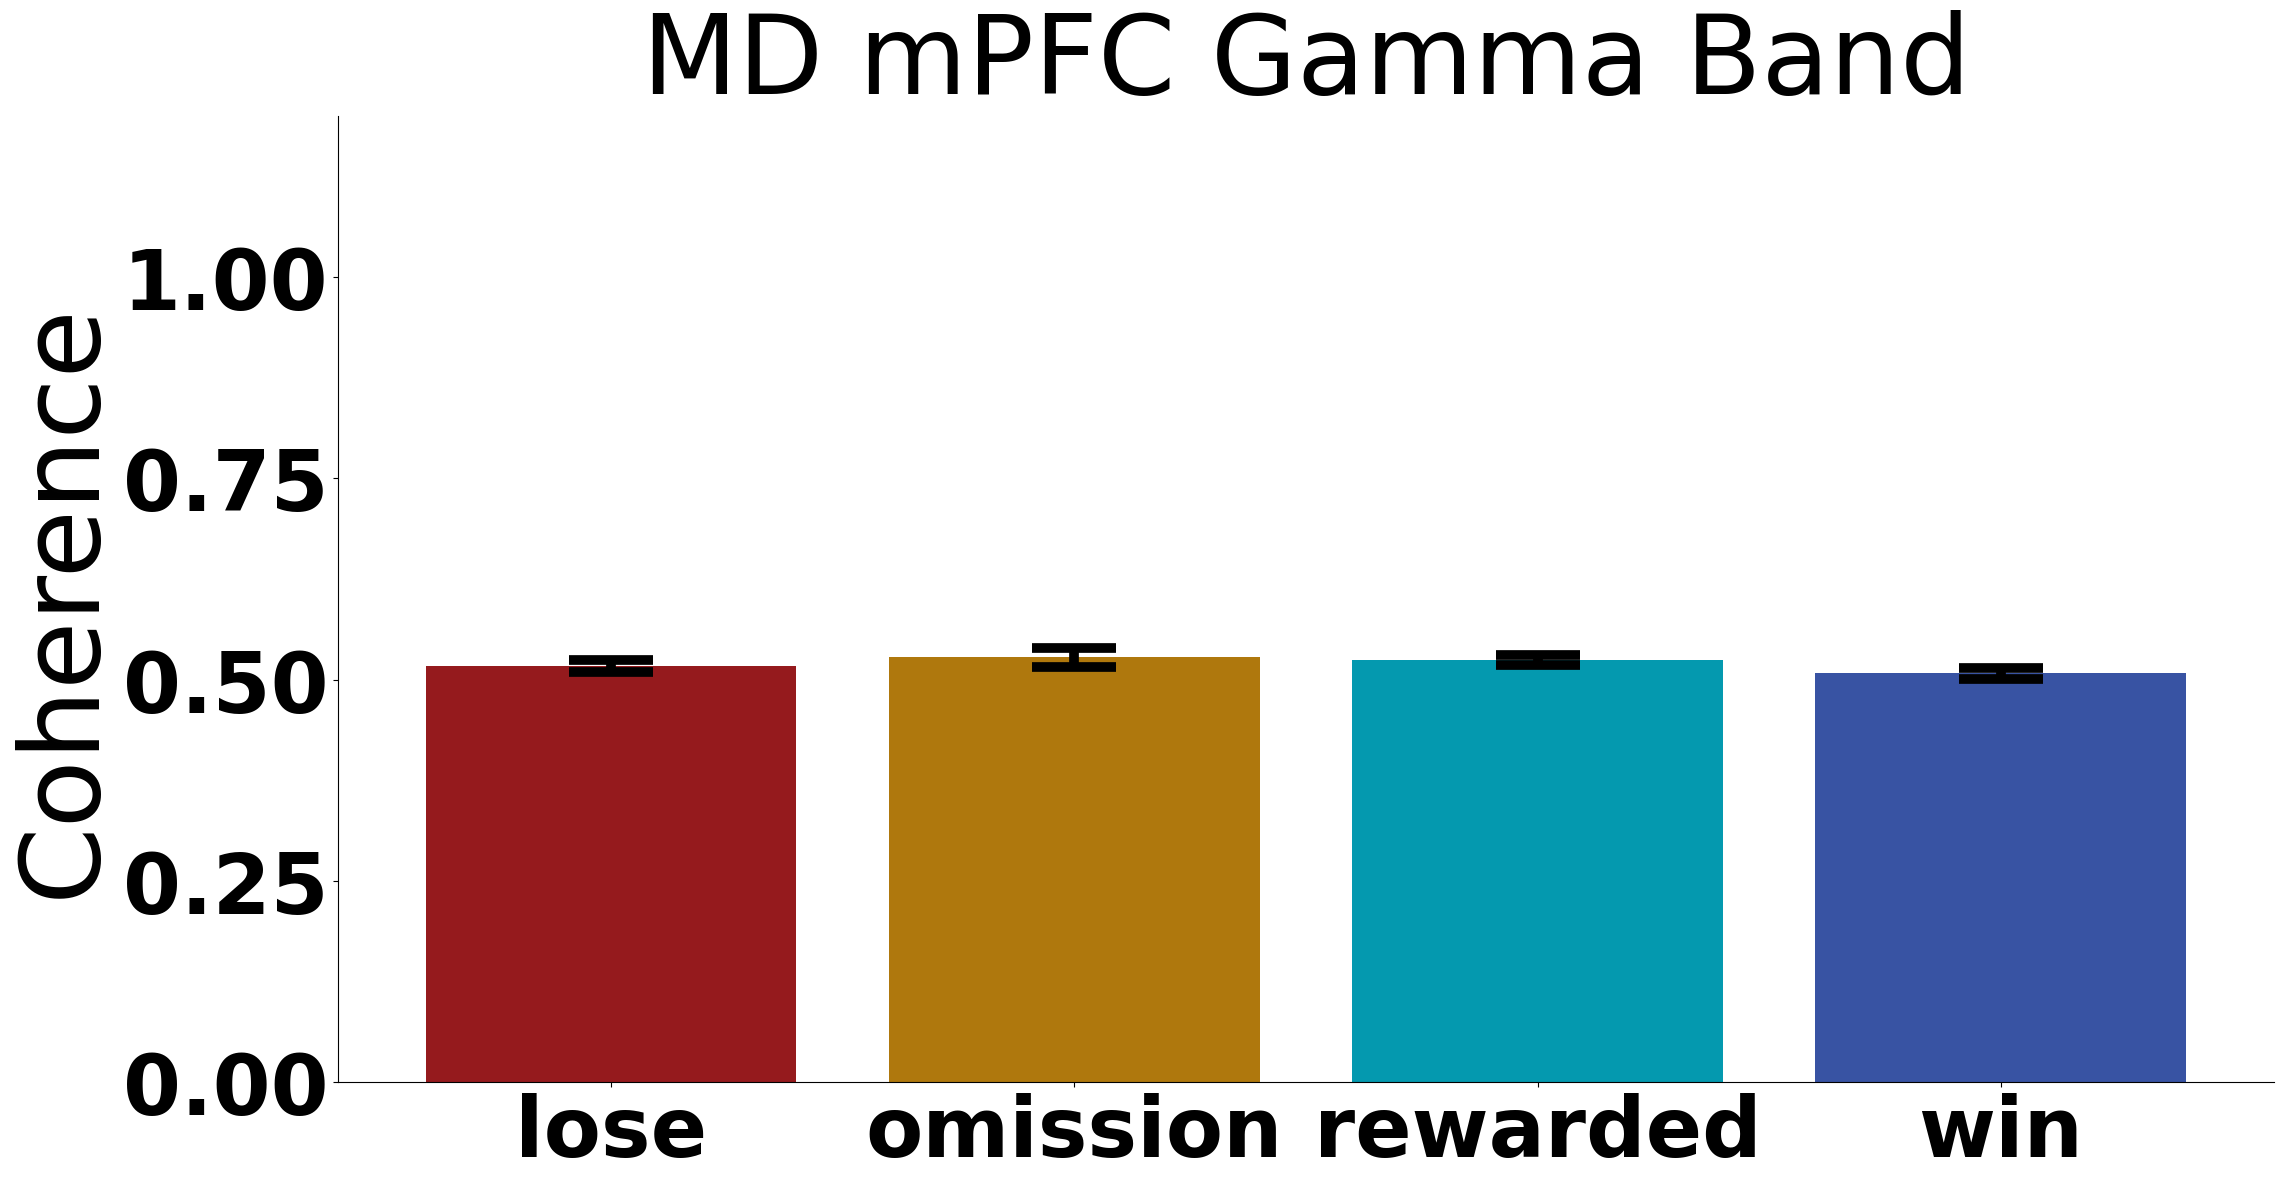

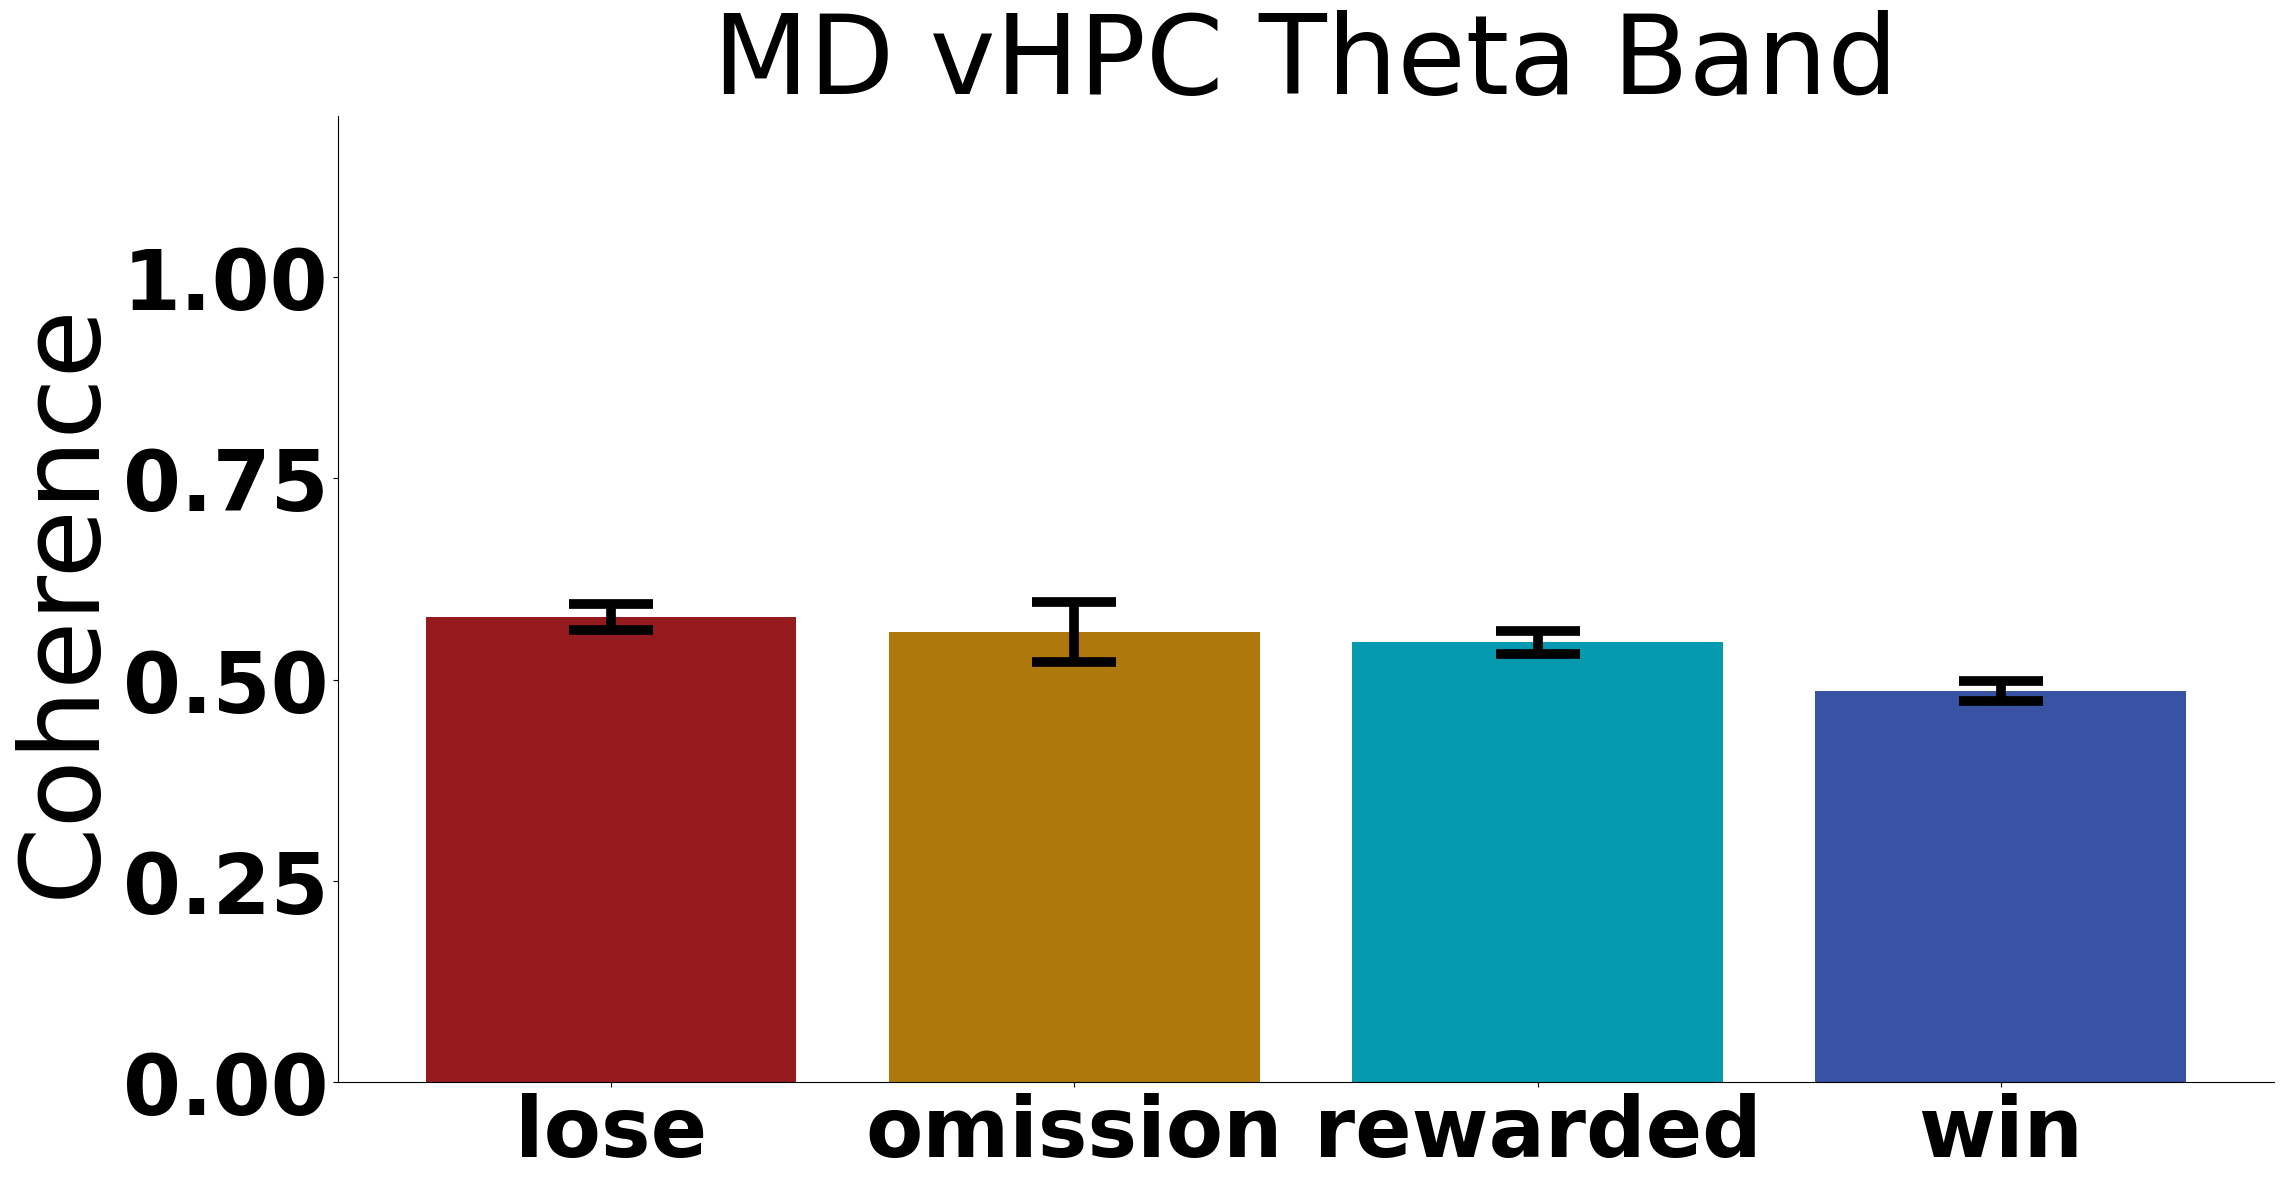

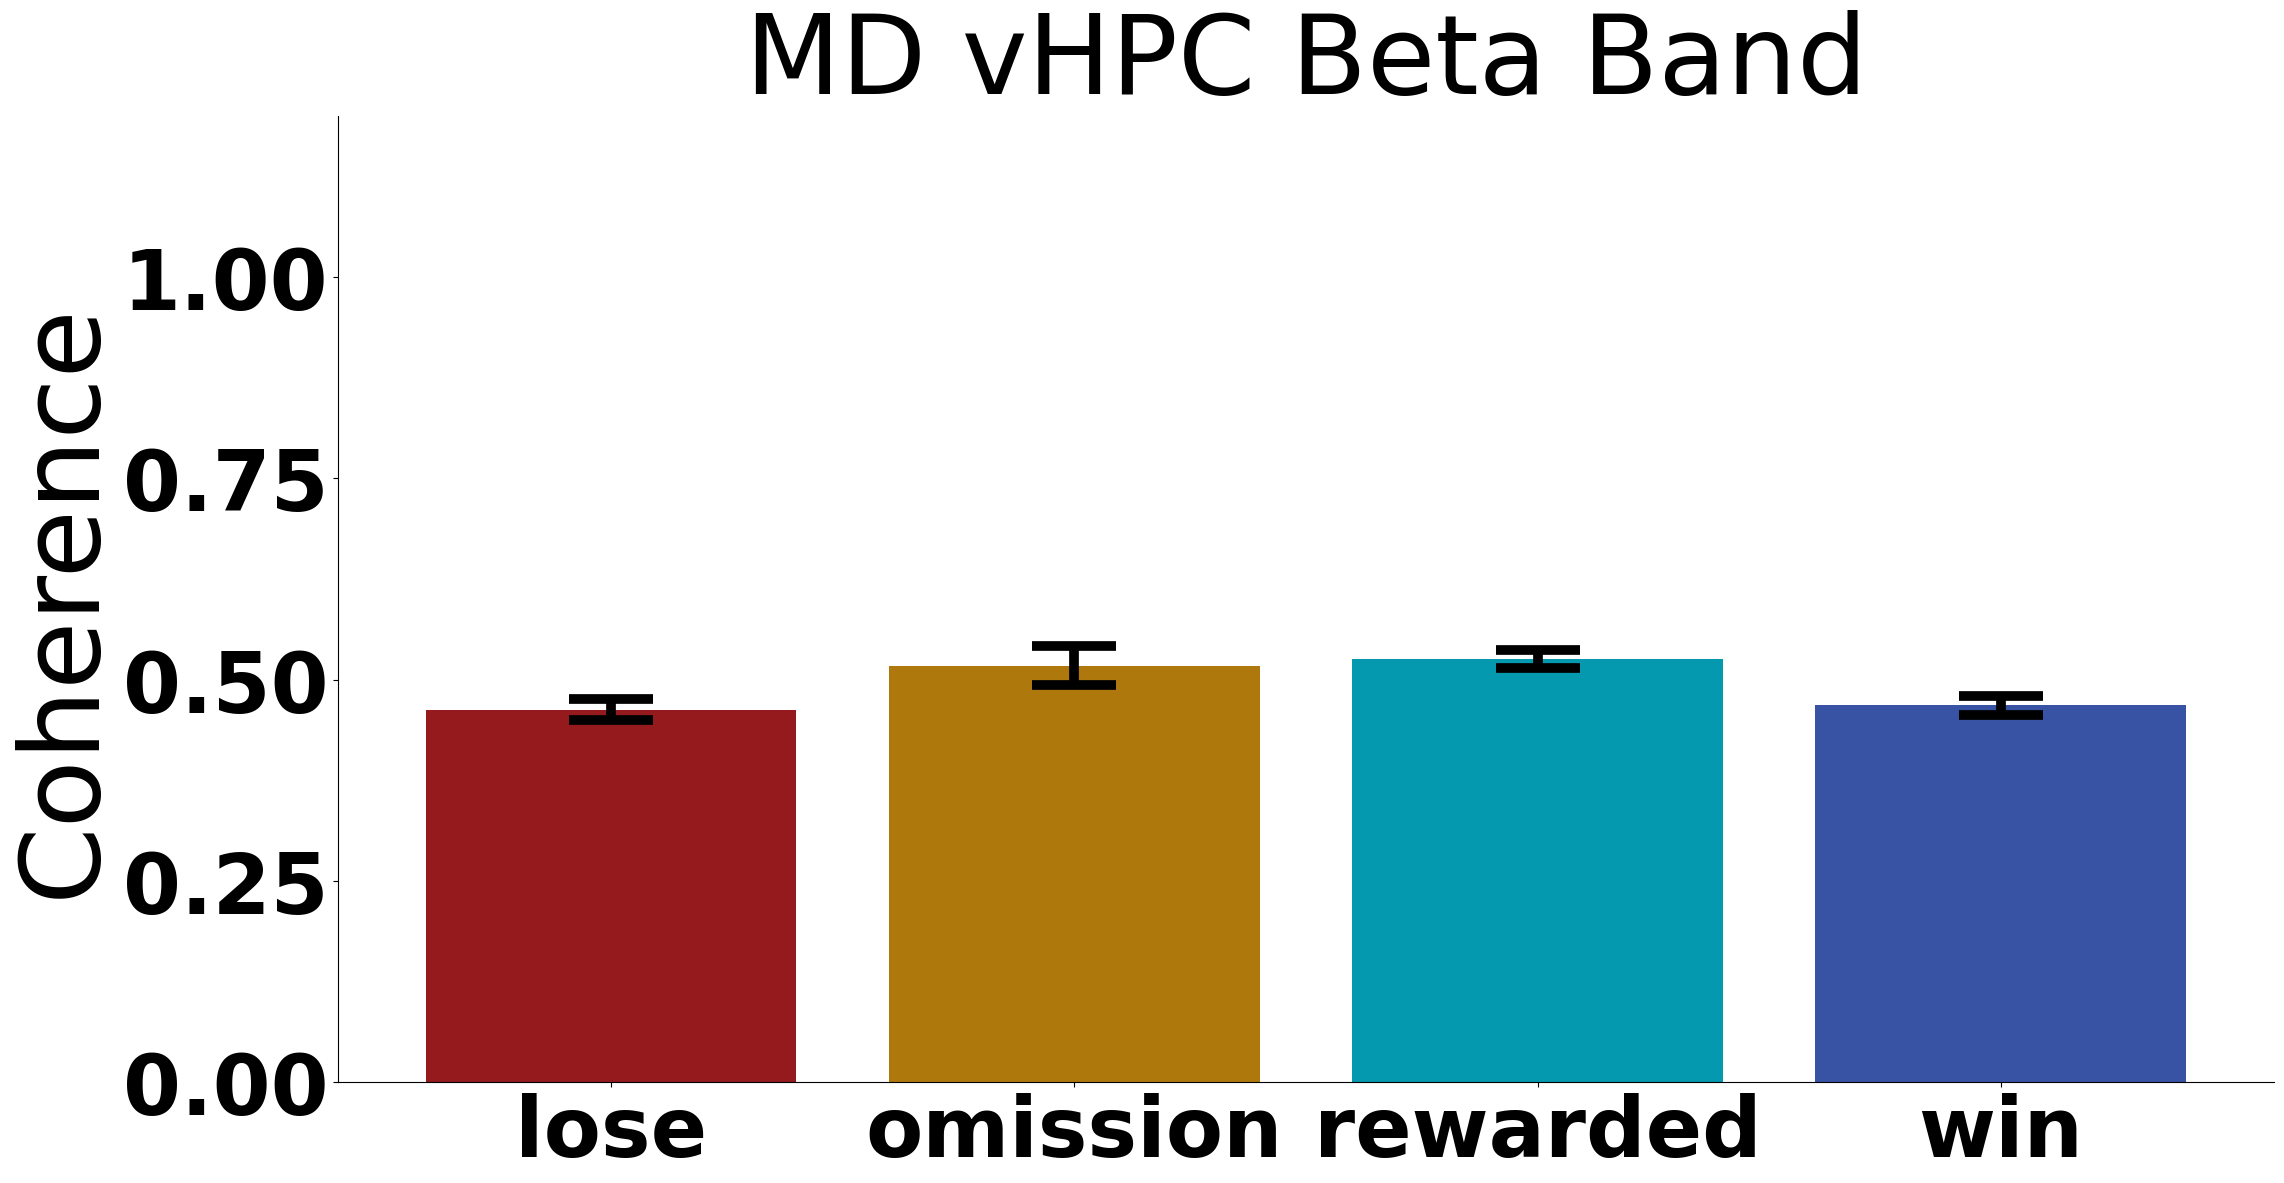

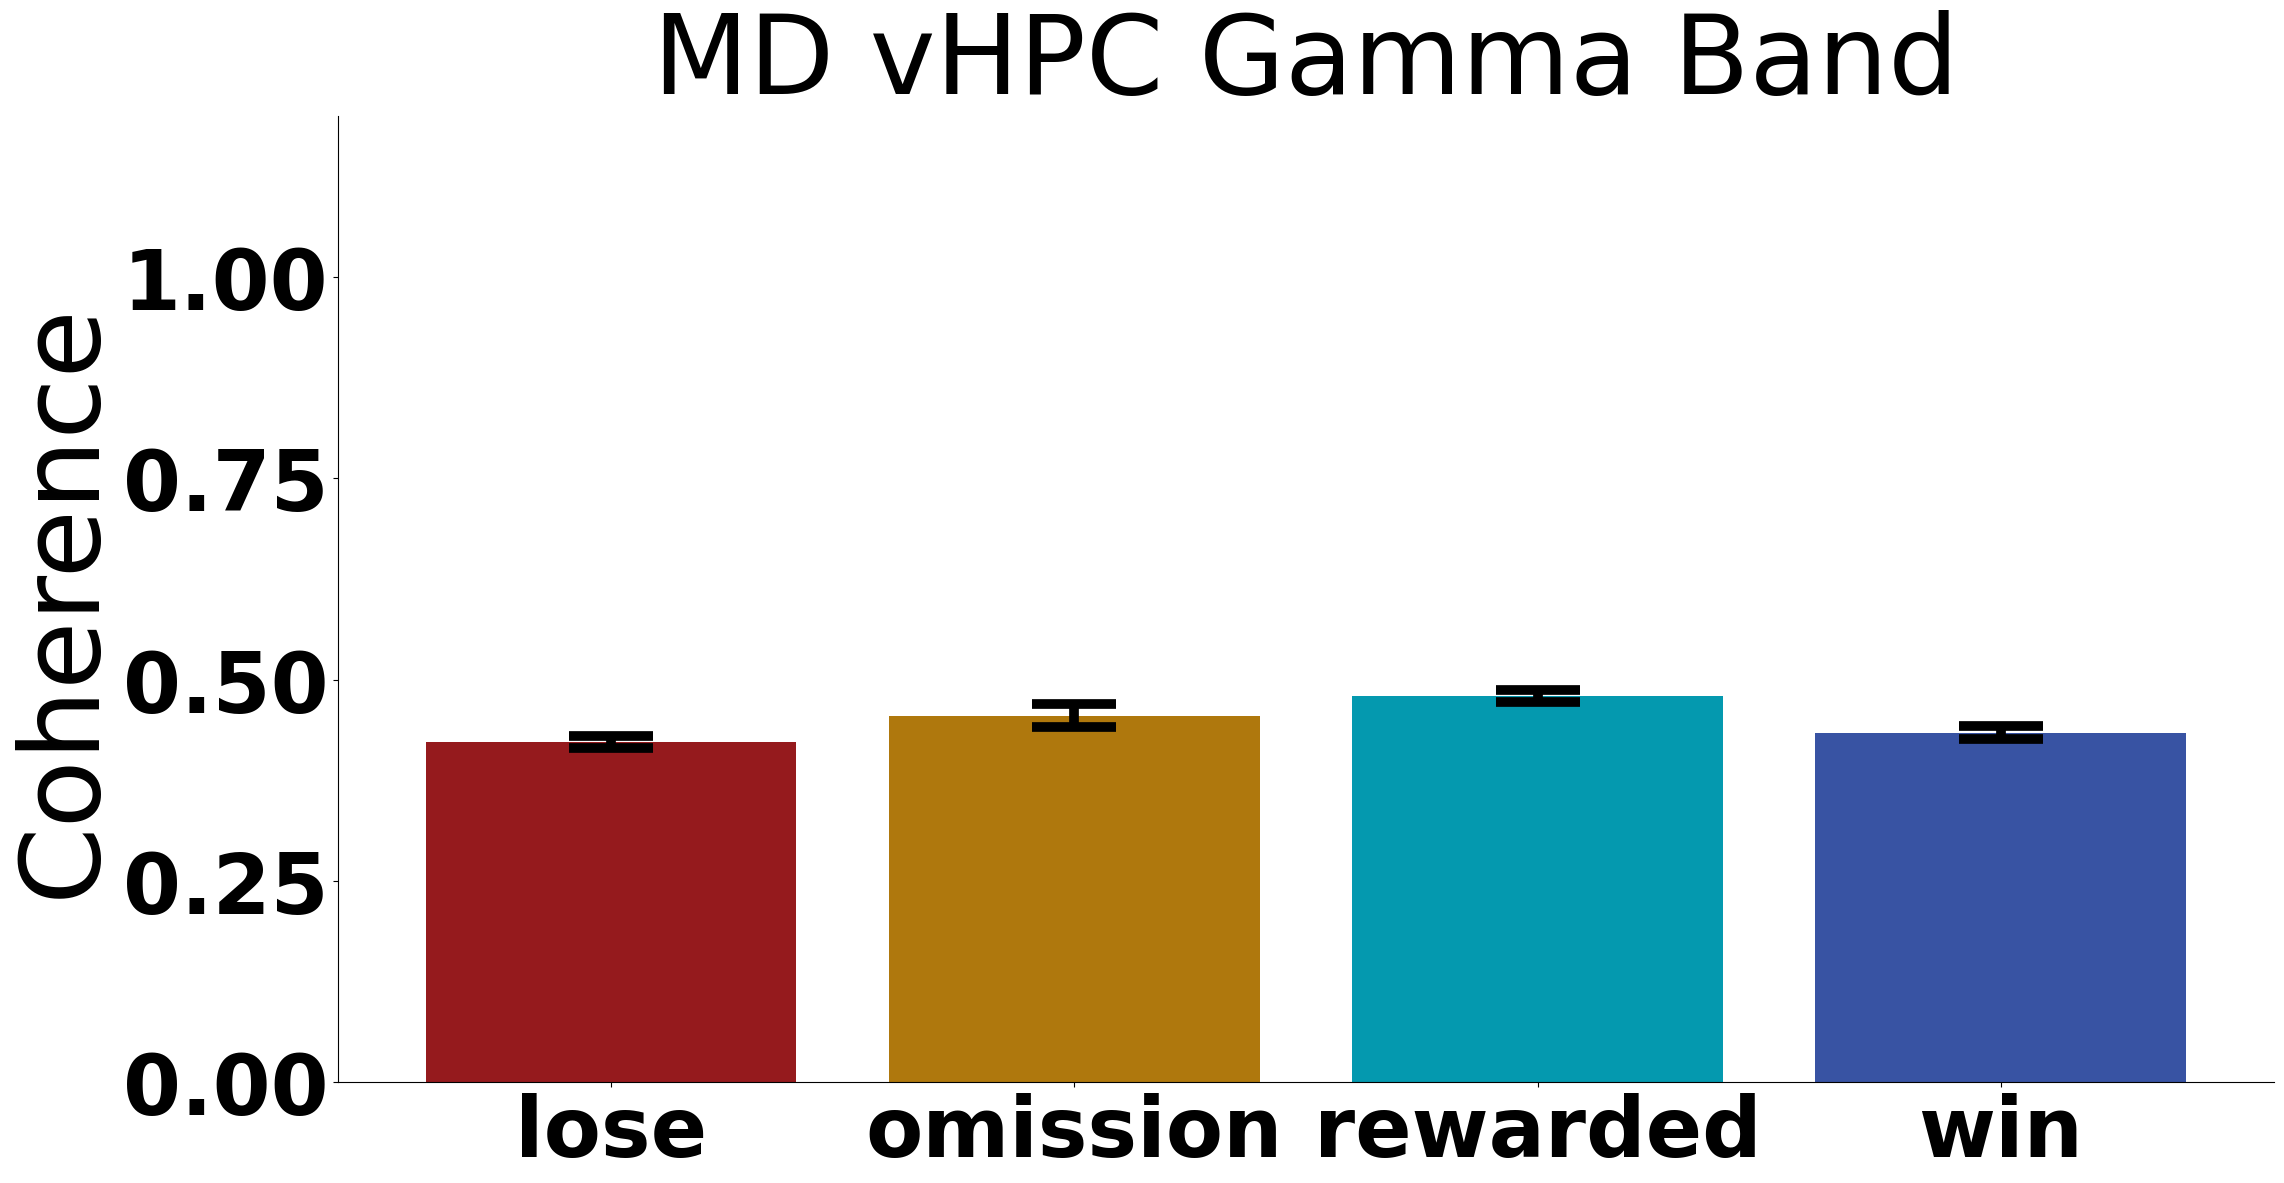

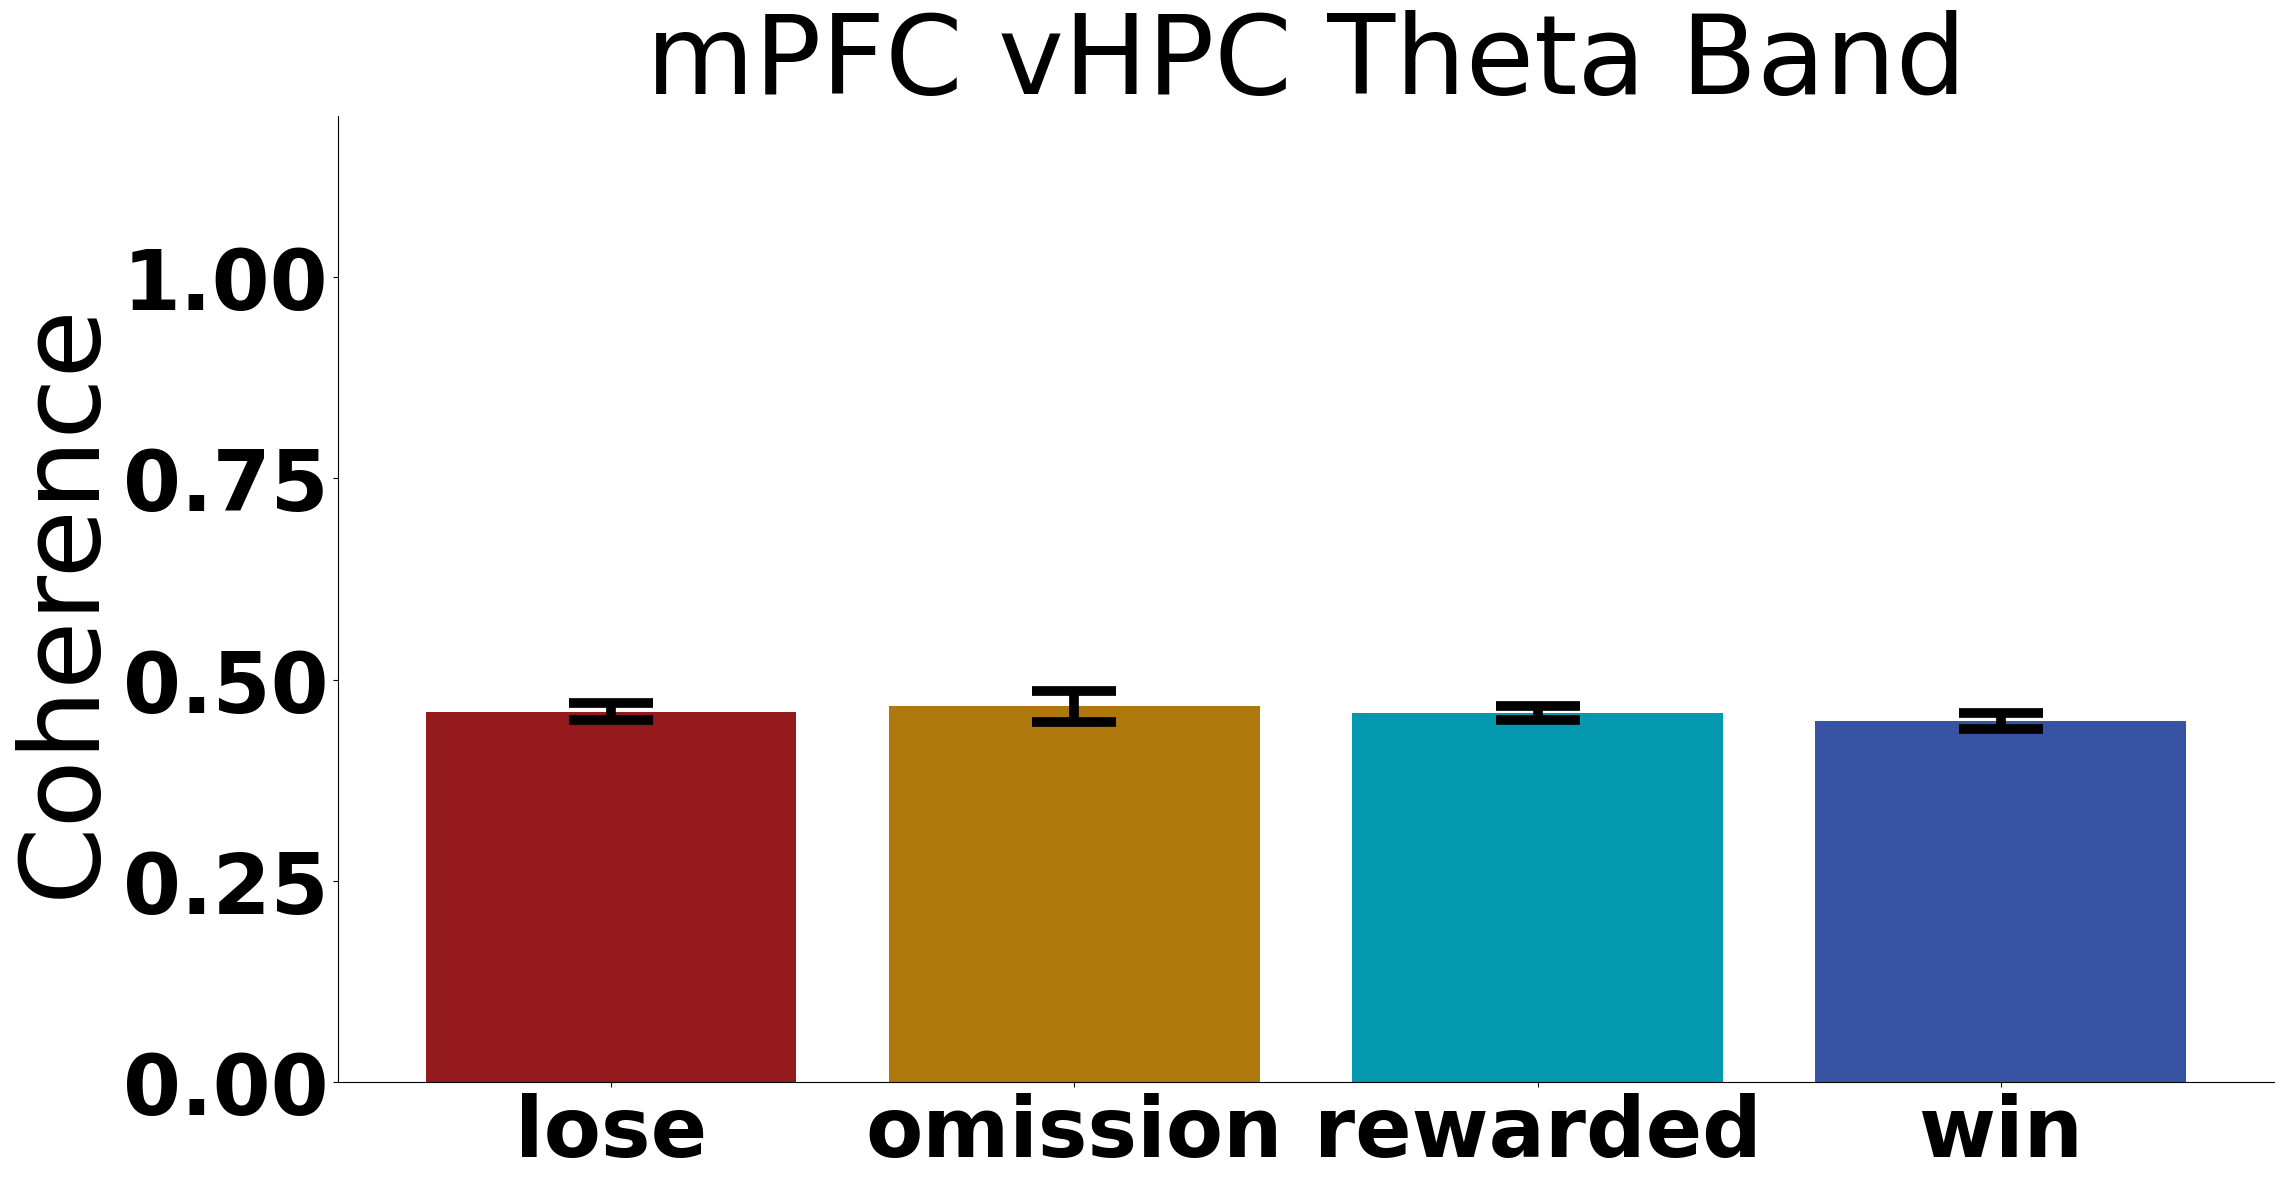

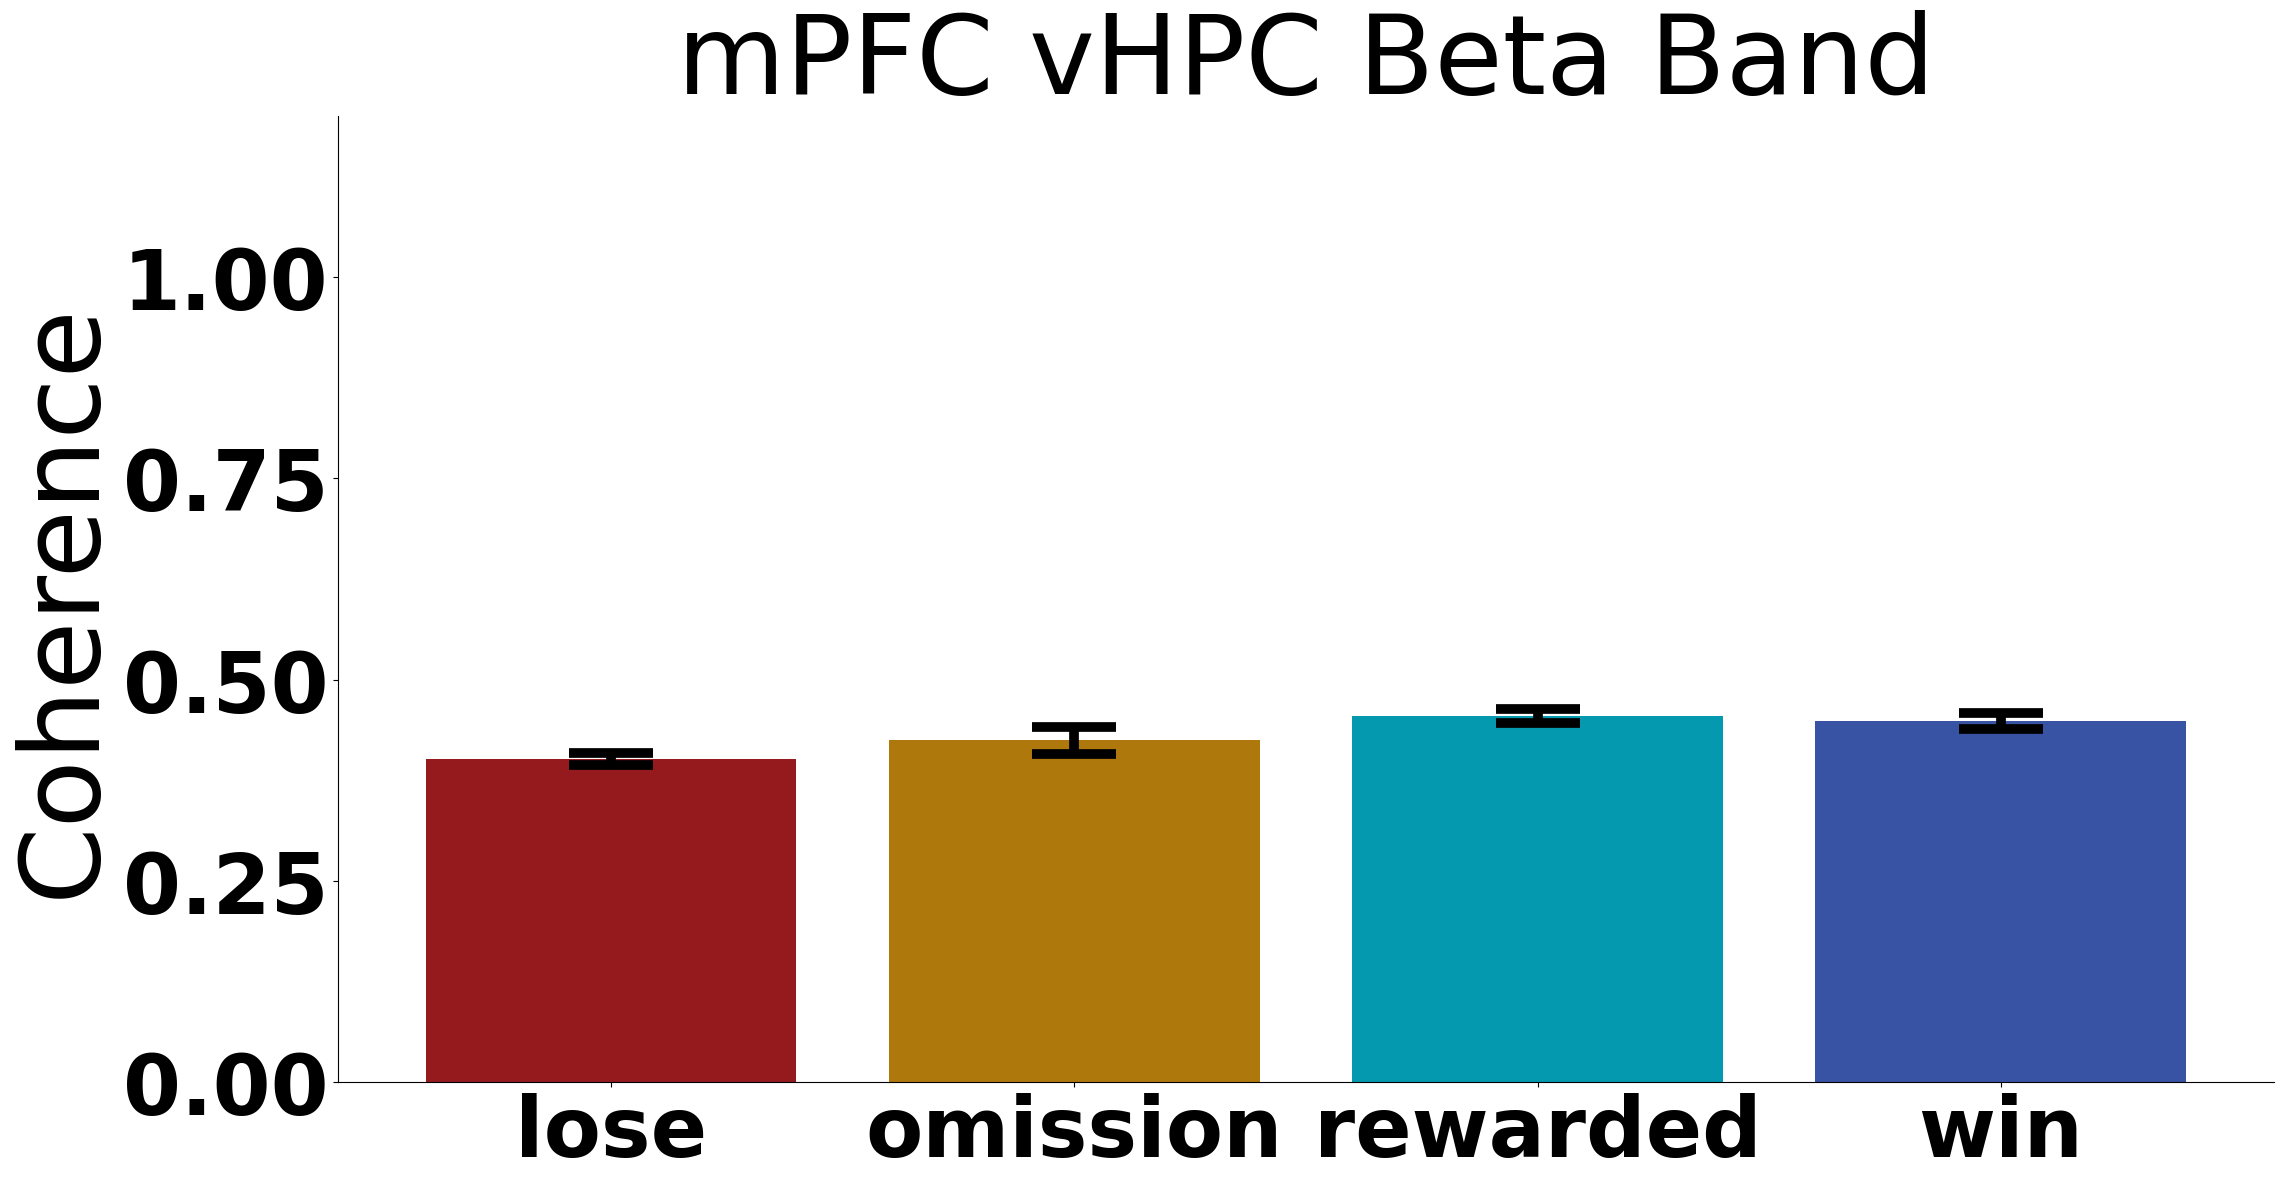

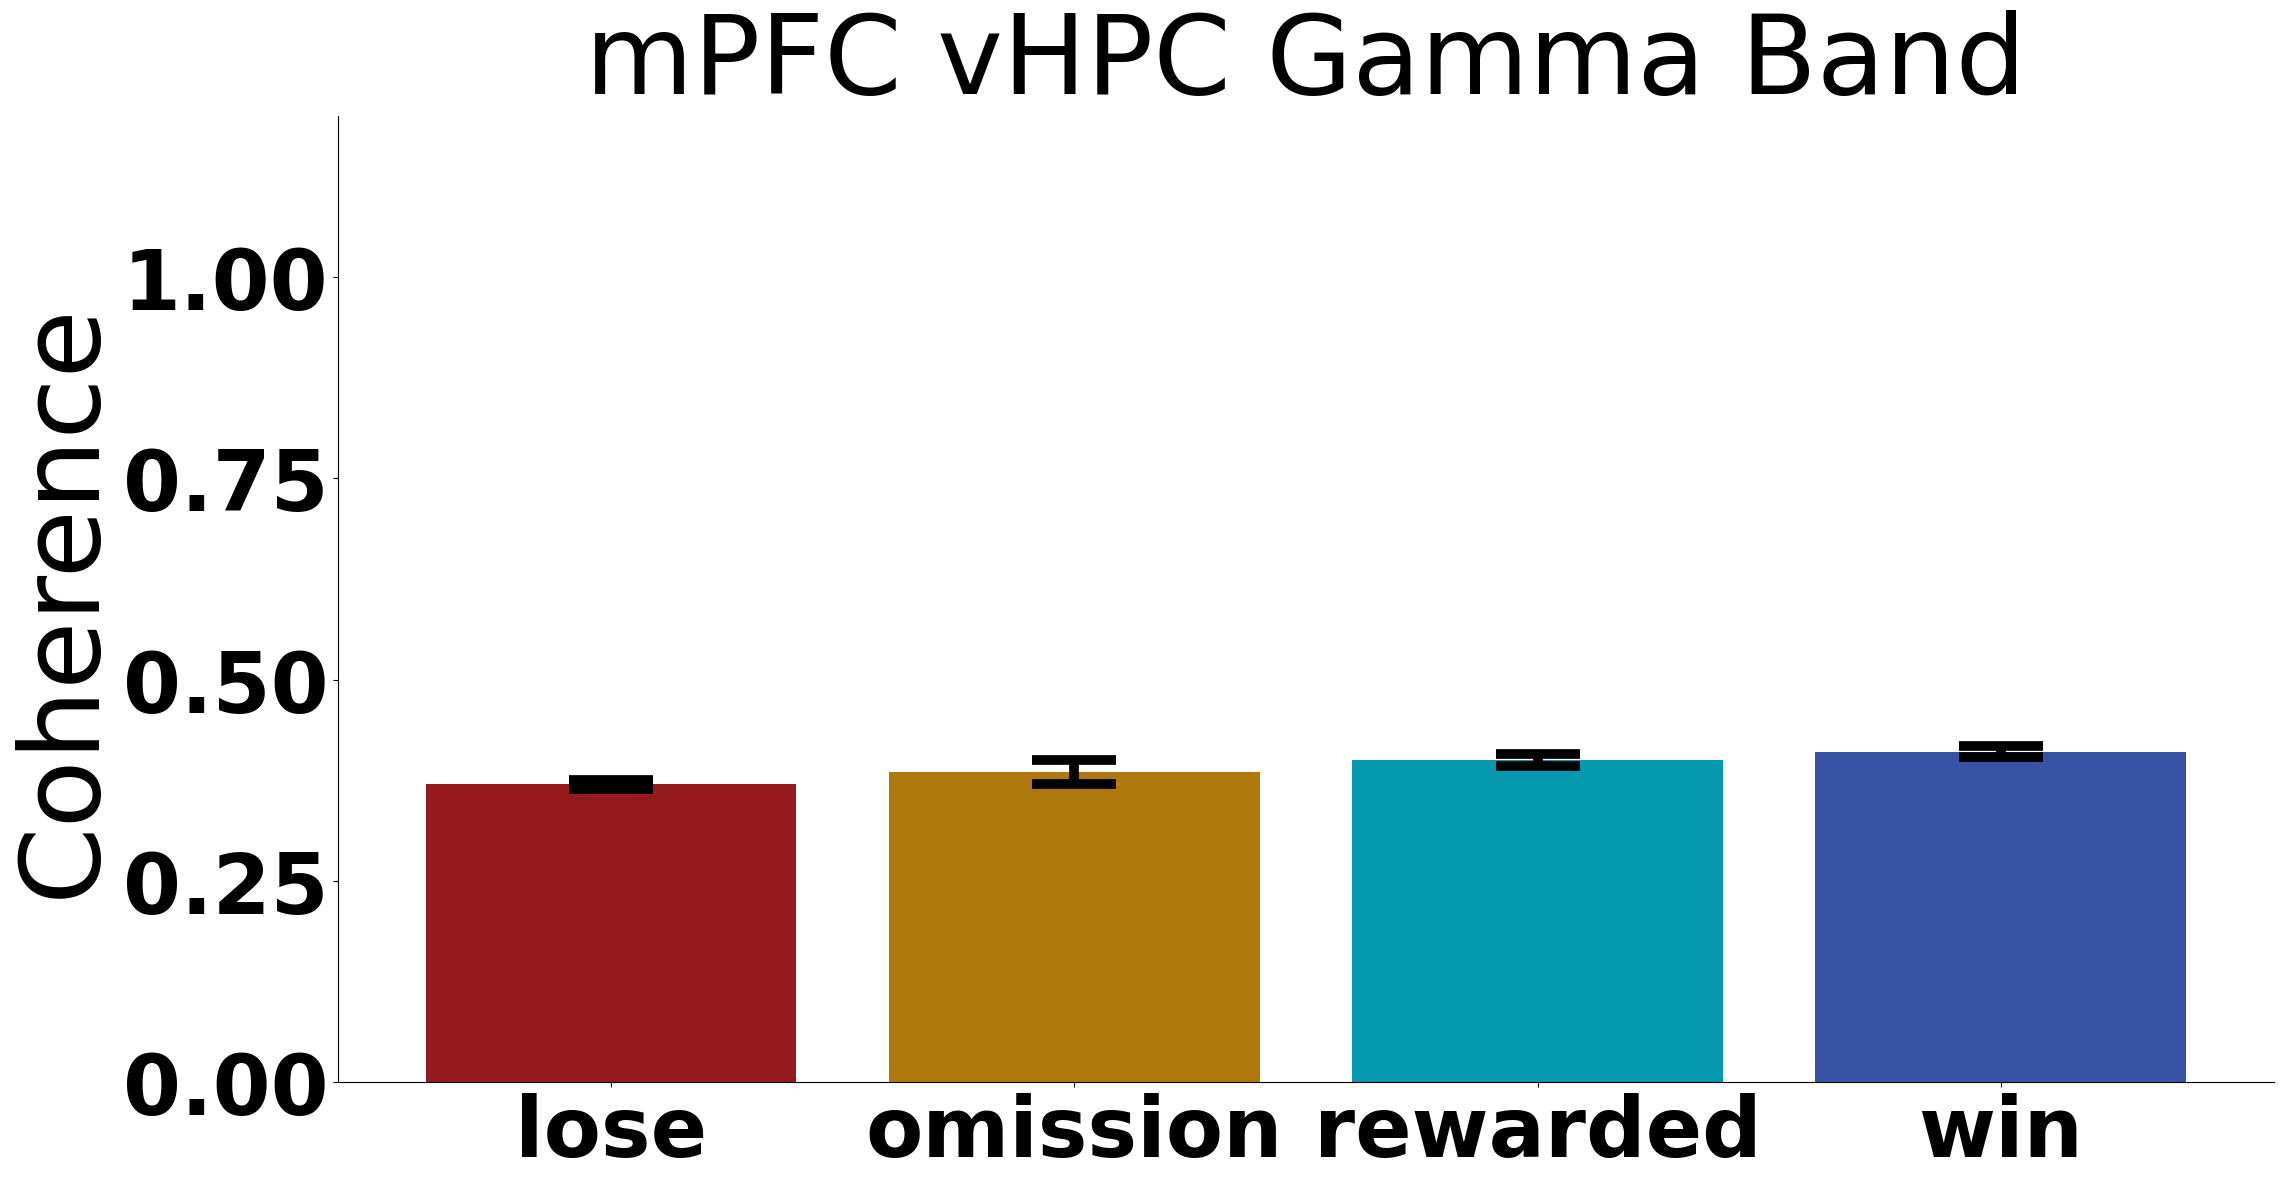

In [167]:
mean_coherence_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_coherence_columns].mean()
sem_coherence_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_coherence_columns].sem()

for column in band_coherence_columns:
    fig, ax = plt.subplots(figsize=(23, 12))

    region_1 = column.split("_")[0]
    region_2 = column.split("_")[1]
    band = column.split("_")[2]
    
    plt.title("{} {} {} Band".format(region_1, region_2, band.capitalize()), fontsize=80)
    plt.ylabel("Coherence", fontsize=80)
    bars = plt.bar(mean_coherence_df.index, mean_coherence_df[column], color=mean_coherence_df.index.map(OUTCOME_TO_COLOR))
    
    plt.errorbar(mean_coherence_df.index, mean_coherence_df[column],
        yerr=sem_coherence_df[column],
        color='k',
        capsize=30,
        linestyle='None',
        elinewidth=7,
        capthick=7)
    
    plt.ylim(0, 1.2)
    plt.xticks(fontsize=60)
    plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=60)
    # plt.locator_params(axis='y', nbins=4)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig("./proc/coherence/coherence_bar_plots/{}_{}_{}_all_windows_lfp_coherence_bar.eps".format(band, region_1, region_2)) #nancy changed png to eps
    plt.savefig("./proc/coherence/coherence_bar_plots/{}_{}_{}_all_windows_lfp_coherence_bar.png".format(band, region_1, region_2)) #nancy changed png to eps


# Plotting spectrograms

In [ ]:
# Create an array of frequency bin indices, starting from 1 to avoid division by zero
frequency_bins = np.arange(1, 50 + 1)

# Calculate the reference coherence following 1/f
reference_coherence = 1 / frequency_bins




In [ ]:
reference_coherence

In [ ]:
# Normalize the coherence in each frequency band by the reference coherence
# We use broadcasting to divide each column by the corresponding reference coherence value
normalized_spectrogram = spectrogram_data / reference_coherence

normalized_spectrogram

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
coherence_spectra.shape

In [ ]:
example_array = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]])

In [ ]:
example_array

In [ ]:
stats.zscore(example_array, axis=1)

In [ ]:
preprocessing.normalize(example_array, axis=1)

In [ ]:
coherence_spectra[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP["current_subject"].unique()

In [ ]:
from sklearn import preprocessing

In [ ]:
normalized_arr = preprocessing.normalize([x_array])

In [ ]:
coherence_spectra.max()

In [ ]:
for index, row in MERGED_LFP_AND_SLEAP[(MERGED_LFP_AND_SLEAP["trial_outcome"] == "rewarded")].iterrows():
    for col in coherence_col:
        trial_outcome = row["trial_outcome"]
        current_subject = row["current_subject"]
        region = col.split("_")[0]
        
        
        coherence_spectra = row[col][:, :50].T

        # coherence_spectra = coherence_spectra / reference_coherence.reshape(-1, 1)
        # coherence_spectra = np.log10(coherence_spectra)
        # coherence_spectra = preprocessing.normalize(coherence_spectra, axis=1)
        # coherence_spectra = np.log1p(coherence_spectra)
        # coherence_spectra = stats.zscore(coherence_spectra, axis=1)

        
        # Display the spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(coherence_spectra, aspect='auto', origin='lower', cmap='jet')#, norm=matplotlib.colors.LogNorm())
        plt.colorbar()
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.title('{} {} Spectrogram for Subject {}'.format(trial_outcome, region, current_subject))
        
        # Divide the current x-ticks by the divisor and set new x-tick labels
        # new_tick_locations = current_ticks / 10
        # new_tick_labels = [f"{tick/10:.1f}" for tick in current_ticks]
        new_tick_labels = [f"{tick/10-10}" for tick in current_ticks]
        
        
        plt.xticks(ticks=current_ticks, labels=new_tick_labels)
        plt.xlim(0,191)
        
        
        plt.show()
        


# Grouping all the shared trial outcomes together

In [ ]:
coherence_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "coherence" in col]

In [ ]:
MERGED_LFP_AND_SLEAP.groupby(["trial_outcome", "current_subject"]).count()

In [ ]:
# groupby_df  = MERGED_LFP_AND_SLEAP.groupby("trial_outcome")[coherence_col[0]].apply(lambda x: np.vstack(x).mean(axis=1))
groupby_df  = MERGED_LFP_AND_SLEAP.groupby(["current_subject", "trial_outcome"])[coherence_col].agg({k: lambda x: np.mean(np.stack(x), axis=0) for k in coherence_col}).reset_index()
# groupby_df  = MERGED_LFP_AND_SLEAP.groupby(["current_subject", "trial_outcome"])[coherence_col].agg({k: lambda x: np.mean(stats.zscore(np.stack(x), axis=1), axis=0) for k in coherence_col}).reset_index()


In [ ]:
groupby_df["mPFC_all_window_coherence"].iloc[0].shape

In [ ]:
matplotlib.scale.get_scale_names()

In [ ]:
for index, row in groupby_df.iterrows():
    for col in coherence_col:
        trial_outcome = row["trial_outcome"]
        current_subject = row["current_subject"]
        region = col.split("_")[0]
        
        
        coherence_spectra = row[col][:, :50].T
        # coherence_spectra = np.log10(coherence_spectra)

        # coherence_spectra = np.log1p(coherence_spectra)
        coherence_spectra = stats.zscore(coherence_spectra, axis=1)

        
        # Display the spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(coherence_spectra, aspect='auto', origin='lower', cmap='hsv')#, norm="log")
        plt.colorbar()
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.title('{} {} Spectrogram for Subject {}'.format(trial_outcome, region, current_subject))
        
        # Divide the current x-ticks by the divisor and set new x-tick labels
        # new_tick_locations = current_ticks / 10
        # new_tick_labels = [f"{tick/10:.1f}" for tick in current_ticks]
        new_tick_labels = [f"{tick/10-10}" for tick in current_ticks]
        
        
        plt.xticks(ticks=current_ticks, labels=new_tick_labels)
        plt.xlim(0,191)
        
        
        plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is the 2D Numpy array that contains the spectrogram data
# For demonstration, let's create a random 2D array
data = np.random.rand(1024, 1024)

# Display the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(example_data[:, :50].T, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram')

# Divide the current x-ticks by the divisor and set new x-tick labels
# new_tick_locations = current_ticks / 10
# new_tick_labels = [f"{tick/10:.1f}" for tick in current_ticks]
new_tick_labels = [f"{tick/10-10}" for tick in current_ticks]


plt.xticks(ticks=current_ticks, labels=new_tick_labels)
plt.xlim(0,191)


plt.show()

In [ ]:

# Importing libraries using import keyword.
import math
import numpy as np
import matplotlib.pyplot as plt
 
# Set the time difference to take picture of
# the the generated signal.
Time_difference = 0.0001
 
# Generating an array of values
Time_Array = np.linspace(0, 5, math.ceil(5 / Time_difference))
 
# Actual data array which needs to be plot
Data = 20*(np.sin(3 * np.pi * Time_Array))
 
# Matplotlib.pyplot.specgram() function to
# generate spectrogram
plt.specgram(Data, Fs=6, cmap="rainbow")
 
# Set the title of the plot, xlabel and ylabel
# and display using show() function
plt.title('Spectrogram Using matplotlib.pyplot.specgram() Method')
plt.xlabel("DATA")
plt.ylabel("TIME")
plt.show()

In [ ]:
example_data = groupby_df["BLA_all_window_coherence"].iloc[2]

In [ ]:
groupby_df

In [ ]:
# example_data = example_data[:5,:]


In [ ]:
example_data.shape

In [ ]:
example_data

In [ ]:
example_data = stats.zscore(example_data, axis=0, ddof=1)


In [ ]:
frequencies = MERGED_LFP_AND_SLEAP["BLA_frequencies"].iloc[0]

In [ ]:
example_data

In [ ]:
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 100.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

pylab.gca().yaxis.set_major_formatter(yfmt)

# final step
pylab.savefig("Output.pdf", dpi=400, bbox_inches='tight', pad_inches=1)

In [ ]:
20/191

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is the 2D Numpy array that contains the spectrogram data
# For demonstration, let's create a random 2D array
data = np.random.rand(1024, 1024)

# Display the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(example_data[:, :50].T, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram')

# Divide the current x-ticks by the divisor and set new x-tick labels
# new_tick_locations = current_ticks / 10
# new_tick_labels = [f"{tick/10:.1f}" for tick in current_ticks]
new_tick_labels = [f"{tick/10-10}" for tick in current_ticks]


plt.xticks(ticks=current_ticks, labels=new_tick_labels)
plt.xlim(0,191)


plt.show()

In [ ]:
current_ticks/10 - 10

In [ ]:
new_tick_locations

In [ ]:
data.shape

In [ ]:
example_data.shape

In [ ]:
example_data[:, :100].shape

In [ ]:
import numpy as np
from scipy.signal import spectrogram

# Assuming 'signal' is your 1D time-domain signal and 'fs' is the sampling frequency
frequencies, times, Sxx = spectrogram(signal, fs)

# Estimate the 1/f noise spectrum (could be more sophisticated than this)
one_over_f_noise = 1 / frequencies

# Normalize the coherence in each frequency band
# We replace zeros with ones to avoid division by zero
one_over_f_noise[one_over_f_noise == 0] = 1
normalized_Sxx = Sxx / one_over_f_noise[:, None]

# Optional: Rescale to [0, 1]
normalized_Sxx -= normalized_Sxx.min(axis=0)
normalized_Sxx /= normalized_Sxx.max(axis=0)

# Plot the normalized spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(normalized_Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized Spectrogram')
plt.yscale('log')  # Apply a logarithmic scale to frequency axis if desired
plt.show()